In [1]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect


import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections

from apoNN.src.occam import Occam
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load
from apoNN.src.plotting import summarize_representation
import apoNN.src.vectors as vector


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


### Generating z_ae

z_ae is the raw latents for the dataset

In [2]:
elem = "Fe"
mask_elem  = get_mask_elem(elem)
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/window/fel2/ae_20000.p",map_location=device)

/share/splinter/ddm/modules/apogee/apogee/spec/window.py:89: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True^numpy.isnan(win))).astype('int')


In [3]:
allStar =  load("allStar_training_clean")
dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)
n_data=10000

In [4]:
z_ae = vector.LatentVector(dataset,autoencoder,n_data)


/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,z = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


### Filtering z_ae

We want to do linear regression on the set of spectra. We must thus remove all spectra for which the enhancement estimation did not converge (these spectra then have "X_FE"=-9999)

In [5]:
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5



combined_cut = feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut

we create a second order polynomial with the features

In [6]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

In [7]:
z = vector.Vector(z_ae.raw[combined_cut[:n_data]],order=2,interaction_only=False)

### Carrying out linear regression

We can study the linearity of our resultant representation by carrying linear and non-linear regression with the latents. We use the astroNN abundances as a gold-standard


In [8]:
w = vector.LinearTransformation(z,y)
nonlinear_w = vector.NonLinearTransformation(z,y)
nonlinear_w.fit(n_epochs=1000)

err:2.89274525642395
err:1.3452188968658447
err:1.6704189777374268
err:1.2100130319595337
err:0.8268863558769226
err:1.4110486507415771
err:1.5704337358474731
err:1.2746952772140503
err:1.069524884223938
err:0.8739874362945557
err:0.48696228861808777
err:0.7556725740432739
err:0.7835941314697266
err:1.201876163482666
err:0.6821147203445435
err:0.6186090111732483
err:0.5978747606277466
err:0.5291162729263306
err:0.7344947457313538
err:0.5747917890548706
err:0.9847851395606995
err:0.9128842949867249
err:0.4575749635696411
err:0.43695199489593506
err:0.5065639019012451
err:0.643819272518158
err:0.605198860168457
err:0.5874030590057373
err:0.5316246151924133
err:0.5615496039390564
err:0.40896090865135193
err:0.8731944561004639
err:0.5804087519645691
err:0.5360280871391296
err:0.5053520798683167
err:0.3717578649520874
err:0.31353628635406494
err:0.2934824526309967
err:0.2841026186943054
err:0.3280714154243469
err:0.6537834405899048
err:0.44693344831466675
err:0.3150480389595032
err:0.642355

err:0.02446463517844677
err:0.030122946947813034
err:0.024784624576568604
err:0.023472698405385017
err:0.024487532675266266
err:0.02339525707066059
err:0.03132697939872742
err:0.03876267373561859
err:0.02396596223115921
err:0.02937806397676468
err:0.0191291943192482
err:0.03204035013914108
err:0.04458741471171379
err:0.0370575413107872
err:0.041616976261138916
err:0.041622672230005264
err:0.045884180814027786
err:0.03161163628101349
err:0.03129548206925392
err:0.044765885919332504
err:0.029876308515667915
err:0.025039605796337128
err:0.030699005350470543
err:0.03856593742966652
err:0.041889142245054245
err:0.030611388385295868
err:0.028026847168803215
err:0.03370952233672142
err:0.03247853368520737
err:0.020977353677153587
err:0.023973630741238594
err:0.026349158957600594
err:0.03044283576309681
err:0.030447131022810936
err:0.02476963773369789
err:0.024824485182762146
err:0.02694343961775303
err:0.02596844546496868
err:0.018544260412454605
err:0.023253826424479485
err:0.026346061378717

err:0.018536318093538284
err:0.017582274973392487
err:0.023992327973246574
err:0.022836102172732353
err:0.019667262211441994
err:0.013897455297410488
err:0.013319878838956356
err:0.01636364869773388
err:0.01854420267045498
err:0.020557640120387077
err:0.012695591896772385
err:0.016903959214687347
err:0.01611015759408474
err:0.013126478530466557
err:0.014943396672606468
err:0.012730414979159832
err:0.018064796924591064
err:0.021156206727027893
err:0.016190344467759132
err:0.020194020122289658
err:0.013033821247518063
err:0.014421060681343079
err:0.015260844491422176
err:0.012978720478713512
err:0.014379272237420082
err:0.014880443923175335
err:0.01804797537624836
err:0.0160300862044096
err:0.01433641742914915
err:0.015776390209794044
err:0.02029488794505596
err:0.015989847481250763
err:0.015603465959429741
err:0.01653205417096615
err:0.015395659022033215
err:0.020401498302817345
err:0.025729721412062645
err:0.015853986144065857
err:0.019107477739453316
err:0.013309700414538383
err:0.022

err:0.016414523124694824
err:0.0166054405272007
err:0.02601737529039383
err:0.017879057675600052
err:0.01445998065173626
err:0.018758416175842285
err:0.021736573427915573
err:0.020541200414299965
err:0.016744978725910187
err:0.016017237678170204
err:0.020252138376235962
err:0.01742570474743843
err:0.012255283072590828
err:0.013177384622395039
err:0.013838734477758408
err:0.016674192622303963
err:0.01933593675494194
err:0.01357785239815712
err:0.012873792089521885
err:0.014049622230231762
err:0.013675298541784286
err:0.00922937598079443
err:0.013507685624063015
err:0.013666274026036263
err:0.014581753872334957
err:0.012813138775527477
err:0.014675711281597614
err:0.014505446888506413
err:0.013728209771215916
err:0.01926460675895214
err:0.017515001818537712
err:0.015032374300062656
err:0.010557208210229874
err:0.010209216736257076
err:0.01264344621449709
err:0.014264174737036228
err:0.015737146139144897
err:0.009260906837880611
err:0.01287928782403469
err:0.012509483844041824
err:0.01022

err:0.011284004896879196
err:0.01316655334085226
err:0.008213775232434273
err:0.00976695865392685
err:0.009471933357417583
err:0.008785771206021309
err:0.00896366871893406
err:0.010397214442491531
err:0.012673968449234962
err:0.011163377203047276
err:0.010000232607126236
err:0.010269036516547203
err:0.0136635173112154
err:0.010692632757127285
err:0.010439793579280376
err:0.011584118008613586
err:0.01104368269443512
err:0.01277043204754591
err:0.017506761476397514
err:0.010770474560558796
err:0.01328024361282587
err:0.009912874549627304
err:0.015585431829094887
err:0.021998107433319092
err:0.01953684352338314
err:0.019247492775321007
err:0.018623949959874153
err:0.02368757128715515
err:0.01387974712997675
err:0.013994595035910606
err:0.02212752029299736
err:0.01546380203217268
err:0.0127212293446064
err:0.0161757729947567
err:0.018172066658735275
err:0.016495514661073685
err:0.014398707076907158
err:0.013866613619029522
err:0.017672255635261536
err:0.01509053260087967
err:0.010691193863

err:0.010028040036559105
err:0.011067386716604233
err:0.010813669301569462
err:0.007075202651321888
err:0.011176940985023975
err:0.010788054205477238
err:0.011768406257033348
err:0.010112005285918713
err:0.011947873048484325
err:0.01176341064274311
err:0.011197990737855434
err:0.016548452898859978
err:0.014199690893292427
err:0.011737954802811146
err:0.008430001325905323
err:0.008233299478888512
err:0.009939044713973999
err:0.011393817141652107
err:0.012375912629067898
err:0.00721776345744729
err:0.010215576738119125
err:0.010266274213790894
err:0.00817830115556717
err:0.009206048212945461
err:0.008245113305747509
err:0.010109996423125267
err:0.01367576140910387
err:0.010242894291877747
err:0.011941814795136452
err:0.007333667948842049
err:0.008781624026596546
err:0.008649582043290138
err:0.008110237307846546
err:0.008071075193583965
err:0.00947616994380951
err:0.011586863547563553
err:0.010105079039931297
err:0.009079152718186378
err:0.009268943220376968
err:0.01234862394630909
err:0.

err:0.009917527437210083
err:0.010104633867740631
err:0.014997320249676704
err:0.00918562337756157
err:0.011581171303987503
err:0.008763577789068222
err:0.013192559592425823
err:0.018756451085209846
err:0.016386279836297035
err:0.016171984374523163
err:0.01512005366384983
err:0.0197775736451149
err:0.011876526288688183
err:0.011735108681023121
err:0.018515871837735176
err:0.013110565021634102
err:0.010988838970661163
err:0.013746128417551517
err:0.014841255731880665
err:0.013465091586112976
err:0.012323761358857155
err:0.011931546032428741
err:0.015059707686305046
err:0.012997804209589958
err:0.009190594777464867
err:0.009703356772661209
err:0.010182702913880348
err:0.012481559067964554
err:0.014001072384417057
err:0.010250980965793133
err:0.009256923571228981
err:0.01023916993290186
err:0.009942601434886456
err:0.006495302077382803
err:0.010548076592385769
err:0.01000463217496872
err:0.01094969641417265
err:0.009312073700129986
err:0.011153283528983593
err:0.010843122377991676
err:0.0

err:0.007225403096526861
err:0.008512868545949459
err:0.00998030323535204
err:0.010731267742812634
err:0.006356532219797373
err:0.008937031961977482
err:0.009127102792263031
err:0.007235685363411903
err:0.008028831332921982
err:0.007446121424436569
err:0.008802929893136024
err:0.01214162539690733
err:0.009023481979966164
err:0.010609809309244156
err:0.006499000359326601
err:0.007680393755435944
err:0.007880184799432755
err:0.00732577545568347
err:0.007073566783219576
err:0.008359048515558243
err:0.010222112759947777
err:0.008911113254725933
err:0.007979796268045902
err:0.008223178796470165
err:0.010998067446053028
err:0.008559376001358032
err:0.00830325111746788
err:0.009181058034300804
err:0.009442942216992378
err:0.009341745637357235
err:0.014222380705177784
err:0.008687927387654781
err:0.01081800740212202
err:0.00836982112377882
err:0.012200623750686646
err:0.017572451382875443
err:0.015187567099928856
err:0.015027845278382301
err:0.013918557204306126
err:0.01844801753759384
err:0.0

err:0.00978370662778616
err:0.012128191068768501
err:0.012705028057098389
err:0.01189930085092783
err:0.010990593582391739
err:0.010603767819702625
err:0.013275493867695332
err:0.011797339655458927
err:0.008189883083105087
err:0.008602974005043507
err:0.008976218290627003
err:0.0113071845844388
err:0.012340553104877472
err:0.0091924499720335
err:0.008384951390326023
err:0.009169711731374264
err:0.008822049014270306
err:0.0057883006520569324
err:0.009601635858416557
err:0.009011486545205116
err:0.00987280998378992
err:0.008238977752625942
err:0.009993359446525574
err:0.009558593854308128
err:0.009238103404641151
err:0.01467332523316145
err:0.011620241217315197
err:0.009136679582297802
err:0.006970258429646492
err:0.006779072340577841
err:0.007892269641160965
err:0.009367191232740879
err:0.010017095133662224
err:0.005991985090076923
err:0.008391653187572956
err:0.008638544008135796
err:0.006805884186178446
err:0.0075058238580822945
err:0.00713743269443512
err:0.008308600634336472
err:0.0

err:0.006666978821158409
err:0.006370748393237591
err:0.007496398873627186
err:0.009086682461202145
err:0.008082638494670391
err:0.007168653886765242
err:0.0075451042503118515
err:0.010064379312098026
err:0.0077597275376319885
err:0.007640451658517122
err:0.008197301998734474
err:0.00863996148109436
err:0.008266090415418148
err:0.013113622553646564
err:0.00798002164810896
err:0.009688070975244045
err:0.0077874064445495605
err:0.010715308599174023
err:0.015883253887295723
err:0.013481923379004002
err:0.013333369977772236
err:0.01234942302107811
err:0.016568660736083984
err:0.010272229090332985
err:0.009871642105281353
err:0.015287305228412151
err:0.010792729444801807
err:0.009218071587383747
err:0.011429455131292343
err:0.011759739369153976
err:0.01123788207769394
err:0.010381819680333138
err:0.009971429593861103
err:0.012495117262005806
err:0.011262213811278343
err:0.007737939245998859
err:0.008101921528577805
err:0.00844030175358057
err:0.010794039815664291
err:0.011668108403682709
er

err:0.008810725063085556
err:0.008329150266945362
err:0.00904337503015995
err:0.007447001989930868
err:0.009038519114255905
err:0.008575430139899254
err:0.008224488236010075
err:0.0137094147503376
err:0.010659610852599144
err:0.00805951002985239
err:0.006401578430086374
err:0.0061405678279697895
err:0.007077143993228674
err:0.008474824950098991
err:0.009011932648718357
err:0.005503471940755844
err:0.007647115271538496
err:0.007940270006656647
err:0.006230112165212631
err:0.0067207543179392815
err:0.006753053516149521
err:0.007689508609473705
err:0.010591022670269012
err:0.007784913294017315
err:0.00942041352391243
err:0.005760710220783949
err:0.00658420892432332
err:0.007027080748230219
err:0.0063940659165382385
err:0.006093010772019625
err:0.007121548056602478
err:0.00860078539699316
err:0.007756397593766451
err:0.006865296978503466
err:0.007277585566043854
err:0.00966576673090458
err:0.0074007343500852585
err:0.007379991002380848
err:0.007769325748085976
err:0.008257001638412476
err:

err:0.007383523974567652
err:0.00973777286708355
err:0.014695342630147934
err:0.012421532534062862
err:0.012125940062105656
err:0.011307145468890667
err:0.015295629389584064
err:0.009680421091616154
err:0.009144130162894726
err:0.014081042259931564
err:0.009800389409065247
err:0.008421117439866066
err:0.010428721085190773
err:0.010507860220968723
err:0.01034174207597971
err:0.009612041525542736
err:0.00907712709158659
err:0.01145810168236494
err:0.010537206195294857
err:0.007143124938011169
err:0.007514253258705139
err:0.00776055408641696
err:0.010155469179153442
err:0.010832050815224648
err:0.008228684775531292
err:0.007617878261953592
err:0.008082943968474865
err:0.0077141872607171535
err:0.005277498625218868
err:0.008461049757897854
err:0.008084914647042751
err:0.00871514342725277
err:0.007118454668670893
err:0.00865298043936491
err:0.008183103054761887
err:0.007809762377291918
err:0.013314304873347282
err:0.010310735553503036
err:0.00762503407895565
err:0.006193642038851976
err:0.0

err:0.007474296726286411
err:0.005869732238352299
err:0.006173218134790659
err:0.006552959326654673
err:0.007334914058446884
err:0.010038988664746284
err:0.007320234086364508
err:0.009016470052301884
err:0.005483773536980152
err:0.006136540789157152
err:0.006730939727276564
err:0.006080765277147293
err:0.005758965387940407
err:0.00663724634796381
err:0.0079339649528265
err:0.007327246479690075
err:0.006442198529839516
err:0.006895497441291809
err:0.009118708781898022
err:0.006919144652783871
err:0.007033779751509428
err:0.0072179618291556835
err:0.0077254269272089005
err:0.0073144156485795975
err:0.012051038444042206
err:0.007290070876479149
err:0.008559580892324448
err:0.007219698280096054
err:0.009337482042610645
err:0.014244734309613705
err:0.012004667893052101
err:0.011614748276770115
err:0.01089502964168787
err:0.014792103320360184
err:0.009442227892577648
err:0.008837919682264328
err:0.013567911460995674
err:0.009415041655302048
err:0.008079024963080883
err:0.009991506114602089
e

err:0.010063478723168373
err:0.006783644203096628
err:0.007189386524260044
err:0.007355299778282642
err:0.009752413257956505
err:0.010239571332931519
err:0.007913502864539623
err:0.007370361592620611
err:0.007689129561185837
err:0.0073185632936656475
err:0.005134533625096083
err:0.00799314770847559
err:0.00777819799259305
err:0.00829943548887968
err:0.006695838179439306
err:0.008130372501909733
err:0.007697348482906818
err:0.00726809399202466
err:0.012779801152646542
err:0.009851640090346336
err:0.007040752563625574
err:0.005928345024585724
err:0.00556357204914093
err:0.006420784164220095
err:0.007691424805670977
err:0.008029990829527378
err:0.005017776507884264
err:0.00694779260084033
err:0.007281208876520395
err:0.0057336133904755116
err:0.005955930333584547
err:0.006483073811978102
err:0.00719029363244772
err:0.009817623533308506
err:0.007144578266888857
err:0.008882416412234306
err:0.005353342276066542
err:0.0059618838131427765
err:0.006622367538511753
err:0.005973687395453453
err:

err:0.008746887557208538
err:0.006615198217332363
err:0.006799890194088221
err:0.006858407519757748
err:0.007373311556875706
err:0.006948124151676893
err:0.011646821163594723
err:0.007024829275906086
err:0.008131352253258228
err:0.006994893774390221
err:0.008816991001367569
err:0.013662314042448997
err:0.011444599367678165
err:0.010899131186306477
err:0.010324500501155853
err:0.01407215092331171
err:0.009114354848861694
err:0.008420183323323727
err:0.012835746631026268
err:0.00892556644976139
err:0.0076247225515544415
err:0.009389679878950119
err:0.009316929616034031
err:0.009441758506000042
err:0.008934259414672852
err:0.008263186551630497
err:0.010443191975355148
err:0.00984855368733406
err:0.0066447509452700615
err:0.007054118439555168
err:0.007186871953308582
err:0.009575249627232552
err:0.009988884441554546
err:0.007778571452945471
err:0.0072573223151266575
err:0.007537789177149534
err:0.00716837402433157
err:0.0050718109123408794
err:0.007793246768414974
err:0.007644793018698692


err:0.012400082312524319
err:0.009524689055979252
err:0.006646300200372934
err:0.005739742890000343
err:0.005302220117300749
err:0.006176833529025316
err:0.007333379704505205
err:0.007607215084135532
err:0.004799860529601574
err:0.006690728012472391
err:0.00699847936630249
err:0.005542575381696224
err:0.00566665455698967
err:0.0063543845899403095
err:0.0069716316647827625
err:0.009498379193246365
err:0.006928160786628723
err:0.008731632493436337
err:0.005158832762390375
err:0.005737205967307091
err:0.006478538271039724
err:0.0058522652834653854
err:0.0054907891899347305
err:0.006229594349861145
err:0.0073054758831858635
err:0.006922165397554636
err:0.005974230356514454
err:0.006487378850579262
err:0.008592973463237286
err:0.006498189177364111
err:0.006698467768728733
err:0.0067118327133357525
err:0.007224406581372023
err:0.006810154765844345
err:0.011471593752503395
err:0.006920875050127506
err:0.00794584397226572
err:0.006895838771015406
err:0.008596104569733143
err:0.0134167429059743

err:0.008113251067698002
err:0.012326466850936413
err:0.008585737086832523
err:0.007304795552045107
err:0.008963482454419136
err:0.00887989066541195
err:0.009086617268621922
err:0.008661356754601002
err:0.007939795032143593
err:0.010028230957686901
err:0.009525598958134651
err:0.006452186964452267
err:0.006845556199550629
err:0.006952353287488222
err:0.00929303839802742
err:0.00962025299668312
err:0.007579633966088295
err:0.007078886032104492
err:0.007325731683522463
err:0.006981770973652601
err:0.004945536609739065
err:0.007509216666221619
err:0.007446154020726681
err:0.00790149811655283
err:0.00627501867711544
err:0.007638141512870789
err:0.007275898475199938
err:0.00673886202275753
err:0.012248382903635502
err:0.009359891526401043
err:0.006483197212219238
err:0.005647958721965551
err:0.00517915328964591
err:0.006069803610444069
err:0.0071673886850476265
err:0.007425949443131685
err:0.004699626937508583
err:0.00658382149413228
err:0.006865988485515118
err:0.005456038285046816
err:0.0

err:0.0070547740906476974
err:0.006756177172064781
err:0.005780554376542568
err:0.0063085975125432014
err:0.008378138765692711
err:0.006340441294014454
err:0.00653819739818573
err:0.006506302393972874
err:0.00699838949367404
err:0.006626649759709835
err:0.011256986297667027
err:0.006788991391658783
err:0.0077036418952047825
err:0.006767833139747381
err:0.00831000879406929
err:0.013090508989989758
err:0.010895991697907448
err:0.01020372286438942
err:0.009716986678540707
err:0.013346659019589424
err:0.00875234417617321
err:0.007972253486514091
err:0.012120929546654224
err:0.00844599213451147
err:0.007172664161771536
err:0.008769628591835499
err:0.008705340325832367
err:0.008937361650168896
err:0.008543017320334911
err:0.007800690364092588
err:0.009858513250946999
err:0.009383049793541431
err:0.006373523268848658
err:0.006739810109138489
err:0.006849162746220827
err:0.009172594174742699
err:0.009460522793233395
err:0.007493182085454464
err:0.006993767339736223
err:0.007232873234897852
err

err:0.007463646586984396
err:0.007100098300725222
err:0.006521825212985277
err:0.012043485417962074
err:0.009138710796833038
err:0.006266780197620392
err:0.005515226162970066
err:0.005004171747714281
err:0.0059105874970555305
err:0.006934132426977158
err:0.007172655314207077
err:0.004552972037345171
err:0.006432352587580681
err:0.006656929850578308
err:0.005282968748360872
err:0.005388498771935701
err:0.006118686869740486
err:0.006702070124447346
err:0.009128745645284653
err:0.0067185466177761555
err:0.008575988933444023
err:0.004915837664157152
err:0.005500928033143282
err:0.0062877107411623
err:0.005727569572627544
err:0.005352666601538658
err:0.006023868918418884
err:0.006944637279957533
err:0.006681765895336866
err:0.005698164459317923
err:0.0062286085449159145
err:0.008287872187793255
err:0.0062757390551269054
err:0.00646704388782382
err:0.006417254451662302
err:0.0068890913389623165
err:0.006555155385285616
err:0.011165113188326359
err:0.0067323120310902596
err:0.0075957505032420

err:0.008719788864254951
err:0.00836358591914177
err:0.00759825250133872
err:0.009621569886803627
err:0.009165179915726185
err:0.0062655252404510975
err:0.006563111674040556
err:0.006700675468891859
err:0.008983558975160122
err:0.00921972282230854
err:0.007359332870692015
err:0.006857255939394236
err:0.00709477998316288
err:0.006780378986150026
err:0.004778177011758089
err:0.007198129314929247
err:0.007200367283076048
err:0.007687536999583244
err:0.006002834066748619
err:0.0073913210071623325
err:0.007018306292593479
err:0.00642103236168623
err:0.011947567574679852
err:0.009047132916748524
err:0.006174477282911539
err:0.005447289906442165
err:0.004923128057271242
err:0.005836970638483763
err:0.006827924400568008
err:0.00706346845254302
err:0.004485538229346275
err:0.0063644638285040855
err:0.0065474663861095905
err:0.005214702803641558
err:0.005322870332747698
err:0.006036919075995684
err:0.006628469564020634
err:0.009014447219669819
err:0.006662789732217789
err:0.008520141243934631
er

err:0.005660511087626219
err:0.0052957539446651936
err:0.00593146774917841
err:0.00677438173443079
err:0.006562755908817053
err:0.005567986983805895
err:0.006113790441304445
err:0.00814778357744217
err:0.006186860613524914
err:0.006352636031806469
err:0.006290464196354151
err:0.006722678430378437
err:0.006456123664975166
err:0.011037483811378479
err:0.006634032353758812
err:0.007414099294692278
err:0.006624297704547644
err:0.00800255499780178
err:0.012709729373455048
err:0.010615997016429901
err:0.009768808260560036
err:0.009319981560111046
err:0.012915948405861855
err:0.008454692550003529
err:0.00768020236864686
err:0.011691613122820854
err:0.0081348130479455
err:0.006890397053211927
err:0.008369138464331627
err:0.008377267979085445
err:0.008618532679975033
err:0.008268477395176888
err:0.007502590771764517
err:0.009510439820587635
err:0.009052357636392117
err:0.0062193614430725574
err:0.006480067037045956
err:0.0066303228959441185
err:0.008896579034626484
err:0.009101662784814835
err:

err:0.01180317997932434
err:0.008892293088138103
err:0.00604058476164937
err:0.005336911417543888
err:0.004796773660928011
err:0.005725728813558817
err:0.00666779512539506
err:0.006900344509631395
err:0.0043817078694701195
err:0.006264743860810995
err:0.0063741919584572315
err:0.0051124608144164085
err:0.005231074523180723
err:0.005900579039007425
err:0.006516923662275076
err:0.008819082751870155
err:0.006563988048583269
err:0.008425078354775906
err:0.004736832343041897
err:0.005363565403968096
err:0.006133398041129112
err:0.00562911294400692
err:0.005266124382615089
err:0.0058898008428514
err:0.006689713802188635
err:0.0065070209093391895
err:0.0055000255815684795
err:0.006056653335690498
err:0.008081906475126743
err:0.006143779028207064
err:0.006297556217759848
err:0.006233529653400183
err:0.006641807965934277
err:0.006417833734303713
err:0.010973267257213593
err:0.006587008014321327
err:0.007318112999200821
err:0.006582499481737614
err:0.007921140640974045
err:0.012587967328727245
e

err:0.0073475465178489685
err:0.009336045943200588
err:0.00889140646904707
err:0.006139521021395922
err:0.006350494455546141
err:0.006522757466882467
err:0.008767721243202686
err:0.008929796516895294
err:0.0071935453452169895
err:0.006676235236227512
err:0.006930534727871418
err:0.006629270035773516
err:0.004647871479392052
err:0.006961252074688673
err:0.006997020915150642
err:0.007507109548896551
err:0.005798834841698408
err:0.007247045170515776
err:0.006827909965068102
err:0.006188805215060711
err:0.011733009479939938
err:0.008819499053061008
err:0.005976356100291014
err:0.005276975221931934
err:0.0047301906161010265
err:0.005672844592481852
err:0.006590944714844227
err:0.0068216524086892605
err:0.004331779666244984
err:0.00621288875117898
err:0.0062934886664152145
err:0.00506355706602335
err:0.005185545422136784
err:0.005835887975990772
err:0.006463790312409401
err:0.008720596320927143
err:0.006509645376354456
err:0.008372506126761436
err:0.004686662927269936
err:0.00532794790342450

err:0.0065104844979941845
err:0.007165163289755583
err:0.006516988854855299
err:0.007796216756105423
err:0.012400458566844463
err:0.010412457399070263
err:0.00945692602545023
err:0.009020556695759296
err:0.012642513029277325
err:0.008215643465518951
err:0.007454556412994862
err:0.011385469697415829
err:0.00786670483648777
err:0.006684495601803064
err:0.008098816499114037
err:0.008162959478795528
err:0.008394161239266396
err:0.008056887425482273
err:0.007275307085365057
err:0.00925122294574976
err:0.008809471502900124
err:0.00610474543645978
err:0.0062828888185322285
err:0.006461149547249079
err:0.008708861656486988
err:0.008838510140776634
err:0.007141575682908297
err:0.006618405692279339
err:0.006876709405332804
err:0.0065836068242788315
err:0.004609236493706703
err:0.006894932594150305
err:0.00693415105342865
err:0.007452267687767744
err:0.005736959632486105
err:0.007196611724793911
err:0.006771271117031574
err:0.006130127236247063
err:0.011664756573736668
err:0.008751612156629562
er

err:0.006703665945678949
err:0.004257024731487036
err:0.0061313617043197155
err:0.00616091163828969
err:0.004988666158169508
err:0.005121331196278334
err:0.0057284655049443245
err:0.006384752690792084
err:0.008577066473662853
err:0.006426052190363407
err:0.008298369124531746
err:0.004606235306710005
err:0.005275508854538202
err:0.006008641794323921
err:0.005551597569137812
err:0.005191079340875149
err:0.005783897824585438
err:0.006463749334216118
err:0.006378191988915205
err:0.005339913535863161
err:0.005913303699344397
err:0.00791218038648367
err:0.006048985756933689
err:0.006180950906127691
err:0.006115342956036329
err:0.0064520519226789474
err:0.006311104632914066
err:0.010807257145643234
err:0.006472054868936539
err:0.0070924051105976105
err:0.0064878156408667564
err:0.007730442564934492
err:0.012292778119444847
err:0.010343590751290321
err:0.009359484538435936
err:0.00893118605017662
err:0.012556509114801884
err:0.008141377940773964
err:0.007383735850453377
err:0.01130221597850322

err:0.008605490438640118
err:0.008692762814462185
err:0.0070592258125543594
err:0.006520927418023348
err:0.006782379932701588
err:0.006520990282297134
err:0.004544215276837349
err:0.006787657737731934
err:0.006832257844507694
err:0.007364662364125252
err:0.005645438563078642
err:0.007121366448700428
err:0.006689898204058409
err:0.006039463449269533
err:0.011548299342393875
err:0.00864501390606165
err:0.005837923847138882
err:0.005151232238858938
err:0.004583836533129215
err:0.005559162702411413
err:0.006408656015992165
err:0.006644311361014843
err:0.004220969043672085
err:0.00609397329390049
err:0.00609543826431036
err:0.004958240780979395
err:0.005087840836495161
err:0.005677936598658562
err:0.006346214562654495
err:0.008506106212735176
err:0.006386095192283392
err:0.008272189646959305
err:0.004570803139358759
err:0.005252430215477943
err:0.005975022912025452
err:0.005527779459953308
err:0.005165827926248312
err:0.005757250357419252
err:0.006386545952409506
err:0.006342955864965916
er

err:0.010722901672124863
err:0.0064139654859900475
err:0.006985759828239679
err:0.006446555256843567
err:0.007632477208971977
err:0.012113301083445549
err:0.010232196189463139
err:0.009216240607202053
err:0.00879314448684454
err:0.01241757720708847
err:0.008013149723410606
err:0.0072855474427342415
err:0.011167299002408981
err:0.007635369896888733
err:0.006528229918330908
err:0.007893143221735954
err:0.008005630224943161
err:0.00821353867650032
err:0.007893543690443039
err:0.007120013236999512
err:0.009057920426130295
err:0.00860834214836359
err:0.0060191587544977665
err:0.006132424809038639
err:0.006314268335700035
err:0.008550278842449188
err:0.008625978603959084
err:0.007016145158559084
err:0.006470737513154745
err:0.006735310424119234
err:0.0064914938993752
err:0.004514830186963081
err:0.006729144137352705
err:0.006784772966057062
err:0.007321852724999189
err:0.005605343263596296
err:0.007079580798745155
err:0.006644377484917641
err:0.005987250711768866
err:0.01148164551705122
err:

err:0.00654821889474988
err:0.004171384964138269
err:0.00603267177939415
err:0.0059867845848202705
err:0.004896623082458973
err:0.005040067248046398
err:0.005597040057182312
err:0.006281478330492973
err:0.008386866189539433
err:0.006312462966889143
err:0.008230682462453842
err:0.004516023676842451
err:0.005206768866628408
err:0.005923811346292496
err:0.005482602398842573
err:0.005115825682878494
err:0.005710171069949865
err:0.006263541057705879
err:0.006284218281507492
err:0.005219260696321726
err:0.005798916332423687
err:0.007763021159917116
err:0.0059606400318443775
err:0.006089829374104738
err:0.006011997815221548
err:0.006295422092080116
err:0.006226579193025827
err:0.010678021237254143
err:0.006381761748343706
err:0.006934128701686859
err:0.006419152021408081
err:0.00757891358807683
err:0.01201434526592493
err:0.010172372683882713
err:0.009140956215560436
err:0.008728577755391598
err:0.012342493049800396
err:0.00794078316539526
err:0.007228776812553406
err:0.01109714712947607
err:

err:0.007041842211037874
err:0.008960622362792492
err:0.008506187237799168
err:0.005962647497653961
err:0.006051769945770502
err:0.0062388149090111256
err:0.008459261618554592
err:0.008506443351507187
err:0.006953042931854725
err:0.006383971311151981
err:0.0066621312871575356
err:0.006432490888983011
err:0.004468431696295738
err:0.00665200874209404
err:0.006707482971251011
err:0.007256175857037306
err:0.005531527101993561
err:0.00701997522264719
err:0.006572555750608444
err:0.0058914064429700375
err:0.011373024433851242
err:0.008504951372742653
err:0.005735782906413078
err:0.005059435963630676
err:0.004471053369343281
err:0.005467848386615515
err:0.006245974916964769
err:0.006502799689769745
err:0.004148293752223253
err:0.006007957272231579
err:0.0059410585090518
err:0.004867943935096264
err:0.005020256619900465
err:0.005559827666729689
err:0.0062498473562300205
err:0.008330940268933773
err:0.006285272538661957
err:0.008202048018574715
err:0.004489744082093239
err:0.005184930749237537


err:0.005957051180303097
err:0.006217455491423607
err:0.006172830238938332
err:0.01061201561242342
err:0.006335243582725525
err:0.006849728524684906
err:0.006379695609211922
err:0.00749772135168314
err:0.011853515170514584
err:0.01007987093180418
err:0.009024531580507755
err:0.008627314120531082
err:0.012235628440976143
err:0.007832406088709831
err:0.0071439663879573345
err:0.01098810788244009
err:0.007444845046848059
err:0.006421669386327267
err:0.007754373364150524
err:0.007893655449151993
err:0.0080721415579319
err:0.007763620000332594
err:0.007001795805990696
err:0.008911981247365475
err:0.00846011471003294
err:0.005936924833804369
err:0.006017764564603567
err:0.006202830001711845
err:0.00842119287699461
err:0.008456411771476269
err:0.006922780070453882
err:0.006340541876852512
err:0.006626678165048361
err:0.006398049183189869
err:0.004447839688509703
err:0.006615803577005863
err:0.006670653820037842
err:0.007222884334623814
err:0.005496723111718893
err:0.006991685833781958
err:0.0

err:0.004418624565005302
err:0.005423950031399727
err:0.00616442458704114
err:0.006433053873479366
err:0.004107517655938864
err:0.005958617199212313
err:0.005867070984095335
err:0.004820746369659901
err:0.00498644495382905
err:0.0054989405907690525
err:0.006201562471687794
err:0.008239622227847576
err:0.006239119451493025
err:0.008168132975697517
err:0.004448133520781994
err:0.005151892546564341
err:0.0058637685142457485
err:0.005426665768027306
err:0.005059029441326857
err:0.005652130115777254
err:0.006126300431787968
err:0.0061967698857188225
err:0.0051255738362669945
err:0.005704964976757765
err:0.007641709875315428
err:0.005891643930226564
err:0.00601621437817812
err:0.0059295473620295525
err:0.006176434922963381
err:0.006147991865873337
err:0.010581362061202526
err:0.006310809403657913
err:0.0068055009469389915
err:0.006361235398799181
err:0.007455651182681322
err:0.011769326403737068
err:0.010033169761300087
err:0.00896503310650587
err:0.008576060645282269
err:0.01218111347407102

err:0.005893591791391373
err:0.005964147392660379
err:0.006142826285213232
err:0.008359625935554504
err:0.00837668590247631
err:0.006866223644465208
err:0.006265650968998671
err:0.006566002499312162
err:0.0063402592204511166
err:0.004417689051479101
err:0.006553390063345432
err:0.006609877571463585
err:0.007169365882873535
err:0.005439120344817638
err:0.0069416966289281845
err:0.006483786273747683
err:0.005787290632724762
err:0.01121897716075182
err:0.008391507901251316
err:0.00565252173691988
err:0.004986630752682686
err:0.004388857167214155
err:0.005400352645665407
err:0.00612373324111104
err:0.006400264333933592
err:0.004088576417416334
err:0.005932923406362534
err:0.00582921365275979
err:0.004796764813363552
err:0.004971860442310572
err:0.005466512870043516
err:0.006174180656671524
err:0.008190376684069633
err:0.006215496454387903
err:0.008155607618391514
err:0.004424702376127243
err:0.005133464932441711
err:0.005846488289535046
err:0.005407137796282768
err:0.005043002311140299
err

err:0.010522798635065556
err:0.006274270825088024
err:0.006726922933012247
err:0.006330661941319704
err:0.0073895868845283985
err:0.011617928743362427
err:0.009956574067473412
err:0.008864562958478928
err:0.00849115289747715
err:0.012077693827450275
err:0.007676835637539625
err:0.007034264970570803
err:0.010840700007975101
err:0.0072905803099274635
err:0.0063352989964187145
err:0.0076386029832065105
err:0.007802307605743408
err:0.007957026362419128
err:0.0076577551662921906
err:0.006900134030729532
err:0.008780655451118946
err:0.008331555873155594
err:0.005875244736671448
err:0.005932691507041454
err:0.006114714313298464
err:0.00833139382302761
err:0.008334883488714695
err:0.006836310029029846
err:0.00622400501742959
err:0.006533374078571796
err:0.00630921358242631
err:0.004400721285492182
err:0.00651905220001936
err:0.0065849251113832
err:0.0071370648220181465
err:0.005410289391875267
err:0.006915975362062454
err:0.006455377209931612
err:0.005754049401730299
err:0.011165626347064972
e

err:0.008104082196950912
err:0.006169658154249191
err:0.008127966895699501
err:0.004386044107377529
err:0.005110516678541899
err:0.005813044961541891
err:0.005372804123908281
err:0.005015422124415636
err:0.00560804782435298
err:0.0059973266907036304
err:0.0061178491450846195
err:0.005047609098255634
err:0.005628024227917194
err:0.007536687888205051
err:0.005833833944052458
err:0.0059555331245064735
err:0.005861278157681227
err:0.006074551492929459
err:0.006086246110498905
err:0.01048860140144825
err:0.006253988016396761
err:0.006682126317173243
err:0.0063158245757222176
err:0.00735301710665226
err:0.0115404287353158
err:0.009910771623253822
err:0.008810658007860184
err:0.008446129970252514
err:0.01201992854475975
err:0.0076235621236264706
err:0.007000388111919165
err:0.010793790221214294
err:0.0072368294931948185
err:0.006304830778390169
err:0.007603974547237158
err:0.007772750686854124
err:0.007920419797301292
err:0.007624255958944559
err:0.00686425669118762
err:0.0087403180077672
err

err:0.0062629953026771545
err:0.0043755569495260715
err:0.006460774224251509
err:0.0065377699211239815
err:0.007072639651596546
err:0.005364271812140942
err:0.0068672941997647285
err:0.006405545398592949
err:0.005700942128896713
err:0.011080428026616573
err:0.008292104117572308
err:0.005580561701208353
err:0.004926218185573816
err:0.004316291306167841
err:0.005342061165720224
err:0.006009778007864952
err:0.006312153767794371
err:0.004036422353237867
err:0.005852891597896814
err:0.005735951475799084
err:0.004739025607705116
err:0.004932659212499857
err:0.005384793039411306
err:0.006106750573962927
err:0.008058377541601658
err:0.00614543491974473
err:0.00811407994478941
err:0.004367480520159006
err:0.005097788758575916
err:0.005798877216875553
err:0.005357557442039251
err:0.004999751225113869
err:0.005592434201389551
err:0.005955554079264402
err:0.006094345822930336
err:0.005021294113248587
err:0.0056052361615002155
err:0.007500532548874617
err:0.005815057549625635
err:0.0059388391673564

err:0.008728120476007462
err:0.008369662798941135
err:0.011945954523980618
err:0.007535120006650686
err:0.00694409990683198
err:0.01071152277290821
err:0.007149031385779381
err:0.006255064159631729
err:0.007545541040599346
err:0.007726360112428665
err:0.007854648865759373
err:0.007564161438494921
err:0.006808921694755554
err:0.00867493823170662
err:0.008223038166761398
err:0.005826543550938368
err:0.005857149139046669
err:0.006042001768946648
err:0.008251506835222244
err:0.00823240913450718
err:0.006765101104974747
err:0.006121908314526081
err:0.006453241221606731
err:0.0062362863682210445
err:0.004364208783954382
err:0.006429493892937899
err:0.00651088310405612
err:0.007040564902126789
err:0.005340305157005787
err:0.006843067705631256
err:0.00638088583946228
err:0.00567474914714694
err:0.011036699637770653
err:0.00825722236186266
err:0.00555813405662775
err:0.004906706511974335
err:0.004295139107853174
err:0.00532445777207613
err:0.005973758641630411
err:0.006279063411056995
err:0.004

err:0.0043374719098210335
err:0.005072550382465124
err:0.005774380173534155
err:0.005331389605998993
err:0.0049722748808562756
err:0.005569848697632551
err:0.005884707905352116
err:0.006054800469428301
err:0.004978698678314686
err:0.005566744599491358
err:0.007437168620526791
err:0.005783144850283861
err:0.0059103406965732574
err:0.005803079344332218
err:0.005980561953037977
err:0.006034799385815859
err:0.010411960072815418
err:0.006200878415256739
err:0.006579155568033457
err:0.0062696244567632675
err:0.007267532404512167
err:0.01133642252534628
err:0.00980452448129654
err:0.008686273358762264
err:0.008333048783242702
err:0.011908386833965778
err:0.007488957140594721
err:0.0069159213453531265
err:0.010669531300663948
err:0.007104985881596804
err:0.006232380401343107
err:0.007516937330365181
err:0.007702563423663378
err:0.007821395061910152
err:0.007533357944339514
err:0.006781400181353092
err:0.008641288615763187
err:0.008189170621335506
err:0.005806921515613794
err:0.0058329012244939

err:0.005633830092847347
err:0.010954879224300385
err:0.008200225420296192
err:0.005522727966308594
err:0.004874384496361017
err:0.004259663168340921
err:0.005292723421007395
err:0.005917207803577185
err:0.006226625293493271
err:0.00399984885007143
err:0.005791745148599148
err:0.005654805339872837
err:0.004692848306149244
err:0.004894603975117207
err:0.00531804421916604
err:0.006046116817742586
err:0.00794942956417799
err:0.006085393484681845
err:0.008077586069703102
err:0.004322758410125971
err:0.005062062758952379
err:0.00576227530837059
err:0.005315212067216635
err:0.004959443584084511
err:0.005557782482355833
err:0.0058492436073720455
err:0.0060348911210894585
err:0.004956833086907864
err:0.005546374246478081
err:0.007403890136629343
err:0.00576604763045907
err:0.005893288645893335
err:0.005783574655652046
err:0.005953352432698011
err:0.006019079592078924
err:0.010383973829448223
err:0.006183124613016844
err:0.006546823773533106
err:0.0062537179328501225
err:0.007237618789076805
er

err:0.007028288673609495
err:0.006192612461745739
err:0.0074701071716845036
err:0.007661149371415377
err:0.00776189798489213
err:0.007480217609554529
err:0.006731853354722261
err:0.00858565978705883
err:0.008134061470627785
err:0.005775808822363615
err:0.005791232455521822
err:0.005979274865239859
err:0.008172126486897469
err:0.008144048042595387
err:0.006694607902318239
err:0.006029677577316761
err:0.006377982906997204
err:0.006166946608573198
err:0.004336224403232336
err:0.006347367540001869
err:0.006443951744586229
err:0.006952032446861267
err:0.005278133787214756
err:0.006781155243515968
err:0.006307181902229786
err:0.00561168696731329
err:0.010912973433732986
err:0.0081718061119318
err:0.005504717584699392
err:0.004857207182794809
err:0.004239833913743496
err:0.005275381729006767
err:0.0058859302662312984
err:0.0061996737495064735
err:0.00398643733933568
err:0.005770440679043531
err:0.005627414211630821
err:0.0046781571581959724
err:0.004882336128503084
err:0.005296684335917234
er

err:0.006001194939017296
err:0.004921303130686283
err:0.005512002855539322
err:0.00734466640278697
err:0.0057366820983588696
err:0.005865237209945917
err:0.005749925971031189
err:0.005903275683522224
err:0.005987644195556641
err:0.010340928100049496
err:0.006155814044177532
err:0.00649201450869441
err:0.00623022485524416
err:0.0071903918869793415
err:0.011154606007039547
err:0.009717168286442757
err:0.00857763085514307
err:0.008237993344664574
err:0.011809639632701874
err:0.007361289579421282
err:0.006834153551608324
err:0.010556559078395367
err:0.006989139132201672
err:0.006171535700559616
err:0.007444483228027821
err:0.007637024857103825
err:0.007728626020252705
err:0.007451605051755905
err:0.006706382613629103
err:0.008557782508432865
err:0.008106634952127934
err:0.005758465267717838
err:0.005770049523562193
err:0.005957858636975288
err:0.008145269937813282
err:0.008115723729133606
err:0.006671599578112364
err:0.00599924148991704
err:0.006353094708174467
err:0.006145437713712454
err

err:0.005473666358739138
err:0.004824895411729813
err:0.0042060501873493195
err:0.0052472869865596294
err:0.005832456052303314
err:0.006152821239084005
err:0.003961579874157906
err:0.005734663922339678
err:0.005581694655120373
err:0.004644264467060566
err:0.004858873318880796
err:0.005259641911834478
err:0.005988212767988443
err:0.007847636938095093
err:0.006028680130839348
err:0.008038612082600594
err:0.004284246359020472
err:0.005025488790124655
err:0.005730049218982458
err:0.005268517881631851
err:0.004919992759823799
err:0.005523936823010445
err:0.005756402853876352
err:0.005984467454254627
err:0.004903675522655249
err:0.005492952186614275
err:0.007315211463719606
err:0.005721393506973982
err:0.00584900937974453
err:0.005731034092605114
err:0.0058765532448887825
err:0.005972512532025576
err:0.010315563529729843
err:0.006138688884675503
err:0.006463608238846064
err:0.006217197980731726
err:0.007165514398366213
err:0.011092513799667358
err:0.009685764089226723
err:0.00854134932160377

err:0.0073987259529531
err:0.007594842929393053
err:0.007674988824874163
err:0.007409285753965378
err:0.006664920132607222
err:0.008509051986038685
err:0.008059889078140259
err:0.005729407072067261
err:0.005729667376726866
err:0.005923372693359852
err:0.008099313825368881
err:0.008072316646575928
err:0.006633666809648275
err:0.005946504883468151
err:0.00630903197452426
err:0.006103917490690947
err:0.004307278431952
err:0.006282063666731119
err:0.006384721491485834
err:0.006879854016005993
err:0.005218348931521177
err:0.0067200264893472195
err:0.006238844711333513
err:0.005557968746870756
err:0.0108080068603158
err:0.0081045962870121
err:0.005456951446831226
err:0.004808259196579456
err:0.004189205355942249
err:0.005232368130236864
err:0.005803255829960108
err:0.006126780528575182
err:0.003948654513806105
err:0.005713147111237049
err:0.005557010415941477
err:0.004624661523848772
err:0.004846569616347551
err:0.0052407351322472095
err:0.005967312026768923
err:0.00781361386179924
err:0.006

err:0.007120710797607899
err:0.010978559032082558
err:0.009629840031266212
err:0.008476493880152702
err:0.008149352855980396
err:0.011719646863639355
err:0.007244890555739403
err:0.006758578587323427
err:0.010457800701260567
err:0.006879918742924929
err:0.00611470639705658
err:0.0073734186589717865
err:0.00757130142301321
err:0.007646319922059774
err:0.007387237623333931
err:0.006641909014433622
err:0.008483697660267353
err:0.008031717501580715
err:0.0057128071784973145
err:0.0057075913064181805
err:0.005905337631702423
err:0.008075306192040443
err:0.008048567920923233
err:0.00661205081269145
err:0.0059183812700212
err:0.006286275573074818
err:0.006076493300497532
err:0.004297247156500816
err:0.006258943118155003
err:0.00636390782892704
err:0.0068548377603292465
err:0.005199167877435684
err:0.0066985138691961765
err:0.006217132322490215
err:0.005539280362427235
err:0.0107725216075778
err:0.00808073952794075
err:0.005439702421426773
err:0.004791731480509043
err:0.004173463676124811
err:

err:0.005933774635195732
err:0.0077599771320819855
err:0.005977851338684559
err:0.00800872128456831
err:0.004248515702784061
err:0.00498863123357296
err:0.005695662461221218
err:0.005222405306994915
err:0.004880222957581282
err:0.005489632952958345
err:0.005676236469298601
err:0.005939996335655451
err:0.004860155750066042
err:0.00544363958761096
err:0.007234838791191578
err:0.005677922163158655
err:0.005804641172289848
err:0.005680588539689779
err:0.0058051226660609245
err:0.005929920356720686
err:0.010243247263133526
err:0.006098384968936443
err:0.006385359447449446
err:0.006179722025990486
err:0.007096260320395231
err:0.0109183881431818
err:0.009604289196431637
err:0.008443506434559822
err:0.00811726227402687
err:0.011690633371472359
err:0.007203273009508848
err:0.006732936017215252
err:0.010423168540000916
err:0.006843707524240017
err:0.006097635254263878
err:0.007351001724600792
err:0.00754920020699501
err:0.00761729571968317
err:0.007362778764218092
err:0.006619461812078953
err:0.

err:0.005868303589522839
err:0.0062401476316154
err:0.006034041289240122
err:0.004280704073607922
err:0.006218846421688795
err:0.006324900314211845
err:0.006812215782701969
err:0.005165889859199524
err:0.006661095190793276
err:0.006172060500830412
err:0.005507003981620073
err:0.010706269182264805
err:0.008038274012506008
err:0.005409523844718933
err:0.004763576667755842
err:0.004145929589867592
err:0.0051880162209272385
err:0.00572676956653595
err:0.006056002341210842
err:0.0039126938208937645
err:0.0056589525192976
err:0.005496262107044458
err:0.004574809223413467
err:0.0048112766817212105
err:0.005185323301702738
err:0.005914995446801186
err:0.007732513826340437
err:0.005960419308394194
err:0.007997856475412846
err:0.004235419910401106
err:0.004975399933755398
err:0.005684753879904747
err:0.005207282491028309
err:0.004866140894591808
err:0.005479099228978157
err:0.0056446916423738
err:0.00592427421361208
err:0.004847604315727949
err:0.005427463445812464
err:0.007207611575722694
err:0

err:0.007124997675418854
err:0.00667546596378088
err:0.010349888354539871
err:0.006768785882741213
err:0.006050769705325365
err:0.007302161771804094
err:0.007502004504203796
err:0.007562323473393917
err:0.007314835209399462
err:0.00657633738592267
err:0.008399903774261475
err:0.007933923974633217
err:0.005665586329996586
err:0.005646490026265383
err:0.00585501454770565
err:0.00801149569451809
err:0.007969151251018047
err:0.0065466719679534435
err:0.005838881246745586
err:0.006205787882208824
err:0.006010887213051319
err:0.0042759329080581665
err:0.006189032457768917
err:0.006298204883933067
err:0.006786249577999115
err:0.005145306698977947
err:0.0066370125859975815
err:0.0061444747261703014
err:0.005484270863234997
err:0.010651710443198681
err:0.008009342476725578
err:0.005390373058617115
err:0.004748878534883261
err:0.004126496147364378
err:0.00516832061111927
err:0.005699568893760443
err:0.006030101329088211
err:0.003901258809491992
err:0.005626498255878687
err:0.005469624884426594
e

err:0.0058772447519004345
err:0.007678547874093056
err:0.0059284488670527935
err:0.007991604506969452
err:0.00421185651794076
err:0.004954300820827484
err:0.005663865711539984
err:0.005181665997952223
err:0.004842025227844715
err:0.005453774705529213
err:0.005583307705819607
err:0.005890942644327879
err:0.004826155956834555
err:0.005393239203840494
err:0.007149318233132362
err:0.005634268280118704
err:0.005751342512667179
err:0.005624012555927038
err:0.00573595380410552
err:0.00588949304074049
err:0.010157321579754353
err:0.006060638464987278
err:0.006301776506006718
err:0.00614238902926445
err:0.007023294921964407
err:0.010738550685346127
err:0.009518703445792198
err:0.008329049684107304
err:0.008020917885005474
err:0.011590168811380863
err:0.0070795463398098946
err:0.006648147478699684
err:0.010310763493180275
err:0.006728438660502434
err:0.006025491748005152
err:0.007275913376361132
err:0.007480962201952934
err:0.007535360753536224
err:0.0072924415580928326
err:0.006553733255714178


err:0.005115108098834753
err:0.00660353759303689
err:0.006103998515754938
err:0.005454534664750099
err:0.010591521859169006
err:0.007967480458319187
err:0.00536469416692853
err:0.004722354002296925
err:0.004095230717211962
err:0.005141503177583218
err:0.005657277535647154
err:0.0059889634139835835
err:0.0038828726392239332
err:0.005590238142758608
err:0.005430053453892469
err:0.004529409576207399
err:0.00477489223703742
err:0.005125475116074085
err:0.005858269520103931
err:0.00765394140034914
err:0.005913164000958204
err:0.007982456125319004
err:0.004197847563773394
err:0.004941814579069614
err:0.005651754327118397
err:0.00516853854060173
err:0.004828772973269224
err:0.005441797431558371
err:0.005558081436902285
err:0.0058780862018466
err:0.004814613610506058
err:0.00537714222446084
err:0.007121201138943434
err:0.005620334763079882
err:0.005737720523029566
err:0.005608367267996073
err:0.005713504273444414
err:0.0058828177861869335
err:0.010138806886970997
err:0.006049379240721464
err:0

err:0.009479252621531487
err:0.008275541476905346
err:0.007971038110554218
err:0.011548749171197414
err:0.007012524642050266
err:0.006608420051634312
err:0.01025260891765356
err:0.00667049502953887
err:0.0059991576708853245
err:0.007242299150675535
err:0.007449230179190636
err:0.007494071498513222
err:0.0072574131190776825
err:0.0065160333178937435
err:0.008336983621120453
err:0.00785929523408413
err:0.005623796954751015
err:0.005590891931205988
err:0.005811583250761032
err:0.007944437675178051
err:0.00790697056800127
err:0.006486648228019476
err:0.005763193126767874
err:0.006138359662145376
err:0.005957853980362415
err:0.0042580110020935535
err:0.0061256117187440395
err:0.0062444331124424934
err:0.006730932276695967
err:0.005100883077830076
err:0.006587043404579163
err:0.006081828381866217
err:0.005438434891402721
err:0.010562563315033913
err:0.007946661673486233
err:0.005351401399821043
err:0.004711015149950981
err:0.004081472754478455
err:0.005127120763063431
err:0.00563578167930245

err:0.004754276014864445
err:0.005093008745461702
err:0.005825001280754805
err:0.007612107787281275
err:0.005884822923690081
err:0.007966522127389908
err:0.0041775391437113285
err:0.004920084960758686
err:0.005630555097013712
err:0.005146812181919813
err:0.004804276395589113
err:0.005420689471065998
err:0.005515255033969879
err:0.005856526084244251
err:0.004793141502887011
err:0.005346185993403196
err:0.007073607295751572
err:0.005594681948423386
err:0.00571341160684824
err:0.005580947734415531
err:0.005675198510289192
err:0.005871519912034273
err:0.010102947242558002
err:0.006030305288732052
err:0.006232998333871365
err:0.006107288412749767
err:0.006960007362067699
err:0.010597816668450832
err:0.009458376094698906
err:0.008247138932347298
err:0.007943110540509224
err:0.011525515466928482
err:0.006978155579417944
err:0.00659013818949461
err:0.010221256874501705
err:0.006639116909354925
err:0.005985860247164965
err:0.007226150017231703
err:0.007432873360812664
err:0.007470499724149704
e

err:0.005558834411203861
err:0.005786770023405552
err:0.007908795028924942
err:0.007869858294725418
err:0.006450518500059843
err:0.0057176826521754265
err:0.00609874352812767
err:0.005927554331719875
err:0.004242263734340668
err:0.006090767681598663
err:0.0062127974815666676
err:0.006697130389511585
err:0.005075305700302124
err:0.006558889523148537
err:0.006041757296770811
err:0.005410241428762674
err:0.010507646016776562
err:0.007907526567578316
err:0.005326001439243555
err:0.004690575413405895
err:0.00405561737716198
err:0.005101589020341635
err:0.005599148105829954
err:0.005932542495429516
err:0.0038581478875130415
err:0.005543599370867014
err:0.005380612798035145
err:0.004487223457545042
err:0.004742249846458435
err:0.005077764391899109
err:0.005805645603686571
err:0.007590498309582472
err:0.005868143402040005
err:0.007957767695188522
err:0.004167176317423582
err:0.004908441565930843
err:0.00561887351796031
err:0.005135740619152784
err:0.004790718201547861
err:0.005409516394138336


err:0.005690630059689283
err:0.005554570350795984
err:0.005636891815811396
err:0.005859660916030407
err:0.010066709481179714
err:0.006008656229823828
err:0.00618748040869832
err:0.006084364373236895
err:0.006920533254742622
err:0.010508770123124123
err:0.00941566750407219
err:0.008198780007660389
err:0.007892956957221031
err:0.011487133800983429
err:0.006917761173099279
err:0.006555086467415094
err:0.010165339335799217
err:0.006586858071386814
err:0.005962420720607042
err:0.007194990292191505
err:0.007402148097753525
err:0.007426850963383913
err:0.007207946851849556
err:0.006458916701376438
err:0.008286007679998875
err:0.007795111276209354
err:0.005586040206253529
err:0.005541544873267412
err:0.005772657226771116
err:0.007887824438512325
err:0.007850815542042255
err:0.006430128589272499
err:0.005693109706044197
err:0.006077491212636232
err:0.005909818224608898
err:0.004234620835632086
err:0.0060713812708854675
err:0.006196220871061087
err:0.006677263416349888
err:0.0050609479658305645


err:0.004672027193009853
err:0.004028217867016792
err:0.0050787655636668205
err:0.0055641052313148975
err:0.005896142218261957
err:0.0038415046874433756
err:0.005515007767826319
err:0.005351869855076075
err:0.0044629937037825584
err:0.004721307661384344
err:0.005048512481153011
err:0.0057718087919056416
err:0.007551541551947594
err:0.005839780904352665
err:0.007944867946207523
err:0.0041474848985672
err:0.004887963179498911
err:0.005600009113550186
err:0.005116649903357029
err:0.004770099185407162
err:0.005390220321714878
err:0.00545384269207716
err:0.00582496402785182
err:0.004760578274726868
err:0.005301640368998051
err:0.007004579063504934
err:0.005556127522140741
err:0.0056786308996379375
err:0.005539419129490852
err:0.005617454648017883
err:0.005850631278008223
err:0.010048647411167622
err:0.0059979138895869255
err:0.006162392906844616
err:0.006070530042052269
err:0.006899019703269005
err:0.010463258251547813
err:0.00939484778791666
err:0.00817220751196146
err:0.007866309024393559

err:0.006520967930555344
err:0.01011068094521761
err:0.006538492161780596
err:0.005939106456935406
err:0.007166422437876463
err:0.007370267529040575
err:0.007384394761174917
err:0.007176757790148258
err:0.00642419932410121
err:0.008252295665442944
err:0.00775053258985281
err:0.0055624814704060555
err:0.00551231624558568
err:0.005751868709921837
err:0.007854440249502659
err:0.007812929339706898
err:0.006393471732735634
err:0.005652104504406452
err:0.006041854154318571
err:0.0058798096142709255
err:0.004220254253596067
err:0.006039298605173826
err:0.006168178282678127
err:0.006643387954682112
err:0.005036682356148958
err:0.006515432149171829
err:0.005982103757560253
err:0.005369933787733316
err:0.010422127321362495
err:0.00785067304968834
err:0.005288287997245789
err:0.0046613640151917934
err:0.00401274673640728
err:0.0050655025988817215
err:0.005544509273022413
err:0.005877506919205189
err:0.0038306093774735928
err:0.005498139187693596
err:0.005335794296115637
err:0.004449507687240839
e

err:0.0048689767718315125
err:0.005581328645348549
err:0.005097593180835247
err:0.004752451553940773
err:0.005372175946831703
err:0.005414475221186876
err:0.00580509752035141
err:0.004739637952297926
err:0.005274108145385981
err:0.006961360108107328
err:0.00553350243717432
err:0.005657790694385767
err:0.005516238510608673
err:0.005582414101809263
err:0.005832860246300697
err:0.010011794045567513
err:0.005981289781630039
err:0.006119360215961933
err:0.0060492753982543945
err:0.006860501132905483
err:0.010383390821516514
err:0.009353413246572018
err:0.008120843209326267
err:0.007820083759725094
err:0.011426565237343311
err:0.006829230580478907
err:0.006500866264104843
err:0.01008059736341238
err:0.006511603482067585
err:0.005926479585468769
err:0.007151015568524599
err:0.007352334447205067
err:0.007360418792814016
err:0.007161041721701622
err:0.00640674214810133
err:0.008233645930886269
err:0.007727432064712048
err:0.005549941211938858
err:0.005497525911778212
err:0.005738550331443548
er

err:0.005612803623080254
err:0.006003478076308966
err:0.005849446635693312
err:0.004210240673273802
err:0.006006484851241112
err:0.006137839052826166
err:0.0066169798374176025
err:0.00501589197665453
err:0.006489787716418505
err:0.005943623371422291
err:0.005344811361283064
err:0.010371724143624306
err:0.007817216217517853
err:0.005264583509415388
err:0.0046433815732598305
err:0.00399031862616539
err:0.00504254549741745
err:0.005514203105121851
err:0.005846042186021805
err:0.0038151396438479424
err:0.005470311734825373
err:0.005308020859956741
err:0.004426564089953899
err:0.0046897460706532
err:0.005008476786315441
err:0.0057238019071519375
err:0.007491969037801027
err:0.005798649974167347
err:0.00792724546045065
err:0.004116990603506565
err:0.004857487510889769
err:0.005571112502366304
err:0.005085980519652367
err:0.0047409627586603165
err:0.005362986121326685
err:0.00539398705586791
err:0.005793881602585316
err:0.004727881867438555
err:0.005260229576379061
err:0.0069385915994644165
e

err:0.005814954172819853
err:0.00997548270970583
err:0.005966802593320608
err:0.006079650484025478
err:0.006030109710991383
err:0.006825244519859552
err:0.010301824659109116
err:0.00931520201265812
err:0.00807267427444458
err:0.007774244993925095
err:0.011390180326998234
err:0.006776762194931507
err:0.006460623815655708
err:0.010029529221355915
err:0.006463346537202597
err:0.005905513186007738
err:0.007119998335838318
err:0.0073214927688241005
err:0.007318691350519657
err:0.007134276907891035
err:0.006377275101840496
err:0.008204378187656403
err:0.00768768647685647
err:0.005527913104742765
err:0.005472321063280106
err:0.005715685896575451
err:0.007803268264979124
err:0.007760670967400074
err:0.006343875080347061
err:0.005591290071606636
err:0.005982744507491589
err:0.005832175258547068
err:0.004205476026982069
err:0.005988225340843201
err:0.006121751852333546
err:0.006600749678909779
err:0.005003799684345722
err:0.006474902853369713
err:0.005922886077314615
err:0.005331308115273714
err

err:0.0046260240487754345
err:0.00396988820284605
err:0.005020579323172569
err:0.0054837982170283794
err:0.0058161173947155476
err:0.003800415899604559
err:0.005443602800369263
err:0.005282850004732609
err:0.004403752274811268
err:0.004669456277042627
err:0.0049841199070215225
err:0.005694590974599123
err:0.007453628350049257
err:0.005773158278316259
err:0.007914773188531399
err:0.004098706878721714
err:0.004838389344513416
err:0.005555305629968643
err:0.005066059995442629
err:0.004722020588815212
err:0.005344416480511427
err:0.005358551163226366
err:0.00577522860839963
err:0.004707095678895712
err:0.0052350773476064205
err:0.006898342631757259
err:0.00550018809735775
err:0.005627739708870649
err:0.005482308100908995
err:0.005529813934117556
err:0.00580524280667305
err:0.009954184293746948
err:0.005957955028861761
err:0.006057427730411291
err:0.006018856540322304
err:0.0068062106147408485
err:0.010257505811750889
err:0.009294644929468632
err:0.008046724833548069
err:0.00775035610422492

err:0.006350036710500717
err:0.008175617083907127
err:0.00764933368191123
err:0.005506784189492464
err:0.0054479013197124004
err:0.005694293417036533
err:0.007768750190734863
err:0.0077253603376448154
err:0.0063125756569206715
err:0.005550857167690992
err:0.005947848316282034
err:0.00580138573423028
err:0.004192833323031664
err:0.005955429747700691
err:0.00609234906733036
err:0.0065721613354980946
err:0.004983933176845312
err:0.006449851673096418
err:0.005886715836822987
err:0.005307361483573914
err:0.01029652263969183
err:0.007767755072563887
err:0.005227537825703621
err:0.004616286139935255
err:0.0039586410857737064
err:0.005008363164961338
err:0.0054659126326441765
err:0.005799637176096439
err:0.0037925748620182276
err:0.005429272074252367
err:0.005267719738185406
err:0.0043908716179430485
err:0.004658794496208429
err:0.004970504902303219
err:0.00567883625626564
err:0.007431609556078911
err:0.005758731160312891
err:0.007907891646027565
err:0.004088348709046841
err:0.0048269554972648

err:0.00468794209882617
err:0.005212085787206888
err:0.0068598478101193905
err:0.005478370003402233
err:0.005607703235000372
err:0.00546087184920907
err:0.005498269572854042
err:0.00579140754416585
err:0.009918337687849998
err:0.005943478085100651
err:0.006021307781338692
err:0.006002957466989756
err:0.0067728194408118725
err:0.010182102210819721
err:0.009260827675461769
err:0.008001863956451416
err:0.007708740420639515
err:0.011334932409226894
err:0.006698192097246647
err:0.0064049214124679565
err:0.009951257146894932
err:0.006391605362296104
err:0.005873867776244879
err:0.007075630594044924
err:0.0072778621688485146
err:0.00725762452930212
err:0.0070942966267466545
err:0.0063364626839756966
err:0.008160119876265526
err:0.007628855761140585
err:0.0054950471967458725
err:0.0054359231144189835
err:0.005682730115950108
err:0.007750988006591797
err:0.007707612589001656
err:0.006296332459896803
err:0.005527807399630547
err:0.0059309424832463264
err:0.005784931126981974
err:0.00418494734913

err:0.00591614842414856
err:0.005771435331553221
err:0.004179231822490692
err:0.0059233978390693665
err:0.0060666510835289955
err:0.006545300595462322
err:0.004965517669916153
err:0.006425472907721996
err:0.0058525437489151955
err:0.005284077953547239
err:0.010253330692648888
err:0.007735400926321745
err:0.00520521542057395
err:0.004599408246576786
err:0.003939326852560043
err:0.004988032393157482
err:0.005437258165329695
err:0.005771267227828503
err:0.0037785880267620087
err:0.005403533577919006
err:0.005242806393653154
err:0.004369653295725584
err:0.004640247207134962
err:0.004946910310536623
err:0.005649684928357601
err:0.007394867017865181
err:0.005735027138143778
err:0.007895421236753464
err:0.004071488510817289
err:0.004809050355106592
err:0.005528782494366169
err:0.0050330082885921
err:0.004691724199801683
err:0.005318782292306423
err:0.005307157523930073
err:0.0057493713684380054
err:0.004679284989833832
err:0.005199319217354059
err:0.006838697008788586
err:0.005466150119900703

err:0.006741396617144346
err:0.010109959170222282
err:0.009226121008396149
err:0.007957982830703259
err:0.007667751517146826
err:0.011302638798952103
err:0.006650547031313181
err:0.00637198518961668
err:0.009904544800519943
err:0.006349814590066671
err:0.005854832474142313
err:0.007049999199807644
err:0.0072504510171711445
err:0.007218611892312765
err:0.007069110870361328
err:0.006311066914349794
err:0.008131954818964005
err:0.00759132532402873
err:0.005474945530295372
err:0.005410785786807537
err:0.00566323846578598
err:0.007717474363744259
err:0.007676819339394569
err:0.006266988348215818
err:0.005487431772053242
err:0.005898840259760618
err:0.005755286663770676
err:0.004171408247202635
err:0.005906090140342712
err:0.0060528661124408245
err:0.0065309214405715466
err:0.004955608863383532
err:0.00641261599957943
err:0.005834861658513546
err:0.005273111630231142
err:0.010230646468698978
err:0.007717898581176996
err:0.005192110314965248
err:0.004591038916260004
err:0.003928199876099825
e

err:0.0039205667562782764
err:0.004967575892806053
err:0.005405857693403959
err:0.005743201356381178
err:0.003764612367376685
err:0.005380290560424328
err:0.005219369661062956
err:0.00434785196557641
err:0.004621417727321386
err:0.004924249369651079
err:0.0056204525753855705
err:0.0073606898076832294
err:0.005711890757083893
err:0.007884274236857891
err:0.004054298624396324
err:0.004789344966411591
err:0.005513528361916542
err:0.005013905931264162
err:0.004673464223742485
err:0.005304011981934309
err:0.0052771191112697124
err:0.005734077654778957
err:0.004662991967052221
err:0.0051779234781861305
err:0.006801762618124485
err:0.005446502473205328
err:0.005578821524977684
err:0.005427502561360598
err:0.005450480151921511
err:0.005774587392807007
err:0.009862084873020649
err:0.00591863039880991
err:0.005964110605418682
err:0.005976531654596329
err:0.006723904516547918
err:0.010071502067148685
err:0.009209741838276386
err:0.007935564033687115
err:0.007646529003977776
err:0.0112843457609415

err:0.0070235393941402435
err:0.007222797721624374
err:0.007178495638072491
err:0.007047210354357958
err:0.006288258358836174
err:0.008105704560875893
err:0.00755705451592803
err:0.0054568154737353325
err:0.005388073157519102
err:0.005644648335874081
err:0.007685375865548849
err:0.007645592559129
err:0.006237776018679142
err:0.00544940447434783
err:0.005868912674486637
err:0.005725571885704994
err:0.004160501528531313
err:0.005877810530364513
err:0.006027653813362122
err:0.00650394381955266
err:0.004936476703733206
err:0.006389401853084564
err:0.005804860964417458
err:0.005254070740193129
err:0.010186371393501759
err:0.007687676697969437
err:0.005169501528143883
err:0.004577424842864275
err:0.003909922670572996
err:0.0049569932743906975
err:0.00539073720574379
err:0.00572767062112689
err:0.003756866091862321
err:0.005366860423237085
err:0.005206651519984007
err:0.00434014992788434
err:0.004612152464687824
err:0.004912920296192169
err:0.005604705773293972
err:0.0073424894362688065
err:0

err:0.004653994459658861
err:0.0052883923053741455
err:0.005248944740742445
err:0.005719095002859831
err:0.004648009315133095
err:0.005156998988240957
err:0.006765423808246851
err:0.005426288582384586
err:0.0055597443133592606
err:0.0054066418670117855
err:0.0054218401201069355
err:0.005763126537203789
err:0.009825197979807854
err:0.005903418641537428
err:0.005928882397711277
err:0.005960223730653524
err:0.006693434901535511
err:0.010004567913711071
err:0.009178279899060726
err:0.007894902490079403
err:0.007608591578900814
err:0.011252560652792454
err:0.006580210756510496
err:0.006321663036942482
err:0.00983260665088892
err:0.006286557763814926
err:0.005827298387885094
err:0.0070093837566673756
err:0.007208412513136864
err:0.007157858926802874
err:0.0070347595028579235
err:0.006275317631661892
err:0.00809051189571619
err:0.007536982651799917
err:0.005446750670671463
err:0.005374914035201073
err:0.0056345476768910885
err:0.00766774732619524
err:0.00762858847156167
err:0.0062221991829574

err:0.005773500539362431
err:0.005233660340309143
err:0.010144920088350773
err:0.007660549599677324
err:0.0051473937928676605
err:0.00456167571246624
err:0.0038928906433284283
err:0.004937421064823866
err:0.005363929085433483
err:0.005699590314179659
err:0.0037437411956489086
err:0.005342461168766022
err:0.005182481370866299
err:0.004322865512222052
err:0.004594460595399141
err:0.0048918891698122025
err:0.005579373333603144
err:0.007308495696634054
err:0.00567683344706893
err:0.007864970713853836
err:0.004028685390949249
err:0.004762283526360989
err:0.005489686969667673
err:0.004986322019249201
err:0.00464401300996542
err:0.0052792890928685665
err:0.005233335308730602
err:0.005710974335670471
err:0.004639182705432177
err:0.005145212169736624
err:0.006745548453181982
err:0.005414648912847042
err:0.00554897403344512
err:0.005394638981670141
err:0.005406300071626902
err:0.005755871068686247
err:0.009804986417293549
err:0.0058952821418643
err:0.005909946281462908
err:0.005950553808361292
e

err:0.009789605624973774
err:0.005889520514756441
err:0.005895593203604221
err:0.005944444797933102
err:0.006665946450084448
err:0.009941463358700275
err:0.009150797501206398
err:0.00785517692565918
err:0.007572460919618607
err:0.011223538778722286
err:0.006535748019814491
err:0.00629109051078558
err:0.00978782493621111
err:0.00624827528372407
err:0.005812478717416525
err:0.006983299273997545
err:0.007181993220001459
err:0.007123266812413931
err:0.007014729082584381
err:0.006253447383642197
err:0.008063418790698051
err:0.007502312771975994
err:0.005428747273981571
err:0.005351355765014887
err:0.0056163412518799305
err:0.007637115195393562
err:0.007600289303809404
err:0.0061956895515322685
err:0.005391314160078764
err:0.005818761419504881
err:0.005681166425347328
err:0.004145338200032711
err:0.005835501942783594
err:0.00598771870136261
err:0.006467272061854601
err:0.004909205250442028
err:0.006357817444950342
err:0.005758024286478758
err:0.005223614163696766
err:0.010122979059815407
err

err:0.005340434145182371
err:0.005674046464264393
err:0.0037304956931620836
err:0.005318234208971262
err:0.0051599773578345776
err:0.004307780880481005
err:0.004577204585075378
err:0.00487141590565443
err:0.00555317010730505
err:0.007276086136698723
err:0.005654946435242891
err:0.00785354059189558
err:0.004011804703623056
err:0.004746005870401859
err:0.00547395646572113
err:0.004969198722392321
err:0.004626290872693062
err:0.005263724364340305
err:0.005206490401178598
err:0.005695300176739693
err:0.00462391646578908
err:0.00512250792235136
err:0.0067101893946528435
err:0.0053943670354783535
err:0.005530657712370157
err:0.00537459459155798
err:0.0053800237365067005
err:0.005745177622884512
err:0.009770129807293415
err:0.005882000084966421
err:0.005877561401575804
err:0.005935086868703365
err:0.006650820840150118
err:0.009905616752803326
err:0.009136003442108631
err:0.00783322099596262
err:0.007551641669124365
err:0.011207337491214275
err:0.006510714069008827
err:0.006274119485169649
err

err:0.0074681481346488
err:0.0054107168689370155
err:0.005329833831638098
err:0.005599429365247488
err:0.007607433944940567
err:0.0075724381022155285
err:0.0061692530289292336
err:0.0053550745360553265
err:0.00578880961984396
err:0.005653063300997019
err:0.004136905074119568
err:0.005809891503304243
err:0.00596130033954978
err:0.0064416853711009026
err:0.004891298245638609
err:0.0063379080966115
err:0.00572802172973752
err:0.005204617045819759
err:0.0100855128839612
err:0.007611993234604597
err:0.005115852225571871
err:0.004539588466286659
err:0.003865934209898114
err:0.004910427611321211
err:0.005328217521309853
err:0.005660587456077337
err:0.0037230253219604492
err:0.005304944701492786
err:0.005148393101990223
err:0.004301139153540134
err:0.004567889031022787
err:0.004860444460064173
err:0.005538861267268658
err:0.007259176578372717
err:0.0056433407589793205
err:0.007846970111131668
err:0.00400233780965209
err:0.00473756855353713
err:0.005465950816869736
err:0.00496006291359663
err:0

err:0.005101004149764776
err:0.006674958858639002
err:0.005375708919018507
err:0.005511579569429159
err:0.005354985594749451
err:0.005355876870453358
err:0.0057322741486132145
err:0.009733034297823906
err:0.0058675240725278854
err:0.005844077095389366
err:0.005918530281633139
err:0.006622451823204756
err:0.009845965541899204
err:0.009107500314712524
err:0.007793018594384193
err:0.0075155384838581085
err:0.011177283711731434
err:0.006467730738222599
err:0.006243121810257435
err:0.009717007167637348
err:0.006190619431436062
err:0.005790754687041044
err:0.006946437992155552
err:0.00714101642370224
err:0.007069857325404882
err:0.006983257830142975
err:0.0062205977737903595
err:0.008024646900594234
err:0.007449007127434015
err:0.00540065998211503
err:0.005318122450262308
err:0.005591299384832382
err:0.007591915316879749
err:0.0075555103830993176
err:0.006155543029308319
err:0.00533519359305501
err:0.00577314430847764
err:0.005637448281049728
err:0.0041325390338897705
err:0.00579701690003275

err:0.004127827472984791
err:0.005785871762782335
err:0.005935640539973974
err:0.006417503114789724
err:0.004873394500464201
err:0.00631751911714673
err:0.0056993477046489716
err:0.0051857889629900455
err:0.010049430653452873
err:0.007582107558846474
err:0.005096516106277704
err:0.004525745287537575
err:0.0038498875219374895
err:0.0048925564624369144
err:0.005305195692926645
err:0.005635473411530256
err:0.003710350254550576
err:0.005281701683998108
err:0.005128699820488691
err:0.004288130439817905
err:0.004552366212010384
err:0.00484135327860713
err:0.005511799827218056
err:0.007229646667838097
err:0.005621999967843294
err:0.00783507525920868
err:0.003986012656241655
err:0.004721487406641245
err:0.005449310876429081
err:0.004943185020238161
err:0.004603308625519276
err:0.0052414084784686565
err:0.005166181828826666
err:0.0056713419035077095
err:0.004601478110998869
err:0.00508985947817564
err:0.00665519991889596
err:0.005365540739148855
err:0.005501126870512962
err:0.00534425675868988


err:0.009698807261884212
err:0.005855155643075705
err:0.005812339950352907
err:0.005902566015720367
err:0.00659638037905097
err:0.009786183945834637
err:0.009080879390239716
err:0.007754853460937738
err:0.007480072323232889
err:0.011148536577820778
err:0.006426352076232433
err:0.006214797031134367
err:0.009671416133642197
err:0.006153397727757692
err:0.005776301957666874
err:0.006926009431481361
err:0.007115886081010103
err:0.007037588860839605
err:0.006964130327105522
err:0.006200030446052551
err:0.008001212030649185
err:0.007415395695716143
err:0.005384001415222883
err:0.005298164207488298
err:0.005575225688517094
err:0.007563317660242319
err:0.007527676410973072
err:0.006131524685770273
err:0.005301326513290405
err:0.005744149908423424
err:0.005609465297311544
err:0.004121373873203993
err:0.005772888194769621
err:0.005922564305365086
err:0.006407269276678562
err:0.004864232614636421
err:0.0063073704950511456
err:0.005683645606040955
err:0.005176291335374117
err:0.010028844699263573


err:0.0036989354994148016
err:0.0052589843980968
err:0.005106874741613865
err:0.004271788988262415
err:0.004535877611488104
err:0.004823413211852312
err:0.005486925132572651
err:0.007198330480605364
err:0.005602231714874506
err:0.00782513152807951
err:0.003969657234847546
err:0.004706050734966993
err:0.005432821810245514
err:0.004927959758788347
err:0.004589059390127659
err:0.005228434223681688
err:0.005140547640621662
err:0.005656268447637558
err:0.004587069153785706
err:0.005071038845926523
err:0.006620286498218775
err:0.005347356200218201
err:0.0054804058745503426
err:0.005323566496372223
err:0.005316745024174452
err:0.00571621535345912
err:0.009679346345365047
err:0.0058483160100877285
err:0.005794066935777664
err:0.005893579684197903
err:0.006582312285900116
err:0.009752890095114708
err:0.009065150283277035
err:0.007733153644949198
err:0.007460406050086021
err:0.011133560910820961
err:0.006403363775461912
err:0.006200013216584921
err:0.009645438753068447
err:0.00613313028588891
er

err:0.009626279585063457
err:0.006118038669228554
err:0.0057622590102255344
err:0.006904587149620056
err:0.007091246545314789
err:0.007007541600614786
err:0.006945008412003517
err:0.006180766969919205
err:0.007977391593158245
err:0.007382204756140709
err:0.005367353092879057
err:0.0052787247113883495
err:0.005559171549975872
err:0.00753565551713109
err:0.00749911880120635
err:0.0061079165898263454
err:0.005268138833343983
err:0.005716276355087757
err:0.005583120975643396
err:0.004109164699912071
err:0.005749099887907505
err:0.005896132439374924
err:0.006383849307894707
err:0.004847037140280008
err:0.006282630376517773
err:0.005656103603541851
err:0.005157670006155968
err:0.009991672821342945
err:0.007535512559115887
err:0.005066650919616222
err:0.0045036510564386845
err:0.0038225010503083467
err:0.004865794908255339
err:0.005267340689897537
err:0.005597059614956379
err:0.0036920129787176847
err:0.005246606655418873
err:0.005095783155411482
err:0.00426453398540616
err:0.0045270817354321

err:0.004257176537066698
err:0.00452032033354044
err:0.004805734846740961
err:0.005461851600557566
err:0.007167367730289698
err:0.005582764744758606
err:0.007814181037247181
err:0.0039527700282633305
err:0.004692233633249998
err:0.005418211221694946
err:0.004911426920443773
err:0.0045743971131742
err:0.0052152955904603004
err:0.005116206128150225
err:0.005639845505356789
err:0.004573148209601641
err:0.005052657797932625
err:0.006586864590644836
err:0.005327385850250721
err:0.00546047231182456
err:0.005302732810378075
err:0.005293029360473156
err:0.005703961476683617
err:0.00964520126581192
err:0.0058361547999084
err:0.00576121686026454
err:0.005878501106053591
err:0.006555496249347925
err:0.00969497486948967
err:0.009041066281497478
err:0.007697541732341051
err:0.007426370866596699
err:0.011107233352959156
err:0.0063635678961873055
err:0.006173881236463785
err:0.009601534344255924
err:0.0060991933569312096
err:0.005754157900810242
err:0.006892584729939699
err:0.007077456917613745
err:0

err:0.006979017984122038
err:0.006928883958607912
err:0.006163682322949171
err:0.00795398373156786
err:0.0073504638858139515
err:0.005351702217012644
err:0.005259011406451464
err:0.005544080398976803
err:0.007510901428759098
err:0.0074720620177686214
err:0.006085458677262068
err:0.005237920675426722
err:0.005690085701644421
err:0.005555859301239252
err:0.004095715470612049
err:0.005727039650082588
err:0.005872935522347689
err:0.006356393452733755
err:0.004830088932067156
err:0.006259786896407604
err:0.005628114566206932
err:0.005140443332493305
err:0.009958682581782341
err:0.007508081384003162
err:0.005046244710683823
err:0.004489388316869736
err:0.003806107910349965
err:0.004847845993936062
err:0.005240168422460556
err:0.005573147442191839
err:0.0036798682995140553
err:0.005225480068475008
err:0.005075876135379076
err:0.004248302895575762
err:0.004511395003646612
err:0.00479467585682869
err:0.005447296425700188
err:0.007149689365178347
err:0.005572583060711622
err:0.007807076908648014

err:0.004559672437608242
err:0.005035037640482187
err:0.006554114632308483
err:0.005308183375746012
err:0.005442084278911352
err:0.005282392725348473
err:0.005270324647426605
err:0.0056886267848312855
err:0.009610936045646667
err:0.00582316517829895
err:0.005729638040065765
err:0.005863792262971401
err:0.0065296548418700695
err:0.009639273397624493
err:0.009016141295433044
err:0.007660305593162775
err:0.007393798790872097
err:0.0110814543440938
err:0.006324888672679663
err:0.006151318084448576
err:0.009558117017149925
err:0.006065562833100557
err:0.005739931017160416
err:0.006871461868286133
err:0.0070534744299948215
err:0.006963842548429966
err:0.006919050123542547
err:0.006153829861432314
err:0.00793957058340311
err:0.007331447675824165
err:0.005343230441212654
err:0.005249121692031622
err:0.005536952055990696
err:0.007498222403228283
err:0.007457446306943893
err:0.006072379648685455
err:0.0052210926078259945
err:0.005676896311342716
err:0.005542614497244358
err:0.00408953009173274
e

err:0.009923705831170082
err:0.007480915170162916
err:0.005027389153838158
err:0.004475921858102083
err:0.0037900793831795454
err:0.004831098485738039
err:0.005214204080402851
err:0.005551116541028023
err:0.0036693261936306953
err:0.005203923210501671
err:0.005055683199316263
err:0.004235212225466967
err:0.004496734589338303
err:0.004777723923325539
err:0.005423296242952347
err:0.007121740840375423
err:0.005552737507969141
err:0.007797209545969963
err:0.0039276061579585075
err:0.00467079970985651
err:0.005396188702434301
err:0.004888229072093964
err:0.004550464916974306
err:0.005193035583943129
err:0.0050776381976902485
err:0.0056138415820896626
err:0.004552746657282114
err:0.005025061313062906
err:0.006536402739584446
err:0.00529829878360033
err:0.005431704688817263
err:0.005271539557725191
err:0.005257735960185528
err:0.005682873073965311
err:0.009593475610017776
err:0.005815744865685701
err:0.005713982041925192
err:0.005855573806911707
err:0.006516491994261742
err:0.0096091441810131

err:0.006933804135769606
err:0.006901171058416367
err:0.006134085822850466
err:0.007917654700577259
err:0.007302973419427872
err:0.005328145809471607
err:0.005231298040598631
err:0.005521454382687807
err:0.007475221063941717
err:0.007428902667015791
err:0.0060484204441308975
err:0.005192645359784365
err:0.005649288650602102
err:0.0055167037062346935
err:0.004077697638422251
err:0.005690434947609901
err:0.00583984749391675
err:0.00631360150873661
err:0.004804368596524
err:0.006224088836461306
err:0.005585427395999432
err:0.005116067826747894
err:0.009905383922159672
err:0.007464512251317501
err:0.005018249619752169
err:0.004468023311346769
err:0.0037799954880028963
err:0.004822632297873497
err:0.005200093146413565
err:0.005539892707020044
err:0.0036638020537793636
err:0.005191068165004253
err:0.005043238401412964
err:0.004229051526635885
err:0.004488322418183088
err:0.004769084043800831
err:0.005409916862845421
err:0.007106995675712824
err:0.00554052647203207
err:0.0077924276702106
err:

err:0.0055970074608922005
err:0.004536519758403301
err:0.005007186904549599
err:0.006504582706838846
err:0.005278576165437698
err:0.005414770916104317
err:0.005251734051853418
err:0.005235516000539064
err:0.005673470441251993
err:0.009565342217683792
err:0.005805508233606815
err:0.005685747135430574
err:0.005841351114213467
err:0.0064923460595309734
err:0.009558554738759995
err:0.008978757075965405
err:0.007606366649270058
err:0.0073455204255878925
err:0.0110436100512743
err:0.006270570680499077
err:0.006111047696322203
err:0.009495401754975319
err:0.006016495171934366
err:0.005721025634557009
err:0.0068401796743273735
err:0.007014323957264423
err:0.0069185663014650345
err:0.006892634090036154
err:0.006124553736299276
err:0.007905574515461922
err:0.007286163046956062
err:0.005319715011864901
err:0.0052214693278074265
err:0.005513964220881462
err:0.007463681045919657
err:0.0074128867127001286
err:0.00603579543530941
err:0.005176560487598181
err:0.0056348261423408985
err:0.00550343841314

err:0.004453205969184637
err:0.003764872904866934
err:0.004806909244507551
err:0.005175930447876453
err:0.005519554018974304
err:0.0036525786854326725
err:0.005171334370970726
err:0.005023148376494646
err:0.0042182328179478645
err:0.004473451990634203
err:0.00475441524758935
err:0.005387555807828903
err:0.007079660892486572
err:0.005521468352526426
err:0.0077820769511163235
err:0.003903052071109414
err:0.004651258699595928
err:0.005373829044401646
err:0.0048658703453838825
err:0.004528511315584183
err:0.0051720114424824715
err:0.005039479583501816
err:0.005588308908045292
err:0.0045278859324753284
err:0.004996393341571093
err:0.006487715058028698
err:0.005269122309982777
err:0.005405510310083628
err:0.005241192411631346
err:0.005224498920142651
err:0.0056655327789485455
err:0.009548163041472435
err:0.00579969584941864
err:0.005671562161296606
err:0.005833177361637354
err:0.0064794039353728294
err:0.009529403410851955
err:0.00896430853754282
err:0.007586549036204815
err:0.00732878549024

err:0.0068903095088899136
err:0.006874706130474806
err:0.0061083948239684105
err:0.007883316837251186
err:0.007257288321852684
err:0.005305321421474218
err:0.005201444029808044
err:0.005498981103301048
err:0.007439733482897282
err:0.007385423872619867
err:0.006013088393956423
err:0.005149899050593376
err:0.0056082699447870255
err:0.005477499216794968
err:0.004056587815284729
err:0.005656316876411438
err:0.00580688938498497
err:0.006273642182350159
err:0.004779124166816473
err:0.006189954467117786
err:0.005545695312321186
err:0.005090819671750069
err:0.00985637865960598
err:0.00742163835093379
err:0.004988799337297678
err:0.004445153288543224
err:0.0037575899623334408
err:0.00479853292927146
err:0.005163523368537426
err:0.005507442634552717
err:0.0036465709563344717
err:0.005160687956959009
err:0.005012914538383484
err:0.004211684688925743
err:0.004464424680918455
err:0.004746478982269764
err:0.005374689120799303
err:0.007064084056764841
err:0.005510659422725439
err:0.007776934187859297

err:0.00952081847935915
err:0.00578855536878109
err:0.005645626224577427
err:0.005818196572363377
err:0.006453728768974543
err:0.009478729218244553
err:0.008939769119024277
err:0.007554518524557352
err:0.00729995546862483
err:0.011011115275323391
err:0.00621988158673048
err:0.006072128191590309
err:0.009432431310415268
err:0.005966064054518938
err:0.005702594295144081
err:0.006809805054217577
err:0.006977197248488665
err:0.006873609963804483
err:0.0068647186271846294
err:0.006099035032093525
err:0.007873326539993286
err:0.0072425478138029575
err:0.0052977874875068665
err:0.00519064674153924
err:0.005490698851644993
err:0.007426884025335312
err:0.007370126899331808
err:0.005999320186674595
err:0.005134660750627518
err:0.0055943503975868225
err:0.0054641785100102425
err:0.004048786126077175
err:0.005644397344440222
err:0.005795042030513287
err:0.006261276546865702
err:0.004770057275891304
err:0.0061789914034307
err:0.005531764589250088
err:0.005081654991954565
err:0.009838903322815895
er

err:0.0054861740209162235
err:0.0036360735539346933
err:0.005139186047017574
err:0.004994106478989124
err:0.004200402181595564
err:0.004448708612471819
err:0.004732179455459118
err:0.005353112239390612
err:0.007036101073026657
err:0.005491114687174559
err:0.007767647039145231
err:0.003880889853462577
err:0.004632590804249048
err:0.00535165797919035
err:0.00484385434538126
err:0.004506661556661129
err:0.005150615703314543
err:0.0050035510212183
err:0.005564881954342127
err:0.004504587035626173
err:0.0049665216356515884
err:0.006442602723836899
err:0.005240717437118292
err:0.005379847250878811
err:0.005212096031755209
err:0.005190584342926741
err:0.005645809695124626
err:0.009505382739007473
err:0.005783116444945335
err:0.005631535314023495
err:0.00580983143299818
err:0.006440078839659691
err:0.009452631697058678
err:0.008925066329538822
err:0.0075367521494627
err:0.007284544873982668
err:0.010999010875821114
err:0.006201860029250383
err:0.006059274077415466
err:0.009409832768142223
err:

err:0.007344465237110853
err:0.00597692234441638
err:0.005108724348247051
err:0.005569779314100742
err:0.005439831875264645
err:0.004034548532217741
err:0.005623231641948223
err:0.005775631405413151
err:0.006240436807274818
err:0.004753925371915102
err:0.006156395189464092
err:0.00550868920981884
err:0.00506689352914691
err:0.009811506606638432
err:0.007382976356893778
err:0.004956452641636133
err:0.004423993639647961
err:0.0037356738466769457
err:0.004773935303092003
err:0.0051291147246956825
err:0.0054745362140238285
err:0.0036291356664150953
err:0.005126930307596922
err:0.0049842833541333675
err:0.004194227978587151
err:0.004439689684659243
err:0.004722363781183958
err:0.005339526105672121
err:0.0070211682468652725
err:0.005481481086462736
err:0.007763860281556845
err:0.003873060457408428
err:0.004628082737326622
err:0.005344749428331852
err:0.004836111795157194
err:0.004499260801821947
err:0.005143779795616865
err:0.004992804490029812
err:0.005558469798415899
err:0.0044972077012062

err:0.005169849377125502
err:0.0056331162340939045
err:0.009476800449192524
err:0.005770849995315075
err:0.005604704841971397
err:0.0057944199070334435
err:0.006416514050215483
err:0.009408656507730484
err:0.00890213530510664
err:0.007503478322178125
err:0.007254520431160927
err:0.010978869162499905
err:0.0061711519956588745
err:0.006038292311131954
err:0.00936855748295784
err:0.0059214686043560505
err:0.005684110801666975
err:0.006781642325222492
err:0.006941436789929867
err:0.006827278062701225
err:0.00683977035805583
err:0.006074103526771069
err:0.007844895124435425
err:0.007203439716249704
err:0.005276218056678772
err:0.005164248403161764
err:0.0054700435139238834
err:0.007392742671072483
err:0.007331016939133406
err:0.005964106880128384
err:0.0050940909422934055
err:0.005554595962166786
err:0.005427105352282524
err:0.004027390852570534
err:0.0056120906956493855
err:0.005764552857726812
err:0.006227694917470217
err:0.00474549550563097
err:0.0061442055739462376
err:0.005495308898389

err:0.0041839019395411015
err:0.004423494450747967
err:0.004706707317382097
err:0.005316949915140867
err:0.006995275616645813
err:0.005464054178446531
err:0.0077567617408931255
err:0.003859446384012699
err:0.004617493133991957
err:0.005333240609616041
err:0.004823130555450916
err:0.004485683515667915
err:0.005131233483552933
err:0.004972781520336866
err:0.005544823128730059
err:0.00448264367878437
err:0.004939498379826546
err:0.006396295037120581
err:0.005216039251536131
err:0.005354131571948528
err:0.005184220615774393
err:0.0051582795567810535
err:0.0056244307197630405
err:0.009459727443754673
err:0.005764071363955736
err:0.005588655825704336
err:0.0057857162319123745
err:0.006402674596756697
err:0.009383779019117355
err:0.00888876710087061
err:0.007483618333935738
err:0.007237365934997797
err:0.010966813191771507
err:0.006153530906885862
err:0.006024722941219807
err:0.009340456686913967
err:0.005905535537749529
err:0.005676529370248318
err:0.006771560292690992
err:0.0069283447228372

err:0.007370548322796822
err:0.0073019638657569885
err:0.00593987200409174
err:0.00506838783621788
err:0.005532910581678152
err:0.00540272006765008
err:0.0040146708488464355
err:0.0055900816805660725
err:0.005744081921875477
err:0.006207895465195179
err:0.004729162435978651
err:0.006122326944023371
err:0.005472537595778704
err:0.005041716154664755
err:0.009768691845238209
err:0.007339468691498041
err:0.004926097579300404
err:0.004403548315167427
err:0.0037153796292841434
err:0.00474939402192831
err:0.005094445776194334
err:0.00544176809489727
err:0.0036128039937466383
err:0.0050935703329741955
err:0.004954454023391008
err:0.004178483970463276
err:0.004414447117596865
err:0.004698984790593386
err:0.005304020829498768
err:0.00698038749396801
err:0.005453283432871103
err:0.007751679513603449
err:0.003851428395137191
err:0.004611637908965349
err:0.005326756276190281
err:0.0048162187449634075
err:0.004478048998862505
err:0.0051247673109173775
err:0.00496163684874773
err:0.005538320634514093

err:0.005338318645954132
err:0.00516711687669158
err:0.0051383632235229015
err:0.005614304915070534
err:0.009432786144316196
err:0.005751379299908876
err:0.005560228601098061
err:0.005770145449787378
err:0.0063787950202822685
err:0.009343679994344711
err:0.008864331059157848
err:0.0074510700069367886
err:0.00721107330173254
err:0.010947559028863907
err:0.0061229863204061985
err:0.006000969558954239
err:0.00929688848555088
err:0.005878554191440344
err:0.0056654480285942554
err:0.0067529259249567986
err:0.006904887966811657
err:0.006784370169043541
err:0.006815304048359394
err:0.006050195544958115
err:0.00781307928264141
err:0.007165478076785803
err:0.005256230011582375
err:0.005137878004461527
err:0.005447802133858204
err:0.007359127979725599
err:0.007288164924830198
err:0.005928209982812405
err:0.005054473411291838
err:0.00552058219909668
err:0.005390746984630823
err:0.004007909446954727
err:0.005578567273914814
err:0.005733008962124586
err:0.0061945547349750996
err:0.00472089461982250

err:0.004907670896500349
err:0.004390852525830269
err:0.003701613750308752
err:0.004734334535896778
err:0.0050720213912427425
err:0.005420646630227566
err:0.0036040847189724445
err:0.005072850733995438
err:0.004936575423926115
err:0.004168765619397163
err:0.004399306606501341
err:0.0046841357834637165
err:0.005280673038214445
err:0.00695475097745657
err:0.00543435150757432
err:0.007743988651782274
err:0.0038392774295061827
err:0.004599142819643021
err:0.005314510315656662
err:0.004803860560059547
err:0.004464863333851099
err:0.00511168222874403
err:0.004940386861562729
err:0.005525738932192326
err:0.004459094721823931
err:0.004912815522402525
err:0.00634983042255044
err:0.005189967341721058
err:0.0053296759724617004
err:0.005157381296157837
err:0.005127215292304754
err:0.005608702544122934
err:0.009418194182217121
err:0.005746509879827499
err:0.00554835656657815
err:0.005762305576354265
err:0.006365328561514616
err:0.009321375750005245
err:0.008851196616888046
err:0.007432942278683186


err:0.0056549194268882275
err:0.006733365822583437
err:0.006881816312670708
err:0.006757678929716349
err:0.006799166090786457
err:0.006034709978848696
err:0.007793088909238577
err:0.0071411761455237865
err:0.005242432001978159
err:0.005121990106999874
err:0.005434305872768164
err:0.007339778821915388
err:0.007264011073857546
err:0.0059074219316244125
err:0.005029821302741766
err:0.0054984320886433125
err:0.00536867743358016
err:0.003994614351540804
err:0.005558978300541639
err:0.005712169222533703
err:0.006174302659928799
err:0.004704478662461042
err:0.006092437077313662
err:0.005437668412923813
err:0.005017539020627737
err:0.009729316458106041
err:0.007297927513718605
err:0.004897342994809151
err:0.0043845814652740955
err:0.003693315666168928
err:0.004726368933916092
err:0.005060318857431412
err:0.005410300567746162
err:0.0035982357803732157
err:0.00506154028698802
err:0.004927752073854208
err:0.004163643345236778
err:0.004390513524413109
err:0.0046770223416388035
err:0.00526824174448

err:0.006322590634226799
err:0.005174595396965742
err:0.005314546171575785
err:0.005139517597854137
err:0.0051086158491671085
err:0.005596179515123367
err:0.009390120394527912
err:0.00573520315811038
err:0.005524240899831057
err:0.00574519345536828
err:0.006340272258967161
err:0.00928063690662384
err:0.008827154524624348
err:0.007400921080261469
err:0.007170673925429583
err:0.010917439125478268
err:0.0060765501111745834
err:0.005965794902294874
err:0.009236031211912632
err:0.005837236065417528
err:0.00564964022487402
err:0.006722826976329088
err:0.006868330761790276
err:0.006743320729583502
err:0.006790847051888704
err:0.006026074290275574
err:0.007781685329973698
err:0.007126954384148121
err:0.0052357628010213375
err:0.005112539976835251
err:0.005427318159490824
err:0.0073290602304041386
err:0.007250641938298941
err:0.005896463990211487
err:0.005017661955207586
err:0.005486308131366968
err:0.005356054287403822
err:0.0039883567951619625
err:0.005548171233385801
err:0.005701959133148193

err:0.009704941883683205
err:0.007276907563209534
err:0.004878679756075144
err:0.004371596500277519
err:0.0036804056726396084
err:0.004710927605628967
err:0.005038608331233263
err:0.005390879698097706
err:0.0035898732021450996
err:0.005041725467890501
err:0.004909183830022812
err:0.004153554793447256
err:0.004375589080154896
err:0.004662703722715378
err:0.005246335174888372
err:0.006913987919688225
err:0.0054069217294454575
err:0.007730173412710428
err:0.003820300567895174
err:0.004580328240990639
err:0.005296444520354271
err:0.00478576822206378
err:0.004445340484380722
err:0.005092119798064232
err:0.004908062983304262
err:0.005504827480763197
err:0.004439111333340406
err:0.00488707609474659
err:0.006307906936854124
err:0.005166331771761179
err:0.005305528175085783
err:0.0051296791061758995
err:0.005098097026348114
err:0.005589243024587631
err:0.009374306537210941
err:0.005729537457227707
err:0.005511474795639515
err:0.005736981052905321
err:0.006326916161924601
err:0.00925736967474222

err:0.005810639820992947
err:0.00563970347866416
err:0.006702960468828678
err:0.0068450672551989555
err:0.006718799937516451
err:0.006776995025575161
err:0.006008223630487919
err:0.007760786917060614
err:0.007101408671587706
err:0.005223357584327459
err:0.005096853245049715
err:0.005413939245045185
err:0.007308999542146921
err:0.007228152826428413
err:0.005874489899724722
err:0.004993150942027569
err:0.005464721936732531
err:0.0053340536542236805
err:0.003977284301072359
err:0.005528959445655346
err:0.00568295456469059
err:0.006139231845736504
err:0.0046773264184594154
err:0.006060503423213959
err:0.005404898431152105
err:0.00499309878796339
err:0.009692416526377201
err:0.00726307462900877
err:0.004868641495704651
err:0.004364841617643833
err:0.003672658931463957
err:0.004702655132859945
err:0.005026519764214754
err:0.005379628390073776
err:0.00358441355638206
err:0.0050313458777964115
err:0.00490028690546751
err:0.004148546140640974
err:0.004367493558675051
err:0.004655430093407631
er

err:0.0048887706361711025
err:0.005491487681865692
err:0.004426442552357912
err:0.004871107172220945
err:0.006280736532062292
err:0.005149503238499165
err:0.005289776250720024
err:0.005111741833388805
err:0.005078430753201246
err:0.005577798467129469
err:0.0093509741127491
err:0.005719855427742004
err:0.00548860989511013
err:0.0057220677845180035
err:0.006302845664322376
err:0.009218428283929825
err:0.008789023384451866
err:0.007352256681770086
err:0.00713057816028595
err:0.010889078490436077
err:0.006031137891113758
err:0.005926754791289568
err:0.009175079874694347
err:0.005795787554234266
err:0.005633722525089979
err:0.0066915773786604404
err:0.006831334438174963
err:0.006705071311444044
err:0.006768705788999796
err:0.005999010521918535
err:0.007750333286821842
err:0.007087967358529568
err:0.005217055790126324
err:0.005087570752948523
err:0.005405822768807411
err:0.0072969053871929646
err:0.007214872166514397
err:0.005862152669578791
err:0.004979787860065699
err:0.005452579818665981


err:0.006119037512689829
err:0.004660021048039198
err:0.006040249951183796
err:0.005383620038628578
err:0.004976674914360046
err:0.009668980725109577
err:0.007239744067192078
err:0.0048516918905079365
err:0.004353578668087721
err:0.003659161040559411
err:0.004688000772148371
err:0.005004956386983395
err:0.005360351875424385
err:0.0035751103423535824
err:0.00501177879050374
err:0.00488284369930625
err:0.004140062257647514
err:0.004352658987045288
err:0.004642584826797247
err:0.0052125537768006325
err:0.006878013722598553
err:0.005380862392485142
err:0.007716268766671419
err:0.003800912294536829
err:0.004560478031635284
err:0.005277342163026333
err:0.004767229780554771
err:0.004425329156219959
err:0.005071382969617844
err:0.004878446459770203
err:0.005484446417540312
err:0.004419343080371618
err:0.004861963912844658
err:0.006265351548790932
err:0.005140967667102814
err:0.005281936842948198
err:0.005102084018290043
err:0.005067705176770687
err:0.005571129731833935
err:0.009335932321846485

err:0.0057704574428498745
err:0.005625409539788961
err:0.0066734617576003075
err:0.006806618999689817
err:0.006679642014205456
err:0.00675328029319644
err:0.00598440645262599
err:0.007730786222964525
err:0.007061962503939867
err:0.0052055721171200275
err:0.005072147119790316
err:0.005391615908592939
err:0.007276713848114014
err:0.007190932519733906
err:0.0058397999964654446
err:0.004957841709256172
err:0.005429293494671583
err:0.005300505086779594
err:0.00395674305036664
err:0.005499270278960466
err:0.005653204396367073
err:0.006106898654252291
err:0.004650172311812639
err:0.006028919480741024
err:0.005371573846787214
err:0.0049680862575769424
err:0.009655265137553215
err:0.007225679699331522
err:0.004841963294893503
err:0.004347034730017185
err:0.0036521777510643005
err:0.004679241217672825
err:0.004994102753698826
err:0.005350054241716862
err:0.003569031599909067
err:0.005001190584152937
err:0.00487341545522213
err:0.0041369227692484856
err:0.004344726912677288
err:0.0046356739476323

err:0.004754709545522928
err:0.004412519745528698
err:0.005058781709522009
err:0.00486051244661212
err:0.005471566691994667
err:0.004406973719596863
err:0.004845832008868456
err:0.006237854715436697
err:0.005125636700540781
err:0.00526673486456275
err:0.005085665732622147
err:0.005049042869359255
err:0.005558038596063852
err:0.009311582893133163
err:0.005703887902200222
err:0.005451832432299852
err:0.005700079724192619
err:0.00626786844804883
err:0.009161122143268585
err:0.008753621950745583
err:0.007303264923393726
err:0.007090168073773384
err:0.010859239846467972
err:0.005985325202345848
err:0.00588969374075532
err:0.009112758561968803
err:0.0057567209005355835
err:0.005619709845632315
err:0.006661975756287575
err:0.006793919485062361
err:0.00666612247005105
err:0.006745327264070511
err:0.0059762978926301
err:0.0077200219966471195
err:0.007048468571156263
err:0.00519883818924427
err:0.005063134711235762
err:0.005383849143981934
err:0.007266368251293898
err:0.007179174572229385
err:0.

err:0.009632622823119164
err:0.007202638778835535
err:0.004823759198188782
err:0.004333797376602888
err:0.0036397194489836693
err:0.004663323983550072
err:0.004973595030605793
err:0.005331255961209536
err:0.0035605598241090775
err:0.004982268903404474
err:0.004855073522776365
err:0.004128971137106419
err:0.0043299333192408085
err:0.004623836372047663
err:0.005177447106689215
err:0.006843431852757931
err:0.005355773027986288
err:0.007701918948441744
err:0.003781186416745186
err:0.004541030153632164
err:0.005256901495158672
err:0.004747823346406221
err:0.004405319225043058
err:0.005053272470831871
err:0.0048492723144590855
err:0.005463292822241783
err:0.004400588572025299
err:0.00483629060909152
err:0.006222245283424854
err:0.005116138607263565
err:0.005258065648376942
err:0.0050759450532495975
err:0.005038050469011068
err:0.005550753325223923
err:0.009295322932302952
err:0.0056981113739311695
err:0.005437795538455248
err:0.005691974889487028
err:0.006255831569433212
err:0.00914190616458

err:0.005961784161627293
err:0.007701513823121786
err:0.00702203344553709
err:0.005186052992939949
err:0.005047655664384365
err:0.005369321908801794
err:0.007246681023389101
err:0.007157235872000456
err:0.005810019094496965
err:0.004922432359308004
err:0.005395458545535803
err:0.0052633690647780895
err:0.003937773872166872
err:0.005468922667205334
err:0.005626490339636803
err:0.00607512891292572
err:0.004623799584805965
err:0.005998572334647179
err:0.005339562427252531
err:0.004943838343024254
err:0.00961980503052473
err:0.007193727418780327
err:0.004812916740775108
err:0.004327260423451662
err:0.0036328856367617846
err:0.004654229618608952
err:0.00496196374297142
err:0.0053208572790026665
err:0.0035553821362555027
err:0.004971757531166077
err:0.004844665993005037
err:0.004119552671909332
err:0.004320626612752676
err:0.004617274273186922
err:0.00516554107889533
err:0.006831021513789892
err:0.005347117315977812
err:0.007697102148085833
err:0.003774450160562992
err:0.0045336587354540825


err:0.00619464972987771
err:0.005099833477288485
err:0.005241258069872856
err:0.005059757269918919
err:0.005019014235585928
err:0.0055394419468939304
err:0.00926743820309639
err:0.00568892527371645
err:0.0054151806980371475
err:0.005680481903254986
err:0.00623652758076787
err:0.009108159691095352
err:0.008718517608940601
err:0.007254621013998985
err:0.007050526328384876
err:0.010825896635651588
err:0.005940784700214863
err:0.005856132600456476
err:0.009052129462361336
err:0.005720671731978655
err:0.005606395658105612
err:0.006632584147155285
err:0.006755542010068893
err:0.006625275127589703
err:0.006719933357089758
err:0.005954476539045572
err:0.007691570091992617
err:0.007008380722254515
err:0.005177799612283707
err:0.005038008093833923
err:0.005359431263059378
err:0.007235265802592039
err:0.007145047187805176
err:0.005801238585263491
err:0.004910742864012718
err:0.005383031442761421
err:0.00525046419352293
err:0.003931026440113783
err:0.00545766856521368
err:0.005616319365799427
err:

err:0.004827686585485935
err:0.00411227485165
err:0.00430622324347496
err:0.004606103990226984
err:0.005145080387592316
err:0.006806342396885157
err:0.00533116701990366
err:0.007689136546105146
err:0.0037640114314854145
err:0.0045227305963635445
err:0.00523894838988781
err:0.004730843938887119
err:0.004386790096759796
err:0.00503480015322566
err:0.004817278124392033
err:0.005443997215479612
err:0.004381003323942423
err:0.004812421277165413
err:0.006181073375046253
err:0.0050915009342134
err:0.005232625640928745
err:0.005050856154412031
err:0.005008873529732227
err:0.005531957373023033
err:0.00925268605351448
err:0.005682892631739378
err:0.005403327755630016
err:0.005673321895301342
err:0.006225730758160353
err:0.009088392369449139
err:0.008704692125320435
err:0.007237785030156374
err:0.007036088965833187
err:0.010814661160111427
err:0.0059250351041555405
err:0.005843636579811573
err:0.009030287154018879
err:0.005708005279302597
err:0.005601785145699978
err:0.006621977314352989
err:0.00

err:0.006984536536037922
err:0.005165508948266506
err:0.005021292250603437
err:0.005345784593373537
err:0.007214894983917475
err:0.007120159454643726
err:0.005781040992587805
err:0.004890745505690575
err:0.005360837560147047
err:0.005227930378168821
err:0.003918365575373173
err:0.005439079832285643
err:0.00559816462919116
err:0.006044370122253895
err:0.004600598011165857
err:0.005968236830085516
err:0.005306923296302557
err:0.004920474719256163
err:0.009582886472344398
err:0.00715811550617218
err:0.004783306736499071
err:0.004307901952415705
err:0.0036119588185101748
err:0.0046310084871947765
err:0.004933195188641548
err:0.005291867069900036
err:0.0035422658547759056
err:0.004938943777233362
err:0.0048174127005040646
err:0.004106377717107534
err:0.004297958221286535
err:0.004598161205649376
err:0.005133538506925106
err:0.006792519241571426
err:0.0053220754489302635
err:0.0076822517439723015
err:0.003756667720153928
err:0.00451583880931139
err:0.005231791641563177
err:0.0047234692610800

err:0.005381873343139887
err:0.005660141818225384
err:0.006204439327120781
err:0.009056728333234787
err:0.008680479601025581
err:0.007207141723483801
err:0.007011891342699528
err:0.01079306285828352
err:0.005897436290979385
err:0.0058209458366036415
err:0.008991741575300694
err:0.00568401999771595
err:0.00559326633810997
err:0.00660328846424818
err:0.006719647906720638
err:0.0065877786837518215
err:0.006698699202388525
err:0.005934647750109434
err:0.007662431336939335
err:0.006970754358917475
err:0.005159558262676001
err:0.005012621637433767
err:0.0053383540362119675
err:0.007204378489404917
err:0.007107609882950783
err:0.005770291667431593
err:0.0048793344758450985
err:0.005349282640963793
err:0.005215660203248262
err:0.003912936430424452
err:0.0054286387749016285
err:0.005589066073298454
err:0.0060348911210894585
err:0.004592123907059431
err:0.005957824178040028
err:0.005296715069562197
err:0.004911645315587521
err:0.009570415131747723
err:0.007146336138248444
err:0.00477318139746785

err:0.004282963462173939
err:0.004586489405483007
err:0.005114451050758362
err:0.006768638268113136
err:0.0053063370287418365
err:0.007672812324017286
err:0.00374496984295547
err:0.004504560027271509
err:0.00522166583687067
err:0.004711450543254614
err:0.004370175302028656
err:0.005015022587031126
err:0.004789317958056927
err:0.005424495320767164
err:0.004361063241958618
err:0.004788680467754602
err:0.006140036508440971
err:0.005066600628197193
err:0.005208693910390139
err:0.005024502985179424
err:0.004981083329766989
err:0.0055123562924563885
err:0.009214065968990326
err:0.0056670126505196095
err:0.005369771271944046
err:0.005652472376823425
err:0.006194126792252064
err:0.009038797579705715
err:0.00866751465946436
err:0.00719075370579958
err:0.006998852826654911
err:0.010781506076455116
err:0.005882108584046364
err:0.005808365531265736
err:0.00896965991705656
err:0.005670658312737942
err:0.005587664432823658
err:0.006592504680156708
err:0.00670606316998601
err:0.006573917344212532
err

err:0.0049974070861935616
err:0.005324766039848328
err:0.00718550942838192
err:0.0070862434804439545
err:0.005749829113483429
err:0.00485985865816474
err:0.005327971186488867
err:0.005192222073674202
err:0.00390165694989264
err:0.0054099406115710735
err:0.005571863614022732
err:0.006017249543219805
err:0.0045772735029459
err:0.005939138121902943
err:0.0052773491479456425
err:0.004896832164376974
err:0.009546726942062378
err:0.00712690269574523
err:0.004754377994686365
err:0.004290586803108454
err:0.003594024572521448
err:0.004610903095453978
err:0.004906273912638426
err:0.005265253596007824
err:0.0035306382924318314
err:0.004907866008579731
err:0.00479317968711257
err:0.004094838630408049
err:0.004274849314242601
err:0.004579962696880102
err:0.0051033990457654
err:0.0067560444585978985
err:0.005297836381942034
err:0.007666678633540869
err:0.0037377476692199707
err:0.004498638212680817
err:0.005215449258685112
err:0.004704777617007494
err:0.0043638222850859165
err:0.005008561071008444
e

err:0.005656412802636623
err:0.005346977151930332
err:0.005638829432427883
err:0.006175018846988678
err:0.009007928892970085
err:0.008644535206258297
err:0.007159791886806488
err:0.006975278723984957
err:0.010758944787085056
err:0.005855518858879805
err:0.005787998903542757
err:0.008930996991693974
err:0.005648622754961252
err:0.005578034091740847
err:0.006574160885065794
err:0.006683810614049435
err:0.006550717167556286
err:0.0066775172017514706
err:0.00591439800336957
err:0.007635526824742556
err:0.006933460012078285
err:0.005142703652381897
err:0.004988356959074736
err:0.005317122209817171
err:0.00717502273619175
err:0.007073497865349054
err:0.005738251842558384
err:0.0048485188744962215
err:0.005316478665918112
err:0.005179026164114475
err:0.0038953525945544243
err:0.005399870220571756
err:0.005562946666032076
err:0.0060058338567614555
err:0.004569060169160366
err:0.005928282625973225
err:0.005265796557068825
err:0.00488869845867157
err:0.009533506818115711
err:0.007114059757441282

err:0.004259192850440741
err:0.0045679849572479725
err:0.005082900635898113
err:0.006733687594532967
err:0.005280753131955862
err:0.00765488063916564
err:0.0037248777225613594
err:0.00448591448366642
err:0.005203799810260534
err:0.004693365190178156
err:0.004353255499154329
err:0.004996494855731726
err:0.004762427415698767
err:0.005404868628829718
err:0.004340826999396086
err:0.004765235353261232
err:0.006099434103816748
err:0.005040389485657215
err:0.005186304450035095
err:0.004998981021344662
err:0.004954119678586721
err:0.005492663476616144
err:0.00917639397084713
err:0.005650811363011599
err:0.005336061120033264
err:0.00563059002161026
err:0.006164935417473316
err:0.008990106172859669
err:0.008632982149720192
err:0.007142907008528709
err:0.006961971987038851
err:0.01074752677232027
err:0.00584013108164072
err:0.005776064936071634
err:0.008909696713089943
err:0.005636304151266813
err:0.00557307992130518
err:0.006562106776982546
err:0.006669782102108002
err:0.006535932421684265
err:0

err:0.005718498956412077
err:0.0048294151201844215
err:0.005295053590089083
err:0.0051559023559093475
err:0.003883868921548128
err:0.005381847731769085
err:0.00554583640769124
err:0.005987562704831362
err:0.004553480073809624
err:0.005908966530114412
err:0.0052451686933636665
err:0.004874924663454294
err:0.009510833770036697
err:0.00709304166957736
err:0.004726064391434193
err:0.004273432306945324
err:0.003573874942958355
err:0.004590349271893501
err:0.004877691622823477
err:0.005238745827227831
err:0.003517634468153119
err:0.004876154474914074
err:0.004771058447659016
err:0.004084466490894556
err:0.004250736441463232
err:0.004562139045447111
err:0.005071877967566252
err:0.006722023710608482
err:0.005272351671010256
err:0.007649656850844622
err:0.003718685358762741
err:0.004480151925235987
err:0.005197823978960514
err:0.004687268752604723
err:0.004346877336502075
err:0.004990309942513704
err:0.004752572625875473
err:0.005397974979132414
err:0.004334513563662767
err:0.004756827838718891

err:0.008961193263530731
err:0.008607801981270313
err:0.007111660670489073
err:0.006939079612493515
err:0.010724211111664772
err:0.0058138114400208
err:0.005755763500928879
err:0.008873292244970798
err:0.005613713059574366
err:0.005563198588788509
err:0.006542254239320755
err:0.006647796370089054
err:0.006513914559036493
err:0.0066554914228618145
err:0.0058939214795827866
err:0.007608347572386265
err:0.006897585466504097
err:0.005124752875417471
err:0.004964824300259352
err:0.005297039169818163
err:0.00714744022116065
err:0.007039253134280443
err:0.005707590375095606
err:0.004817750304937363
err:0.005283736158162355
err:0.005145093891769648
err:0.0038784595672041178
err:0.00537187559530139
err:0.005536788608878851
err:0.005976806860417128
err:0.00454537570476532
err:0.005898569244891405
err:0.005234505981206894
err:0.0048673879355192184
err:0.009497758001089096
err:0.007080353330820799
err:0.00471623707562685
err:0.004267339129000902
err:0.0035673785023391247
err:0.0045832302421331406


err:0.0076414537616074085
err:0.003708022879436612
err:0.004469569306820631
err:0.005185884423553944
err:0.004675749689340591
err:0.004335299599915743
err:0.004978450946509838
err:0.004735395312309265
err:0.0053856708109378815
err:0.004322075750678778
err:0.0047415466979146
err:0.006061736959964037
err:0.005014398135244846
err:0.00516374409198761
err:0.0049735247157514095
err:0.004928416572511196
err:0.005474511533975601
err:0.009137402288615704
err:0.005635863170027733
err:0.005304050166159868
err:0.0056110555306077
err:0.006137194577604532
err:0.008944554254412651
err:0.008594183251261711
err:0.007094595581293106
err:0.0069259414449334145
err:0.01071176491677761
err:0.005798507947474718
err:0.005744697991758585
err:0.008852265775203705
err:0.005600359290838242
err:0.005557389929890633
err:0.006530575919896364
err:0.006634771358221769
err:0.0065013449639081955
err:0.0066480375826358795
err:0.005886767525225878
err:0.007598393596708775
err:0.006885071750730276
err:0.005118544679135084


err:0.0052147358655929565
err:0.004853176884353161
err:0.009475644677877426
err:0.00706005422398448
err:0.0046988846734166145
err:0.004256638698279858
err:0.0035562750417739153
err:0.00457114027813077
err:0.004851253237575293
err:0.005212955176830292
err:0.003506892593577504
err:0.004845447838306427
err:0.004748445004224777
err:0.004074019379913807
err:0.0042295996099710464
err:0.004546277690678835
err:0.0050422088243067265
err:0.006690476555377245
err:0.00525084650143981
err:0.007634827867150307
err:0.0037022605538368225
err:0.0044641862623393536
err:0.005178909283131361
err:0.004670121241360903
err:0.004328541923314333
err:0.004972551017999649
err:0.004726453218609095
err:0.005379306152462959
err:0.004315892234444618
err:0.004733361303806305
err:0.006048198789358139
err:0.005005592945963144
err:0.00515547301620245
err:0.004964921623468399
err:0.0049199797213077545
err:0.005467214155942202
err:0.009124972857534885
err:0.005631009116768837
err:0.005292366724461317
err:0.005602730903774

err:0.006903701461851597
err:0.010690288618206978
err:0.005771387834101915
err:0.005724848713725805
err:0.008814738132059574
err:0.005578550044447184
err:0.005548004526644945
err:0.0065098418854177
err:0.00660959305241704
err:0.006478321738541126
err:0.006634365301579237
err:0.005875116679817438
err:0.007580494973808527
err:0.006862330250442028
err:0.005107976961880922
err:0.004943411331623793
err:0.0052769542671740055
err:0.007120345253497362
err:0.007004488259553909
err:0.005677696783095598
err:0.004790728446096182
err:0.005251721478998661
err:0.005109191406518221
err:0.0038632205687463284
err:0.005343850702047348
err:0.005513207521289587
err:0.005947986152023077
err:0.0045210374519228935
err:0.005868811160326004
err:0.005203030537813902
err:0.004845000337809324
err:0.009462298825383186
err:0.007047788240015507
err:0.004689962137490511
err:0.0042509473860263824
err:0.0035499082878232002
err:0.004563797730952501
err:0.00484145013615489
err:0.00520353065803647
err:0.0035028886049985886

err:0.0043160622008144855
err:0.0049618263728916645
err:0.004708608612418175
err:0.005367168225347996
err:0.004304219968616962
err:0.004718268755823374
err:0.006023801863193512
err:0.004988863132894039
err:0.005140869412571192
err:0.004949311725795269
err:0.004904486238956451
err:0.005454033613204956
err:0.009097177535295486
err:0.005620848853141069
err:0.005272785667330027
err:0.005589418113231659
err:0.006110131274908781
err:0.008896621875464916
err:0.008555951528251171
err:0.007046208251267672
err:0.006890811957418919
err:0.010677327401936054
err:0.00575645687058568
err:0.005713933613151312
err:0.008792771026492119
err:0.0055646286346018314
err:0.005541548598557711
err:0.006498152855783701
err:0.006596812512725592
err:0.0064667207188904285
err:0.00662741856649518
err:0.0058681233786046505
err:0.0075698597356677055
err:0.006848680321127176
err:0.005102155730128288
err:0.004935542121529579
err:0.005269936751574278
err:0.007109649945050478
err:0.006993801798671484
err:0.005665008444339

err:0.005327452439814806
err:0.005499746184796095
err:0.005927628837525845
err:0.00450189970433712
err:0.005849996581673622
err:0.005184230860322714
err:0.004829597659409046
err:0.009440911933779716
err:0.007038610987365246
err:0.004674284253269434
err:0.0042401463724672794
err:0.003539414843544364
err:0.0045522600412368774
err:0.004824381321668625
err:0.00518800551071763
err:0.0034967779647558928
err:0.004814778454601765
err:0.004726384300738573
err:0.004054824355989695
err:0.004206766840070486
err:0.00452685309574008
err:0.0050153303891420364
err:0.006655873265117407
err:0.0052293092012405396
err:0.007619053591042757
err:0.0036842727568000555
err:0.004448591265827417
err:0.005162486806511879
err:0.004654541611671448
err:0.004310469143092632
err:0.004957092460244894
err:0.004698081407696009
err:0.005360202398151159
err:0.004299098160117865
err:0.004711206536740065
err:0.006009886506944895
err:0.0049802339635789394
err:0.005133163183927536
err:0.004941214807331562
err:0.004896858707070

err:0.008753560483455658
err:0.005541555117815733
err:0.005532123614102602
err:0.006477934308350086
err:0.006572667509317398
err:0.006444633938372135
err:0.006614102981984615
err:0.005855477415025234
err:0.0075505939312279224
err:0.006824706215411425
err:0.005091357044875622
err:0.004921480547636747
err:0.005257109180092812
err:0.0070922779850661755
err:0.006973752751946449
err:0.005644533783197403
err:0.004760358016937971
err:0.0052210078574717045
err:0.005073943641036749
err:0.0038522768300026655
err:0.005317106377333403
err:0.005491489078849554
err:0.005918181501328945
err:0.004492893815040588
err:0.00583929056301713
err:0.005174253135919571
err:0.004821522161364555
err:0.009428593330085278
err:0.007027637213468552
err:0.004664760548621416
err:0.004232286941260099
err:0.0035331423860043287
err:0.004545196425169706
err:0.004815259017050266
err:0.00517886271700263
err:0.003493719035759568
err:0.004804785363376141
err:0.004718586802482605
err:0.004050802905112505
err:0.0041990550234913

err:0.004680688958615065
err:0.005347314290702343
err:0.004287924617528915
err:0.004697947297245264
err:0.005986927542835474
err:0.004962431266903877
err:0.0051196361891925335
err:0.0049256812781095505
err:0.004880954511463642
err:0.005433520767837763
err:0.00906074233353138
err:0.005607015918940306
err:0.005241226404905319
err:0.005568616557866335
err:0.006085468456149101
err:0.008852378465235233
err:0.008520809933543205
err:0.007000843062996864
err:0.00685992231592536
err:0.010645701549947262
err:0.005713974125683308
err:0.005681836511939764
err:0.008732488378882408
err:0.0055288514122366905
err:0.005526592954993248
err:0.0064673274755477905
err:0.006561055779457092
err:0.0064333719201385975
err:0.006606485228985548
err:0.005847756285220385
err:0.007541100960224867
err:0.006812077481299639
err:0.005085450131446123
err:0.0049131023697555065
err:0.005250317044556141
err:0.007082855794578791
err:0.006962734740227461
err:0.0056330421939492226
err:0.004749849438667297
err:0.00521082198247

err:0.0048082065768539906
err:0.009409153833985329
err:0.0070062740705907345
err:0.004648083355277777
err:0.004220467992126942
err:0.003522682934999466
err:0.004531762097030878
err:0.004797665867954493
err:0.005162234418094158
err:0.0034873660188168287
err:0.0047869314439594746
err:0.00470477482303977
err:0.0040466743521392345
err:0.004185623023658991
err:0.004509733524173498
err:0.004987688269466162
err:0.006623769178986549
err:0.005206440109759569
err:0.007604515645653009
err:0.003667246550321579
err:0.0044328756630420685
err:0.005144069902598858
err:0.004636152181774378
err:0.0042914594523608685
err:0.004939433187246323
err:0.004672333598136902
err:0.005341109354048967
err:0.004281619563698769
err:0.004690398927778006
err:0.00597385922446847
err:0.00495240930467844
err:0.005111632868647575
err:0.0049172439612448215
err:0.004872448276728392
err:0.005425644107162952
err:0.00904971081763506
err:0.005602406803518534
err:0.00523034855723381
err:0.0055621350184082985
err:0.006077186204493

err:0.005835873540490866
err:0.007522964384406805
err:0.006791126914322376
err:0.005076045636087656
err:0.004897891078144312
err:0.005236140917986631
err:0.007067292463034391
err:0.0069433338940143585
err:0.0056160818785429
err:0.004732706118375063
err:0.005189821589738131
err:0.005039751064032316
err:0.003834914416074753
err:0.005290169734507799
err:0.005471519660204649
err:0.005891674198210239
err:0.004468795843422413
err:0.0058103264309465885
err:0.005145827308297157
err:0.00480067590251565
err:0.00939900428056717
err:0.006995375268161297
err:0.004638915415853262
err:0.004214182961732149
err:0.0035163399297744036
err:0.004523768555372953
err:0.0047885761596262455
err:0.0051539987325668335
err:0.0034834055695682764
err:0.004777760710567236
err:0.004696948453783989
err:0.00404313625767827
err:0.004179180134087801
err:0.004504485987126827
err:0.004977688658982515
err:0.006612671073526144
err:0.005198626779019833
err:0.007599310949444771
err:0.0036618479061871767
err:0.00442730681970715

err:0.00492876535281539
err:0.004654307849705219
err:0.005330000538378954
err:0.004272064194083214
err:0.004678132478147745
err:0.005951326806098223
err:0.004934776108711958
err:0.005097455810755491
err:0.004901209846138954
err:0.004857389256358147
err:0.005414310377091169
err:0.009024132043123245
err:0.005592497996985912
err:0.005210127215832472
err:0.005548457615077496
err:0.006062262691557407
err:0.008806144818663597
err:0.008486662991344929
err:0.006956284865736961
err:0.006827998906373978
err:0.010610583238303661
err:0.005672860890626907
err:0.0056523969396948814
err:0.008674857206642628
err:0.005495722871273756
err:0.005510389804840088
err:0.006435965187847614
err:0.006525095086544752
err:0.006400532554835081
err:0.006585823837667704
err:0.00582921551540494
err:0.007513327524065971
err:0.006779085844755173
err:0.005071328021585941
err:0.004889309406280518
err:0.005227664951235056
err:0.007057043723762035
err:0.0069323936477303505
err:0.005604052450507879
err:0.00472324388101697
e

err:0.0042033204808831215
err:0.0035045843105763197
err:0.004510783590376377
err:0.004772227723151445
err:0.005139581393450499
err:0.003477040445432067
err:0.004760013427585363
err:0.004683284554630518
err:0.0040364922024309635
err:0.004166371654719114
err:0.004494525492191315
err:0.00496029295027256
err:0.006592257879674435
err:0.005186095368117094
err:0.007592346053570509
err:0.0036513940431177616
err:0.0044165407307446
err:0.005126736126840115
err:0.004620147868990898
err:0.004272601567208767
err:0.0049231695011258125
err:0.004644942469894886
err:0.005323051009327173
err:0.004265402909368277
err:0.004670571535825729
err:0.005938779562711716
err:0.004924827720969915
err:0.005089026875793934
err:0.004892528522759676
err:0.004849941935390234
err:0.005408147815614939
err:0.009011667221784592
err:0.0055881584994494915
err:0.005199785344302654
err:0.005541270598769188
err:0.006054190918803215
err:0.008790158666670322
err:0.008474417962133884
err:0.006941040977835655
err:0.0068174814805388

err:0.005500000435858965
err:0.006415495648980141
err:0.0065023708157241344
err:0.006381850689649582
err:0.006573358550667763
err:0.005817074794322252
err:0.007492933422327042
err:0.006756220478564501
err:0.005062301643192768
err:0.004875254351645708
err:0.005214738193899393
err:0.007040724158287048
err:0.006914186291396618
err:0.005585737060755491
err:0.0047055636532604694
err:0.005160820670425892
err:0.005005184561014175
err:0.003818833502009511
err:0.005263574421405792
err:0.005453499965369701
err:0.005865187384188175
err:0.004446119070053101
err:0.005782186985015869
err:0.005115095525979996
err:0.00477915583178401
err:0.009366119280457497
err:0.006963719613850117
err:0.004614478908479214
err:0.004197199363261461
err:0.0034992294386029243
err:0.004503893665969372
err:0.004762756638228893
err:0.00513145187869668
err:0.003473779419437051
err:0.004751071333885193
err:0.004675720352679491
err:0.00403279485180974
err:0.004159232601523399
err:0.0044881380163133144
err:0.004951436538249254

err:0.004629269242286682
err:0.005310977343469858
err:0.00425483426079154
err:0.0046576461754739285
err:0.0059158592484891415
err:0.004906975198537111
err:0.005075399298220873
err:0.004877467639744282
err:0.004835412371903658
err:0.005396646913141012
err:0.008987709879875183
err:0.00557834655046463
err:0.005179302766919136
err:0.005528276786208153
err:0.0060374559834599495
err:0.008760959841310978
err:0.008451685309410095
err:0.0069142915308475494
err:0.0067974478006362915
err:0.010575155727565289
err:0.005634225904941559
err:0.005622287280857563
err:0.008617628365755081
err:0.005461422726511955
err:0.005495316348969936
err:0.006404723506420851
err:0.006489458493888378
err:0.006370739545673132
err:0.006565658841282129
err:0.0058119469322264194
err:0.007483644410967827
err:0.0067449165508151054
err:0.0050572967156767845
err:0.004867137409746647
err:0.005206223111599684
err:0.007029626984149218
err:0.006903766188770533
err:0.005575105547904968
err:0.004695693962275982
err:0.0051509342156

err:0.0047652218490839005
err:0.009346376173198223
err:0.006946828216314316
err:0.004600199405103922
err:0.004186978563666344
err:0.003488758811727166
err:0.004491100087761879
err:0.004744977690279484
err:0.005116562824696302
err:0.003467286005616188
err:0.004734349437057972
err:0.004661697894334793
err:0.0040231551975011826
err:0.004146195016801357
err:0.004477574024349451
err:0.004933540243655443
err:0.006560183130204678
err:0.005165620241314173
err:0.0075794099830091
err:0.0036347047425806522
err:0.004400630947202444
err:0.005109083838760853
err:0.00460422970354557
err:0.0042539918795228004
err:0.004906270187348127
err:0.004621967673301697
err:0.0053040338680148125
err:0.004249454941600561
err:0.004650901537388563
err:0.005902760196477175
err:0.004897455219179392
err:0.00506648700684309
err:0.004868808202445507
err:0.004827313125133514
err:0.0053882841020822525
err:0.008976204320788383
err:0.005572887137532234
err:0.005167992319911718
err:0.005520944949239492
err:0.00602962402626872

err:0.006779689807444811
err:0.010555112734436989
err:0.005610402673482895
err:0.00560347456485033
err:0.008580910041928291
err:0.005438852123916149
err:0.005484958179295063
err:0.006385037675499916
err:0.006468909792602062
err:0.0063513703644275665
err:0.006552496924996376
err:0.005800459533929825
err:0.007464851718395948
err:0.006724752485752106
err:0.0050475336611270905
err:0.004852996673434973
err:0.0051920791156589985
err:0.007012577727437019
err:0.006883807945996523
err:0.0055556586012244225
err:0.004677701275795698
err:0.005133516155183315
err:0.004972398746758699
err:0.0038034042809158564
err:0.005237920675426722
err:0.005436123814433813
err:0.0058374665677547455
err:0.004419265780597925
err:0.0057541606947779655
err:0.005086247809231281
err:0.004757501184940338
err:0.009336858987808228
err:0.006933663040399551
err:0.004592251963913441
err:0.004180334974080324
err:0.0034824751783162355
err:0.004484130069613457
err:0.0047348858788609505
err:0.005107623524963856
err:0.00346400425

err:0.004242499824613333
err:0.004895972087979317
err:0.004608612973242998
err:0.0052915760315954685
err:0.004239785484969616
err:0.004638879559934139
err:0.005879716947674751
err:0.00487927533686161
err:0.005050050560384989
err:0.00485479598864913
err:0.004811964463442564
err:0.005375243257731199
err:0.008952828124165535
err:0.005561938975006342
err:0.005146326031535864
err:0.0055081467144191265
err:0.006013297941535711
err:0.0087159164249897
err:0.008416119031608105
err:0.006874671205878258
err:0.00676933117210865
err:0.010543309152126312
err:0.00559651805087924
err:0.005592127796262503
err:0.008560133166611195
err:0.005426635965704918
err:0.005480341613292694
err:0.00637467997148633
err:0.006455466616898775
err:0.00634105084463954
err:0.006544890347868204
err:0.005793582182377577
err:0.007454629056155682
err:0.006713114678859711
err:0.00504242442548275
err:0.004845878574997187
err:0.005184326320886612
err:0.007001976948231459
err:0.006873256992548704
err:0.005544227082282305
err:0.0

err:0.005222175735980272
err:0.005425015464425087
err:0.005820940714329481
err:0.0044019995257258415
err:0.0057352385483682156
err:0.005068048369139433
err:0.004744070116430521
err:0.009319017641246319
err:0.0069161755964159966
err:0.004577932879328728
err:0.0041694059036672115
err:0.00347265531308949
err:0.00447242334485054
err:0.004717744421213865
err:0.005091811530292034
err:0.003458617487922311
err:0.0047083343379199505
err:0.0046409787610173225
err:0.004007831681519747
err:0.00412716343998909
err:0.004461001604795456
err:0.004907095339149237
err:0.006530160550028086
err:0.0051463330164551735
err:0.0075651914812624454
err:0.0036173660773783922
err:0.00438513932749629
err:0.005090917460620403
err:0.004587654955685139
err:0.004236083477735519
err:0.004889446310698986
err:0.0046014864929020405
err:0.0052850618958473206
err:0.00423422921448946
err:0.004631981253623962
err:0.005867654457688332
err:0.004870302975177765
err:0.005041191820055246
err:0.004846317693591118
err:0.0048045678995

err:0.010522856377065182
err:0.005572909023612738
err:0.005574387032538652
err:0.008525224402546883
err:0.005404867231845856
err:0.005469636991620064
err:0.0063551911152899265
err:0.006433574482798576
err:0.006323162466287613
err:0.006532481871545315
err:0.005781735759228468
err:0.007437408901751041
err:0.006692653521895409
err:0.005034291185438633
err:0.0048325699754059315
err:0.00517053809016943
err:0.006986476015299559
err:0.006855010986328125
err:0.0055271899327635765
err:0.004650567192584276
err:0.0051069301553070545
err:0.004942209459841251
err:0.003790215589106083
err:0.005212116055190563
err:0.005419378634542227
err:0.005810366477817297
err:0.004393892828375101
err:0.005724892020225525
err:0.005058565642684698
err:0.004736281931400299
err:0.009307078085839748
err:0.006902614608407021
err:0.004570088814944029
err:0.004163334611803293
err:0.0034658722579479218
err:0.004465651698410511
err:0.004707573913037777
err:0.0050835320726037025
err:0.0034550304990261793
err:0.0046985559165

err:0.007557941135019064
err:0.0036068849731236696
err:0.004376155324280262
err:0.005080674774944782
err:0.004577250685542822
err:0.004226562567055225
err:0.004879200831055641
err:0.004586139693856239
err:0.005274593830108643
err:0.004226092714816332
err:0.004620184190571308
err:0.005844663828611374
err:0.004851671867072582
err:0.005025644786655903
err:0.004832616541534662
err:0.004792477935552597
err:0.005355810280889273
err:0.008918870240449905
err:0.005547600798308849
err:0.005117079243063927
err:0.005490191746503115
err:0.005989817902445793
err:0.008672282099723816
err:0.00837775319814682
err:0.006833444349467754
err:0.006741801276803017
err:0.010510730557143688
err:0.005561340134590864
err:0.0055641895160079
err:0.00850606244057417
err:0.005392046179622412
err:0.005463354289531708
err:0.006344044581055641
err:0.006421537138521671
err:0.006313260179013014
err:0.006526421755552292
err:0.0057737817987799644
err:0.007425184361636639
err:0.006678042467683554
err:0.005028604529798031
er

err:0.004923436790704727
err:0.0037799105048179626
err:0.005194955505430698
err:0.0054104081355035305
err:0.00579020194709301
err:0.004378664307296276
err:0.005706524942070246
err:0.0050413953140378
err:0.004722759127616882
err:0.009288457222282887
err:0.006890834774821997
err:0.0045575229451060295
err:0.004151863511651754
err:0.0034551327116787434
err:0.004454841837286949
err:0.004690633621066809
err:0.005069490987807512
err:0.0034493692219257355
err:0.004681102931499481
err:0.004618480801582336
err:0.003990734927356243
err:0.0041094813495874405
err:0.0044456603936851025
err:0.004879089538007975
err:0.0064984532073140144
err:0.005126006901264191
err:0.0075533525086939335
err:0.003600886557251215
err:0.0043712216429412365
err:0.005074156913906336
err:0.004572007339447737
err:0.004221038892865181
err:0.004873264115303755
err:0.004577646031975746
err:0.0052681127563118935
err:0.00422142306342721
err:0.004613206721842289
err:0.0058319768868386745
err:0.0048424312844872475
err:0.0050177592

err:0.008645152673125267
err:0.008352759294211864
err:0.006806409452110529
err:0.00672151567414403
err:0.0104892672970891
err:0.0055395811796188354
err:0.0055492231622338295
err:0.008471334353089333
err:0.005373549647629261
err:0.005451303906738758
err:0.0063222842290997505
err:0.006398408208042383
err:0.006295931991189718
err:0.006513835396617651
err:0.005761554930359125
err:0.007404913194477558
err:0.0066573042422533035
err:0.005019960924983025
err:0.0048131984658539295
err:0.005148138385266066
err:0.006960207596421242
err:0.0068266731686890125
err:0.00549706956371665
err:0.00462281284853816
err:0.00508289597928524
err:0.004911783616989851
err:0.0037740536499768496
err:0.005184863228350878
err:0.005405348725616932
err:0.005779320374131203
err:0.004370835609734058
err:0.0056960261426866055
err:0.005032822024077177
err:0.004715569783002138
err:0.00927745457738638
err:0.006879549939185381
err:0.004549911245703697
err:0.004144551698118448
err:0.0034486916847527027
err:0.00444864807650446

err:0.004138284362852573
err:0.003444401081651449
err:0.004443939309567213
err:0.004673559684306383
err:0.005056384485214949
err:0.0034428772050887346
err:0.004662998020648956
err:0.004605446942150593
err:0.0039791930466890335
err:0.004096983466297388
err:0.004433987196534872
err:0.00486078392714262
err:0.006477363873273134
err:0.005112125538289547
err:0.007548896595835686
err:0.0035897246561944485
err:0.004361879546195269
err:0.005060452036559582
err:0.004563041031360626
err:0.004210936836898327
err:0.004862708505243063
err:0.004562683869153261
err:0.005259924102574587
err:0.004211709834635258
err:0.004602580331265926
err:0.005809703841805458
err:0.004824912641197443
err:0.005006891675293446
err:0.004813713487237692
err:0.004775665234774351
err:0.005337296053767204
err:0.008884083479642868
err:0.005532862152904272
err:0.0050890203565359116
err:0.0054717701859772205
err:0.005964570678770542
err:0.008632088080048561
err:0.008333495818078518
err:0.006789598613977432
err:0.006709554232656

err:0.006635349243879318
err:0.005009664688259363
err:0.004799047484993935
err:0.005132465157657862
err:0.006941786035895348
err:0.006808692589402199
err:0.005478080362081528
err:0.004604548215866089
err:0.0050683156587183475
err:0.004892424214631319
err:0.003759197425097227
err:0.005166949238628149
err:0.0053933714516460896
err:0.005764717701822519
err:0.004357426427304745
err:0.00567985326051712
err:0.005014472641050816
err:0.004701702855527401
err:0.009260376915335655
err:0.006869702134281397
err:0.004535169806331396
err:0.004132206551730633
err:0.003439671127125621
err:0.004437264986336231
err:0.004665655083954334
err:0.005048263352364302
err:0.003441460896283388
err:0.004654282238334417
err:0.004599844571202993
err:0.003976064268499613
err:0.004089933354407549
err:0.00443000765517354
err:0.004851768258959055
err:0.006466245744377375
err:0.00510538462549448
err:0.007544594816863537
err:0.00358472834341228
err:0.004357599187642336
err:0.005053692031651735
err:0.004557210020720959
er

err:0.005248282104730606
err:0.0042022704146802425
err:0.004589765332639217
err:0.005788216833025217
err:0.004807084333151579
err:0.004992187488824129
err:0.004799659363925457
err:0.0047640567645430565
err:0.0053244526498019695
err:0.008862641640007496
err:0.005523855332285166
err:0.005071928258985281
err:0.005460687913000584
err:0.005950526334345341
err:0.008607473224401474
err:0.008309287019073963
err:0.006762123201042414
err:0.0066897012293338776
err:0.010454898700118065
err:0.005505463574081659
err:0.00552387023344636
err:0.008416821248829365
err:0.005343901924788952
err:0.005434196442365646
err:0.006289033684879541
err:0.006362687796354294
err:0.006270448211580515
err:0.006492282263934612
err:0.0057425471022725105
err:0.007376328110694885
err:0.006624944042414427
err:0.005005219951272011
err:0.004790998995304108
err:0.005123971030116081
err:0.006932816468179226
err:0.006799234542995691
err:0.005467571318149567
err:0.004595568403601646
err:0.005059739109128714
err:0.004881146829575

err:0.0034283881541341543
err:0.004424352664500475
err:0.004649046808481216
err:0.005032070446759462
err:0.003435584018006921
err:0.004638644400984049
err:0.004589053802192211
err:0.003969473298639059
err:0.004078728146851063
err:0.004419858101755381
err:0.004835228901356459
err:0.006447123363614082
err:0.005092169623821974
err:0.007531947456300259
err:0.0035743843764066696
err:0.004347911570221186
err:0.0050399694591760635
err:0.004547660239040852
err:0.004193687811493874
err:0.00484586413949728
err:0.004540027119219303
err:0.005242933519184589
err:0.004197688773274422
err:0.004583778791129589
err:0.005776423029601574
err:0.004797972738742828
err:0.004984063096344471
err:0.004791749641299248
err:0.0047575025819242
err:0.005317123606801033
err:0.008853444829583168
err:0.0055201007053256035
err:0.005063492339104414
err:0.0054552736692130566
err:0.0059435442090034485
err:0.008593705482780933
err:0.008299855515360832
err:0.006747490726411343
err:0.006679058074951172
err:0.0104436604306101

err:0.006254410836845636
err:0.0064804586581885815
err:0.005731274373829365
err:0.0073598590679466724
err:0.006607454735785723
err:0.004996149335056543
err:0.004776266403496265
err:0.005108318757265806
err:0.006916613783687353
err:0.006780424155294895
err:0.005450967699289322
err:0.004579458851367235
err:0.0050427112728357315
err:0.004859597887843847
err:0.003742944449186325
err:0.00514364754781127
err:0.005376317072659731
err:0.005738761741667986
err:0.004336224868893623
err:0.005654076114296913
err:0.004985490348190069
err:0.004681775346398354
err:0.00923143420368433
err:0.006833169609308243
err:0.004509788937866688
err:0.004114177078008652
err:0.003422378795221448
err:0.004416963085532188
err:0.004639578051865101
err:0.0050233579240739346
err:0.003431938588619232
err:0.004628727212548256
err:0.004584375768899918
err:0.003965772222727537
err:0.004072169307619333
err:0.004414705093950033
err:0.004826053511351347
err:0.006436295807361603
err:0.0050842673517763615
err:0.0075266957283020

err:0.004779614508152008
err:0.004968911409378052
err:0.004777728114277124
err:0.004745217505842447
err:0.005305192433297634
err:0.008831103332340717
err:0.0055114999413490295
err:0.005047264508903027
err:0.00544391293078661
err:0.005930219776928425
err:0.008569630794227123
err:0.00827749539166689
err:0.006721210666000843
err:0.006659845355898142
err:0.01042143628001213
err:0.005473768338561058
err:0.005500944331288338
err:0.008364821784198284
err:0.0053143869154155254
err:0.005417964421212673
err:0.006260161753743887
err:0.006328493822365999
err:0.00624558050185442
err:0.006473500281572342
err:0.00572427362203598
err:0.007351183798164129
err:0.006597829516977072
err:0.004991578869521618
err:0.004767968785017729
err:0.0051005566492676735
err:0.0069074248895049095
err:0.006770640145987272
err:0.0054418002255260944
err:0.004570561461150646
err:0.005033283960074186
err:0.0048491135239601135
err:0.003737822873517871
err:0.00513441814109683
err:0.005370531231164932
err:0.005728794261813164


err:0.005006362684071064
err:0.0034264966379851103
err:0.004612411838024855
err:0.0045741163194179535
err:0.00395622942596674
err:0.00406068516895175
err:0.00440531549975276
err:0.00480875326320529
err:0.0064186458475887775
err:0.0050688814371824265
err:0.00751488609239459
err:0.003558241995051503
err:0.004332798067480326
err:0.005018167197704315
err:0.004533973056823015
err:0.004176643677055836
err:0.00482978904619813
err:0.004518028348684311
err:0.005225460045039654
err:0.004184273071587086
err:0.004565184935927391
err:0.005743735004216433
err:0.004770418629050255
err:0.004960581660270691
err:0.0047697038389742374
err:0.004738645162433386
err:0.005298882722854614
err:0.008821559138596058
err:0.005507763009518385
err:0.005038819741457701
err:0.005438028834760189
err:0.005923198536038399
err:0.008555006235837936
err:0.008266093209385872
err:0.00670686224475503
err:0.006649381946772337
err:0.010410274378955364
err:0.0054613929241895676
err:0.005491693504154682
err:0.008345053531229496
e

err:0.00646080169826746
err:0.005711968056857586
err:0.0073347981087863445
err:0.006580083165317774
err:0.004982929211109877
err:0.0047533949837088585
err:0.005086240358650684
err:0.006892144680023193
err:0.006753929425030947
err:0.005426960531622171
err:0.0045552379451692104
err:0.005015561822801828
err:0.004827603232115507
err:0.003727970877662301
err:0.005119101610034704
err:0.005358996335417032
err:0.00571126164868474
err:0.004315574187785387
err:0.005628401879221201
err:0.004959517624229193
err:0.00466194050386548
err:0.009202243760228157
err:0.006795019377022982
err:0.004485625308007002
err:0.004097270779311657
err:0.0034065633080899715
err:0.004396512638777494
err:0.004612958058714867
err:0.00499721011146903
err:0.0034237958025187254
err:0.00460352748632431
err:0.004568768199533224
err:0.003953595645725727
err:0.004055137280374765
err:0.004400826524943113
err:0.004799276124686003
err:0.006408296525478363
err:0.005061473231762648
err:0.007509331684559584
err:0.00355322752147913
e

err:0.008801214396953583
err:0.005500171333551407
err:0.005023074336349964
err:0.005429427605122328
err:0.00590926269069314
err:0.0085293622687459
err:0.008244109340012074
err:0.006681349128484726
err:0.00662959273904562
err:0.010388251394033432
err:0.005439526867121458
err:0.005475782323628664
err:0.008311067707836628
err:0.005282734055072069
err:0.005401207134127617
err:0.006229647435247898
err:0.006293075624853373
err:0.00621997844427824
err:0.006453019566833973
err:0.0057047391310334206
err:0.007326242979615927
err:0.006569541059434414
err:0.004978499375283718
err:0.004745339043438435
err:0.005077884532511234
err:0.006883160211145878
err:0.006744578015059233
err:0.005418324843049049
err:0.004545841831713915
err:0.005007011350244284
err:0.0048164487816393375
err:0.0037227633874863386
err:0.005110170692205429
err:0.0053524174727499485
err:0.005702394060790539
err:0.0043078260496258736
err:0.005619376432150602
err:0.004950772970914841
err:0.004655517637729645
err:0.009192544035613537


err:0.00459678377956152
err:0.004982577636837959
err:0.0034183578100055456
err:0.004587728064507246
err:0.004559138789772987
err:0.003948545549064875
err:0.004044152796268463
err:0.004392005503177643
err:0.00478404201567173
err:0.006392179988324642
err:0.005047475453466177
err:0.0074968114495277405
err:0.003544178791344166
err:0.004319254774600267
err:0.004996136762201786
err:0.004517470020800829
err:0.00415903190150857
err:0.0048135132528841496
err:0.004495447035878897
err:0.005206656642258167
err:0.00417260592803359
err:0.004546074196696281
err:0.005712372250854969
err:0.004744429606944323
err:0.004938506055623293
err:0.004746303427964449
err:0.004719764459878206
err:0.005281007848680019
err:0.008788936771452427
err:0.00549626350402832
err:0.005014421418309212
err:0.005424425005912781
err:0.0059010800905525684
err:0.008516262285411358
err:0.008233964443206787
err:0.00666790409013629
err:0.006619825027883053
err:0.01037693303078413
err:0.005428186617791653
err:0.005466733127832413
err

err:0.006552720442414284
err:0.004970480687916279
err:0.004731678869575262
err:0.005063228774815798
err:0.006867581978440285
err:0.006727556232362986
err:0.0054031494073569775
err:0.004529834259301424
err:0.004991146270185709
err:0.004794939421117306
err:0.003714287653565407
err:0.0050954376347362995
err:0.005340666975826025
err:0.005686859134584665
err:0.0042943586595356464
err:0.005603304598480463
err:0.004933992400765419
err:0.004643547348678112
err:0.009174584411084652
err:0.0067606475204229355
err:0.004462797660380602
err:0.004080775659531355
err:0.0033911378122866154
err:0.004377828445285559
err:0.004587236326187849
err:0.0049749682657420635
err:0.003415808780118823
err:0.0045794714242219925
err:0.004554065875709057
err:0.003944823052734137
err:0.004038752987980843
err:0.0043876320123672485
err:0.0047753797844052315
err:0.006382266990840435
err:0.005040950607508421
err:0.007489984855055809
err:0.003538832301273942
err:0.004313836805522442
err:0.004988903179764748
err:0.0045124227

err:0.004707943182438612
err:0.005269130691885948
err:0.00876957830041647
err:0.0054876599460840225
err:0.00500157754868269
err:0.005413688253611326
err:0.005889566615223885
err:0.008490614593029022
err:0.008213828317821026
err:0.006640998180955648
err:0.0066013457253575325
err:0.01035592146217823
err:0.005407691467553377
err:0.0054509821347892284
err:0.008262096904218197
err:0.005252815317362547
err:0.005383333191275597
err:0.006201690062880516
err:0.006260227411985397
err:0.006197339855134487
err:0.0064344038255512714
err:0.005686853546649218
err:0.007302160374820232
err:0.006544525269418955
err:0.004966031759977341
err:0.0047238608822226524
err:0.005056207999587059
err:0.0068601155653595924
err:0.006718469318002462
err:0.005395103711634874
err:0.0045206560753285885
err:0.004981847479939461
err:0.0047837672755122185
err:0.003710140474140644
err:0.005088090896606445
err:0.005335864145308733
err:0.005674959160387516
err:0.004286464303731918
err:0.0055947196669876575
err:0.0049246624112

err:0.0033804718405008316
err:0.004365149885416031
err:0.004569306969642639
err:0.0049608610570430756
err:0.003409428521990776
err:0.004563554655760527
err:0.004543987102806568
err:0.003936838824301958
err:0.004028288181871176
err:0.004378718324005604
err:0.004759525414556265
err:0.006365633569657803
err:0.005027654115110636
err:0.007477200124412775
err:0.0035290420055389404
err:0.004304464906454086
err:0.004975924268364906
err:0.004502706695348024
err:0.004142637364566326
err:0.004799010697752237
err:0.00447511114180088
err:0.005188198760151863
err:0.004158398136496544
err:0.004531614948064089
err:0.005680997855961323
err:0.004718768410384655
err:0.004915035329759121
err:0.00472332164645195
err:0.004701323341578245
err:0.005262729711830616
err:0.008759886026382446
err:0.005483092740178108
err:0.004993966314941645
err:0.005408021621406078
err:0.005882818251848221
err:0.008476353250443935
err:0.008204950019717216
err:0.006627902388572693
err:0.006591084413230419
err:0.010343724861741066

err:0.0067016021348536015
err:0.005380825139582157
err:0.0045054941438138485
err:0.004965019412338734
err:0.004762099590152502
err:0.0037010496016591787
err:0.005073155276477337
err:0.005324884783476591
err:0.005657530855387449
err:0.004274352453649044
err:0.005579028278589249
err:0.004907544702291489
err:0.004625627305358648
err:0.009145691059529781
err:0.006723824422806501
err:0.004439891781657934
err:0.004063755739480257
err:0.0033749763388186693
err:0.004358330741524696
err:0.004560789093375206
err:0.0049532935954630375
err:0.0034068624954670668
err:0.004554828628897667
err:0.004537597764283419
err:0.003936086781322956
err:0.004022358451038599
err:0.004374887328594923
err:0.004752028733491898
err:0.006356335710734129
err:0.005019604228436947
err:0.007471930235624313
err:0.003524512518197298
err:0.004299092572182417
err:0.004968557041138411
err:0.00449674716219306
err:0.0041356515139341354
err:0.0047938465140759945
err:0.004467369522899389
err:0.0051810164004564285
err:0.00415407260

err:0.0047088488936424255
err:0.004690536297857761
err:0.005247434601187706
err:0.008739911019802094
err:0.005473998375236988
err:0.004979136399924755
err:0.005395498126745224
err:0.005870453082025051
err:0.008450091816484928
err:0.00818497221916914
err:0.006603087764233351
err:0.006572546903043985
err:0.010320603847503662
err:0.005376868881285191
err:0.005427212454378605
err:0.008214115165174007
err:0.005224708933383226
err:0.0053665731102228165
err:0.006171068176627159
err:0.006226909812539816
err:0.006175721995532513
err:0.006416593212634325
err:0.00567129161208868
err:0.007281580939888954
err:0.006516617257148027
err:0.004956550896167755
err:0.004702708683907986
err:0.005032331682741642
err:0.00683846790343523
err:0.006692476104944944
err:0.005372449290007353
err:0.0044969432055950165
err:0.004956940189003944
err:0.004750103689730167
err:0.003696091938763857
err:0.005064582452178001
err:0.005319925490766764
err:0.005647741258144379
err:0.004265449941158295
err:0.005571126006543636


err:0.0045273881405591965
err:0.003930280450731516
err:0.004012237302958965
err:0.0043665263801813126
err:0.004738128278404474
err:0.006341638509184122
err:0.005006286781281233
err:0.007461925502866507
err:0.0035154533106833696
err:0.0042885844595730305
err:0.004956003278493881
err:0.0044871182180941105
err:0.004125543404370546
err:0.004785367287695408
err:0.0044569899328053
err:0.005167430266737938
err:0.004145291168242693
err:0.004516327288001776
err:0.005650468170642853
err:0.0046921465545892715
err:0.004889751318842173
err:0.00470031937584281
err:0.00468361796811223
err:0.005243591498583555
err:0.008730349130928516
err:0.005470209755003452
err:0.004971549846231937
err:0.005388906691223383
err:0.005863431841135025
err:0.008435025811195374
err:0.008175279013812542
err:0.006589822005480528
err:0.006563069764524698
err:0.01030910387635231
err:0.005366077646613121
err:0.005418058019131422
err:0.008195912465453148
err:0.0052149551920592785
err:0.005360546987503767
err:0.00616010557860136

err:0.004948842339217663
err:0.004689304623752832
err:0.005017880816012621
err:0.006823423784226179
err:0.006676626391708851
err:0.005357310175895691
err:0.004482466261833906
err:0.004940983839333057
err:0.004730765242129564
err:0.0036855717189610004
err:0.005049933213740587
err:0.005308932159096003
err:0.005630061961710453
err:0.00425174692645669
err:0.005556652322411537
err:0.004880018066614866
err:0.004607030190527439
err:0.009116201661527157
err:0.0066899205558001995
err:0.00441876333206892
err:0.0040468620136380196
err:0.0033590698149055243
err:0.004339620005339384
err:0.004533821251243353
err:0.004931420553475618
err:0.0033984386827796698
err:0.004529076628386974
err:0.004522467032074928
err:0.003928028512746096
err:0.004007334820926189
err:0.0043618702329695225
err:0.004729410633444786
err:0.006332769524306059
err:0.004998542368412018
err:0.007457519415766001
err:0.003510490758344531
err:0.004283776506781578
err:0.004947902634739876
err:0.004481596406549215
err:0.004119960125535

err:0.00467234430834651
err:0.0052314214408397675
err:0.008709809742867947
err:0.005463754292577505
err:0.004957077093422413
err:0.00537915900349617
err:0.005850270390510559
err:0.008412888273596764
err:0.008153353817760944
err:0.006565649062395096
err:0.006544117815792561
err:0.010290064848959446
err:0.005345633253455162
err:0.005402642302215099
err:0.008163022808730602
err:0.0051981681026518345
err:0.005351573694497347
err:0.0061386264860630035
err:0.006194981746375561
err:0.0061517939902842045
err:0.006399753037840128
err:0.00565403001382947
err:0.0072571104392409325
err:0.006489801220595837
err:0.004945156630128622
err:0.004682455211877823
err:0.005011131055653095
err:0.006815971340984106
err:0.006666287779808044
err:0.005350724793970585
err:0.0044754366390407085
err:0.00493307039141655
err:0.00472031906247139
err:0.00368029554374516
err:0.005041004158556461
err:0.005303462967276573
err:0.005621123127639294
err:0.004244120791554451
err:0.005547448992729187
err:0.004872106481343508


err:0.004713456612080336
err:0.006316733546555042
err:0.004982952959835529
err:0.0074485731311142445
err:0.0035010874271392822
err:0.004273803438991308
err:0.004934131167829037
err:0.004470890387892723
err:0.004110429901629686
err:0.004770830273628235
err:0.004436506424099207
err:0.005149254575371742
err:0.0041345031931996346
err:0.004501437768340111
err:0.005620656069368124
err:0.004668353125452995
err:0.004866815637797117
err:0.004678524564951658
err:0.004667032975703478
err:0.005224613007158041
err:0.008698166348040104
err:0.0054596648551523685
err:0.004949129652231932
err:0.005374078173190355
err:0.005843863822519779
err:0.008400027640163898
err:0.00814071111381054
err:0.006552715785801411
err:0.006534583400934935
err:0.010278417728841305
err:0.005335390102118254
err:0.0053955004550516605
err:0.008146527223289013
err:0.005190383642911911
err:0.00534641882404685
err:0.006128871347755194
err:0.00618397630751133
err:0.006143506616353989
err:0.006393892224878073
err:0.00564773799851536

err:0.004998008254915476
err:0.006801525130867958
err:0.006649578455835581
err:0.005337502341717482
err:0.004461036995053291
err:0.004918535705655813
err:0.004701580386608839
err:0.0036714128218591213
err:0.005025410559028387
err:0.00529278302565217
err:0.0056044477969408035
err:0.004230658523738384
err:0.0055296290665864944
err:0.00485692685469985
err:0.004590402822941542
err:0.009085498750209808
err:0.0066565643064677715
err:0.004397016949951649
err:0.0040313927456736565
err:0.0033436636440455914
err:0.004321971442550421
err:0.004511809442192316
err:0.00490922387689352
err:0.0033904374577105045
err:0.004503576550632715
err:0.004508615471422672
err:0.003920236136764288
err:0.003992380574345589
err:0.004350145813077688
err:0.0047044637612998486
err:0.006309052929282188
err:0.0049750301986932755
err:0.007441024761646986
err:0.00349560659378767
err:0.00426890142261982
err:0.004926856141537428
err:0.004465811420232058
err:0.004105322994291782
err:0.004765689373016357
err:0.004430191125720

err:0.00536370649933815
err:0.005831654649227858
err:0.008375738747417927
err:0.008120285347104073
err:0.0065288422629237175
err:0.00651783961802721
err:0.0102583859115839
err:0.005315716378390789
err:0.005380341783165932
err:0.008113550022244453
err:0.005174518562853336
err:0.005338595248758793
err:0.006110786460340023
err:0.0061622182838618755
err:0.006129550747573376
err:0.006382114253938198
err:0.005636415909975767
err:0.00723570492118597
err:0.006465446203947067
err:0.0049339705146849155
err:0.004663453437387943
err:0.004990523215383291
err:0.00679495744407177
err:0.006639760918915272
err:0.005331055261194706
err:0.0044527617283165455
err:0.004910068120807409
err:0.00468977726995945
err:0.003665769472718239
err:0.005018395837396383
err:0.0052871000953018665
err:0.005595178809016943
err:0.004222703166306019
err:0.005521103274077177
err:0.004848026670515537
err:0.004583519417792559
err:0.009074922651052475
err:0.006644681096076965
err:0.004389555659145117
err:0.004025764297693968
er

err:0.004689027089625597
err:0.006293917074799538
err:0.0049605597741901875
err:0.007430219557136297
err:0.003486342029646039
err:0.004261071793735027
err:0.004914046730846167
err:0.0044561028480529785
err:0.004095313139259815
err:0.004757300019264221
err:0.004418393597006798
err:0.005132721271365881
err:0.004122781567275524
err:0.004486812278628349
err:0.005591079127043486
err:0.004644137807190418
err:0.004844590090215206
err:0.004656796343624592
err:0.0046495781280100346
err:0.005205904599279165
err:0.00866786390542984
err:0.005448873620480299
err:0.00492542888969183
err:0.005358572583645582
err:0.005825651343911886
err:0.008362052030861378
err:0.008108570240437984
err:0.006516141816973686
err:0.006509273312985897
err:0.01024646870791912
err:0.005305363796651363
err:0.005372290499508381
err:0.008095686323940754
err:0.005164606962352991
err:0.005332816392183304
err:0.0061005945317447186
err:0.006150740664452314
err:0.006122160702943802
err:0.0063761938363313675
err:0.00563083868473768

err:0.006781460251659155
err:0.006624189671128988
err:0.005318162497133017
err:0.004438161849975586
err:0.004896071739494801
err:0.0046709938906133175
err:0.0036577503196895123
err:0.0050042239017784595
err:0.005277032498270273
err:0.005580677185207605
err:0.004209632985293865
err:0.005505920387804508
err:0.00483311852440238
err:0.004573221318423748
err:0.00905402097851038
err:0.006625369656831026
err:0.004375770688056946
err:0.0040155984461307526
err:0.003330784849822521
err:0.004304970148950815
err:0.004491322208195925
err:0.00488892151042819
err:0.003382597817108035
err:0.004479165654629469
err:0.004494516644626856
err:0.0039130100049078465
err:0.0039777024649083614
err:0.004338512197136879
err:0.004679941572248936
err:0.006286094430834055
err:0.00495289359241724
err:0.007424072362482548
err:0.003481971099972725
err:0.004256274551153183
err:0.004907275550067425
err:0.004449903964996338
err:0.004089657217264175
err:0.0047515323385596275
err:0.004412082955241203
err:0.0051264315843582

err:0.00649269949644804
err:0.006491763051599264
err:0.010226154699921608
err:0.005285065155476332
err:0.005355266388505697
err:0.008063573390245438
err:0.005147856660187244
err:0.005323383491486311
err:0.006081161089241505
err:0.006129629444330931
err:0.006108268164098263
err:0.006365437526255846
err:0.00562089029699564
err:0.0072131990455091
err:0.006440036930143833
err:0.004923854023218155
err:0.004645832348614931
err:0.004969654604792595
err:0.006773428991436958
err:0.006615078542381525
err:0.00531043391674757
err:0.004429712891578674
err:0.00488855829462409
err:0.00466079730540514
err:0.0036544331815093756
err:0.004995889496058226
err:0.005271172616630793
err:0.005571682006120682
err:0.004201437346637249
err:0.005496506113559008
err:0.004824306350201368
err:0.004567121155560017
err:0.009042873047292233
err:0.006616008002310991
err:0.004368201829493046
err:0.004009806085377932
err:0.0033264541998505592
err:0.004298752173781395
err:0.004484080243855715
err:0.004881377797573805
err:0

err:0.006270911544561386
err:0.004940223414450884
err:0.0074127898551523685
err:0.0034728555474430323
err:0.004248742014169693
err:0.0048962729051709175
err:0.004439652897417545
err:0.004079738166183233
err:0.004741949494928122
err:0.0044017876498401165
err:0.0051139723509550095
err:0.004112365189939737
err:0.004472792614251375
err:0.0055608004331588745
err:0.004620734602212906
err:0.004821799695491791
err:0.00463490467518568
err:0.004632690921425819
err:0.005185845773667097
err:0.008638227358460426
err:0.00543944351375103
err:0.004905305802822113
err:0.005345889367163181
err:0.005808199290186167
err:0.008325389586389065
err:0.008077943697571754
err:0.0064806812442839146
err:0.006483116652816534
err:0.010215864516794682
err:0.00527468416839838
err:0.005346295889467001
err:0.008045893162488937
err:0.005138118285685778
err:0.0053181638941168785
err:0.006072202697396278
err:0.006119878962635994
err:0.0061014448292553425
err:0.0063594370149075985
err:0.00561468256637454
err:0.0072050094604

err:0.0046410695649683475
err:0.003646525554358959
err:0.004983678925782442
err:0.005261056125164032
err:0.005553297232836485
err:0.004188188351690769
err:0.005481699015945196
err:0.0048093791119754314
err:0.0045554134994745255
err:0.009022284299135208
err:0.006598976906388998
err:0.004355954006314278
err:0.00399908097460866
err:0.003318138187751174
err:0.004287623800337315
err:0.004470227751880884
err:0.004868140909820795
err:0.003374141873791814
err:0.004455697722733021
err:0.004479195456951857
err:0.0039008832536637783
err:0.003962554037570953
err:0.004327246453613043
err:0.004656131379306316
err:0.006262525916099548
err:0.004932853393256664
err:0.007406899705529213
err:0.003467982169240713
err:0.004245175048708916
err:0.004890442825853825
err:0.004433333408087492
err:0.004074431955814362
err:0.004736586473882198
err:0.004395073279738426
err:0.005106915254145861
err:0.004107799846678972
err:0.004467850085347891
err:0.005550323519855738
err:0.004612458869814873
err:0.0048147938214242

err:0.008014323189854622
err:0.00512090465053916
err:0.005308700259774923
err:0.006054117809981108
err:0.006099756341427565
err:0.00608887430280447
err:0.0063485270366072655
err:0.005603638477623463
err:0.007190179079771042
err:0.0064158993773162365
err:0.0049135698936879635
err:0.0046270908787846565
err:0.004950296599417925
err:0.00675300695002079
err:0.006592202465981245
err:0.005289654713124037
err:0.00440687220543623
err:0.004867594223469496
err:0.0046306634321808815
err:0.0036419257521629333
err:0.004975296091288328
err:0.005255930125713348
err:0.005546045955270529
err:0.00418090121820569
err:0.005473300814628601
err:0.004800605587661266
err:0.004548787139356136
err:0.009011619724333286
err:0.0065868208184838295
err:0.0043491884134709835
err:0.003993276972323656
err:0.0033131339587271214
err:0.004281573463231325
err:0.004462588112801313
err:0.0048614004626870155
err:0.003371572121977806
err:0.004447597078979015
err:0.004473607521504164
err:0.0038983733393251896
err:0.0039569973014

err:0.00739291263744235
err:0.0034581406507641077
err:0.004237008281052113
err:0.0048779272474348545
err:0.004422363825142384
err:0.00406577019020915
err:0.0047281235456466675
err:0.004385334439575672
err:0.005095129366964102
err:0.004100274294614792
err:0.004459182266145945
err:0.0055315191857516766
err:0.00459715211763978
err:0.004799467511475086
err:0.00461438437923789
err:0.004616803023964167
err:0.005164989270269871
err:0.0086087416857481
err:0.005428832955658436
err:0.004885273054242134
err:0.00533213559538126
err:0.005791398696601391
err:0.008287172764539719
err:0.008047268725931644
err:0.00644484581425786
err:0.006458388175815344
err:0.010185913182795048
err:0.005243959836661816
err:0.005323417484760284
err:0.007996960543096066
err:0.0051109022460877895
err:0.005303516983985901
err:0.00604486046358943
err:0.006089060101658106
err:0.006082638166844845
err:0.006343508139252663
err:0.005597714800387621
err:0.0071823676116764545
err:0.006408535409718752
err:0.004909928888082504
err

err:0.004853732418268919
err:0.004611383657902479
err:0.0036336814519017935
err:0.004962761886417866
err:0.005246288143098354
err:0.005529077257961035
err:0.004167191218584776
err:0.005459158215671778
err:0.004785048775374889
err:0.004538021981716156
err:0.008991878479719162
err:0.00656632985919714
err:0.004336995538324118
err:0.003982773050665855
err:0.00330582307651639
err:0.004271568264812231
err:0.004448959603905678
err:0.004849088843911886
err:0.003364703617990017
err:0.00443279230967164
err:0.0044644856825470924
err:0.0038917665369808674
err:0.00394680630415678
err:0.004314920864999294
err:0.004632735159248114
err:0.0062390645034611225
err:0.004913007840514183
err:0.007386844139546156
err:0.003453089389950037
err:0.0042328499257564545
err:0.004871763288974762
err:0.004415549803525209
err:0.004059554077684879
err:0.004723099060356617
err:0.0043793232180178165
err:0.005088959354907274
err:0.004096597898751497
err:0.004453833214938641
err:0.005521825049072504
err:0.00458913622424006

err:0.008264660835266113
err:0.008027459494769573
err:0.00642350735142827
err:0.006442604586482048
err:0.01016648206859827
err:0.005225434899330139
err:0.005309706088155508
err:0.007965818047523499
err:0.005094301886856556
err:0.005293180700391531
err:0.006026607472449541
err:0.00606935191899538
err:0.006071837153285742
err:0.006333799567073584
err:0.005587992258369923
err:0.007168821524828672
err:0.006392157170921564
err:0.0049034906551241875
err:0.004610209260135889
err:0.004931606352329254
err:0.006733755115419626
err:0.006570000201463699
err:0.005269479006528854
err:0.004384236875921488
err:0.004845570772886276
err:0.004600750282406807
err:0.003630764549598098
err:0.004955319222062826
err:0.005241083912551403
err:0.0055189551785588264
err:0.004159858450293541
err:0.005450754892081022
err:0.004777142778038979
err:0.004532309714704752
err:0.008980382233858109
err:0.006555695086717606
err:0.00432961480692029
err:0.003976950887590647
err:0.00330146262422204
err:0.0042658778838813305
er

err:0.003937752451747656
err:0.004307793918997049
err:0.004618744365870953
err:0.0062235682271420956
err:0.004900678992271423
err:0.0073750875890254974
err:0.003443267662078142
err:0.004225562326610088
err:0.004859140142798424
err:0.004404018633067608
err:0.004050203133374453
err:0.004713733214884996
err:0.004368900321424007
err:0.005077470559626818
err:0.004089355003088713
err:0.004444816615432501
err:0.005503929685801268
err:0.00457371212542057
err:0.0047775572165846825
err:0.004593878053128719
err:0.004602368455380201
err:0.005144191440194845
err:0.008580219931900501
err:0.0054179951548576355
err:0.004864772316068411
err:0.005318873096257448
err:0.0057746549136936665
err:0.008252060040831566
err:0.00801753532141447
err:0.006411110516637564
err:0.00643329368904233
err:0.010154335759580135
err:0.005214883480221033
err:0.005302024073898792
err:0.00794907659292221
err:0.005085382144898176
err:0.0052878716960549355
err:0.006016613449901342
err:0.006058197468519211
err:0.00606558797881007

err:0.004942677915096283
err:0.005231124348938465
err:0.005504267290234566
err:0.004145846702158451
err:0.0054360199719667435
err:0.004761801101267338
err:0.00452132523059845
err:0.008960661478340626
err:0.006533872801810503
err:0.004316613543778658
err:0.003966843243688345
err:0.0032938714139163494
err:0.00425537396222353
err:0.0044296784326434135
err:0.004829660058021545
err:0.003355829743668437
err:0.004409970249980688
err:0.004449127707630396
err:0.0038840703200548887
err:0.003933026921004057
err:0.004303379915654659
err:0.00461085420101881
err:0.006216622423380613
err:0.004894914571195841
err:0.007367623038589954
err:0.0034380066208541393
err:0.004220801405608654
err:0.0048523955047130585
err:0.004397527780383825
err:0.004045120440423489
err:0.0047094752080738544
err:0.0043638464994728565
err:0.005071830935776234
err:0.004085175227373838
err:0.004439935088157654
err:0.005493580363690853
err:0.0045661902986466885
err:0.004770274739712477
err:0.004586431197822094
err:0.0045966897159

err:0.007997825741767883
err:0.0063883159309625626
err:0.006417727563530207
err:0.01013207994401455
err:0.0051971301436424255
err:0.005287529900670052
err:0.007917878217995167
err:0.0050688497722148895
err:0.005277852527797222
err:0.006000149063766003
err:0.006039292085915804
err:0.006054475903511047
err:0.006319068837910891
err:0.005571040324866772
err:0.007149060722440481
err:0.006368293892592192
err:0.004894122015684843
err:0.0045932200737297535
err:0.004913365002721548
err:0.006715826224535704
err:0.006547893863171339
err:0.005249168258160353
err:0.004362290725111961
err:0.004824580159038305
err:0.004571199417114258
err:0.0036189532838761806
err:0.004935827571898699
err:0.005225952249020338
err:0.005496036261320114
err:0.004138812888413668
err:0.005428127478808165
err:0.004753967747092247
err:0.004515943583101034
err:0.008950009942054749
err:0.006522458512336016
err:0.004309485666453838
err:0.003961361013352871
err:0.003289411775767803
err:0.00424997741356492
err:0.0044228313490748

err:0.006203369237482548
err:0.004883437883108854
err:0.007353641092777252
err:0.0034286268055438995
err:0.004213155712932348
err:0.0048404294066131115
err:0.004386336542665958
err:0.004035076126456261
err:0.004700958263128996
err:0.00435427762567997
err:0.005061144474893808
err:0.0040782601572573185
err:0.004430993925780058
err:0.005476153455674648
err:0.004551964811980724
err:0.004756040871143341
err:0.004572366829961538
err:0.004587507341057062
err:0.0051274108700454235
err:0.008553516119718552
err:0.005407761782407761
err:0.004844359587877989
err:0.005304689519107342
err:0.005758590530604124
err:0.008215665817260742
err:0.00798877514898777
err:0.006376154255121946
err:0.006409230176359415
err:0.010122455656528473
err:0.005187469534575939
err:0.005279505159705877
err:0.0079018110409379
err:0.005060236901044846
err:0.005272470414638519
err:0.005991046782582998
err:0.006029590032994747
err:0.006048755254596472
err:0.0063140797428786755
err:0.005564185790717602
err:0.007141481153666973

err:0.003610687330365181
err:0.0049242060631513596
err:0.005216498393565416
err:0.00548165338113904
err:0.004125520586967468
err:0.005414433311671019
err:0.00473855622112751
err:0.0045049008913338184
err:0.008931268937885761
err:0.006498443894088268
err:0.004297096747905016
err:0.003951048478484154
err:0.0032818568870425224
err:0.004239694215357304
err:0.004411236848682165
err:0.004810765851289034
err:0.003345611970871687
err:0.004387408960610628
err:0.004434947390109301
err:0.003878267714753747
err:0.003918727394193411
err:0.0042926534079015255
err:0.00458880327641964
err:0.00619585532695055
err:0.004877555649727583
err:0.007346177939325571
err:0.0034233839251101017
err:0.0042092083021998405
err:0.0048331753350794315
err:0.004379823803901672
err:0.004029996693134308
err:0.004696097690612078
err:0.004349372815340757
err:0.005054778885096312
err:0.004074504598975182
err:0.0044257682748138905
err:0.005466520320624113
err:0.004543609451502562
err:0.004748121835291386
err:0.004566231276839

err:0.004422053229063749
err:0.005458942148834467
err:0.004537427332252264
err:0.004741992801427841
err:0.004559975117444992
err:0.004578531254082918
err:0.005115068051964045
err:0.008534151129424572
err:0.005400878377258778
err:0.0048323445953428745
err:0.005296699237078428
err:0.005746172741055489
err:0.00818987563252449
err:0.007968592457473278
err:0.00635566096752882
err:0.0063924118876457214
err:0.010101375170052052
err:0.0051688565872609615
err:0.00526454346254468
err:0.007871640846133232
err:0.005041955970227718
err:0.005262313410639763
err:0.005972943734377623
err:0.0060102734714746475
err:0.006037743762135506
err:0.0063042049296200275
err:0.005553515162318945
err:0.007127547170966864
err:0.006344861816614866
err:0.0048861089162528515
err:0.00457589328289032
err:0.004894349258393049
err:0.006696556229144335
err:0.0065259989351034164
err:0.0052290004678070545
err:0.00434056157246232
err:0.004804032854735851
err:0.004542357288300991
err:0.003606639802455902
err:0.0049178614281117

err:0.004373511765152216
err:0.004426038824021816
err:0.0038742502219974995
err:0.003909238148480654
err:0.004286095965653658
err:0.004574470687657595
err:0.006181897129863501
err:0.004865923896431923
err:0.007334062363952398
err:0.0034140574280172586
err:0.004201673436909914
err:0.004821848124265671
err:0.004368577618151903
err:0.0040205009281635284
err:0.004687834531068802
err:0.0043390002101659775
err:0.00504342932254076
err:0.004067536443471909
err:0.004416859708726406
err:0.005449160933494568
err:0.004529106896370649
err:0.004734547343105078
err:0.004553004167973995
err:0.0045734127052128315
err:0.005109184421598911
err:0.008524374105036259
err:0.0053975810296833515
err:0.00482584023848176
err:0.005292580928653479
err:0.005740813445299864
err:0.008177564479410648
err:0.007958542555570602
err:0.0063437651842832565
err:0.006383899599313736
err:0.010090953670442104
err:0.005158575717359781
err:0.005257039796561003
err:0.007854393683373928
err:0.00503413425758481
err:0.005256992764770

err:0.0063302586786448956
err:0.004880850203335285
err:0.004565028008073568
err:0.004882328677922487
err:0.006685012951493263
err:0.006512138526886702
err:0.0052170767448842525
err:0.004326104186475277
err:0.00479087745770812
err:0.004523665178567171
err:0.0035992765333503485
err:0.004906367976218462
err:0.0052021401934325695
err:0.005459066480398178
err:0.00410466268658638
err:0.005392059683799744
err:0.004717367235571146
err:0.004490231163799763
err:0.008902907371520996
err:0.006467750761657953
err:0.004279326647520065
err:0.003936756402254105
err:0.0032710290979593992
err:0.004225569311529398
err:0.00439453125
err:0.004794027656316757
err:0.003336468944326043
err:0.004365627653896809
err:0.004421580117195845
err:0.0038721717428416014
err:0.0039050534833222628
err:0.0042830538004636765
err:0.00456704618409276
err:0.006176280323415995
err:0.004859971813857555
err:0.007327384781092405
err:0.0034091949928551912
err:0.004198037087917328
err:0.004814573563635349
err:0.004362447187304497
e

err:0.004564880393445492
err:0.0050989664159715176
err:0.008505577221512794
err:0.005390546750277281
err:0.004813523031771183
err:0.005284219980239868
err:0.005730404052883387
err:0.00815383717417717
err:0.007938984781503677
err:0.006323155481368303
err:0.006367608439177275
err:0.010072166100144386
err:0.005140406545251608
err:0.005243944935500622
err:0.007823878899216652
err:0.005018000025302172
err:0.0052468436770141125
err:0.005945156328380108
err:0.005980746820569038
err:0.006021484266966581
err:0.006288968492299318
err:0.005536435637623072
err:0.0071073356084525585
err:0.006321841385215521
err:0.0048780799843370914
err:0.004559848923236132
err:0.004875680431723595
err:0.006678462028503418
err:0.006505064200609922
err:0.005210631527006626
err:0.004318293649703264
err:0.004784811288118362
err:0.004513879772275686
err:0.0035953521728515625
err:0.0049005779437720776
err:0.0051977913826704025
err:0.0054515148513019085
err:0.004097987897694111
err:0.0053851669654250145
err:0.00470904773

err:0.0038954217452555895
err:0.004276474937796593
err:0.004554123152047396
err:0.006162857171148062
err:0.004849095828831196
err:0.0073138936422765255
err:0.0034004326444119215
err:0.004190831445157528
err:0.004802813287824392
err:0.00435097049921751
err:0.00400584377348423
err:0.004675254691392183
err:0.004324536770582199
err:0.0050278701819479465
err:0.004057432524859905
err:0.004403192084282637
err:0.005422876216471195
err:0.004507155157625675
err:0.004713539499789476
err:0.004534072708338499
err:0.004560150671750307
err:0.005092284642159939
err:0.00849321112036705
err:0.005386881530284882
err:0.004806556738913059
err:0.005279775708913803
err:0.005723780486732721
err:0.008140730671584606
err:0.007927702739834785
err:0.006312101613730192
err:0.006358093582093716
err:0.01006092969328165
err:0.005130500998347998
err:0.005236772820353508
err:0.007807432673871517
err:0.005009009037166834
err:0.005241082981228828
err:0.005935597699135542
err:0.005969703197479248
err:0.006016539875417948


err:0.004863309673964977
err:0.006665871944278479
err:0.006491186562925577
err:0.005198989994823933
err:0.004304105415940285
err:0.0047729103825986385
err:0.004493821877986193
err:0.0035885972902178764
err:0.004888563416898251
err:0.005190052557736635
err:0.0054376209154725075
err:0.004085000138729811
err:0.00537126837298274
err:0.004695002920925617
err:0.004474393092095852
err:0.008875461295247078
err:0.0064337896183133125
err:0.004259548150002956
err:0.003922279458492994
err:0.0032606737222522497
err:0.004211018793284893
err:0.0043783183209598064
err:0.004777595400810242
err:0.003326242556795478
err:0.004343394655734301
err:0.004408899694681168
err:0.0038646054454147816
err:0.0038905898109078407
err:0.004273066762834787
err:0.0045463996939361095
err:0.006157025694847107
err:0.004843022674322128
err:0.0073054456152021885
err:0.0033958700951188803
err:0.004186904989182949
err:0.0047958046197891235
err:0.004343879409134388
err:0.004000306129455566
err:0.0046702176332473755
err:0.0043204

err:0.004668198525905609
err:0.0043155052699148655
err:0.005018122959882021
err:0.0040495740249753
err:0.004393741022795439
err:0.005406027194112539
err:0.004494061693549156
err:0.004700238350778818
err:0.0045224521309137344
err:0.004550349898636341
err:0.005084704607725143
err:0.008476079441606998
err:0.005381529685109854
err:0.0047942837700247765
err:0.005273062735795975
err:0.00571379205211997
err:0.008116418495774269
err:0.007910785265266895
err:0.0062904213555157185
err:0.006340970750898123
err:0.010042307898402214
err:0.005113267805427313
err:0.005221441853791475
err:0.007775618229061365
err:0.00499336700886488
err:0.005229884292930365
err:0.005917511414736509
err:0.005949514452368021
err:0.006005250383168459
err:0.006273271515965462
err:0.0055204047821462154
err:0.007087733130902052
err:0.00629880977794528
err:0.0048713237047195435
err:0.0045412578620016575
err:0.00485646678134799
err:0.00665902579203248
err:0.006485030986368656
err:0.005192051641643047
err:0.004295692313462496


err:0.004288874100893736
err:0.0047602481208741665
err:0.0044752019457519054
err:0.0035848503466695547
err:0.0048779696226119995
err:0.00518045574426651
err:0.005421917419880629
err:0.004072302952408791
err:0.0053571732714772224
err:0.004681770224124193
err:0.004464753903448582
err:0.008858147077262402
err:0.006410408299416304
err:0.004247336648404598
err:0.003912555519491434
err:0.003253494156524539
err:0.004201605450361967
err:0.004365111235529184
err:0.004767756909132004
err:0.0033186106011271477
err:0.004332427401095629
err:0.004400435369461775
err:0.003860860364511609
err:0.003881202545017004
err:0.004265693016350269
err:0.004534396342933178
err:0.006148618180304766
err:0.0048322174698114395
err:0.00728895328938961
err:0.0033878593239933252
err:0.004179030656814575
err:0.004783387295901775
err:0.004331589676439762
err:0.003991405013948679
err:0.004663604311645031
err:0.004311291966587305
err:0.005012639332562685
err:0.004045660141855478
err:0.00438931118696928
err:0.00539880711585

err:0.006268790923058987
err:0.006323633249849081
err:0.010021215304732323
err:0.005095353815704584
err:0.005207573529332876
err:0.00774755235761404
err:0.004978585988283157
err:0.0052186958491802216
err:0.005900360178202391
err:0.0059293522499501705
err:0.005994890350848436
err:0.006261484697461128
err:0.005512699019163847
err:0.00707769813016057
err:0.006282600574195385
err:0.004867382347583771
err:0.004529687575995922
err:0.004844621755182743
err:0.006648245267570019
err:0.006471842993050814
err:0.005180425941944122
err:0.0042809983715415
err:0.004752353299409151
err:0.0044653890654444695
err:0.0035807557869702578
err:0.0048723602667450905
err:0.005175706930458546
err:0.005416628438979387
err:0.0040653059259057045
err:0.005349488463252783
err:0.004673652350902557
err:0.004459429997950792
err:0.008847667835652828
err:0.006399765610694885
err:0.0042412313632667065
err:0.003906749188899994
err:0.0032497027423232794
err:0.004196982365101576
err:0.0043588862754404545
err:0.00476236920803

err:0.004821500275284052
err:0.007275436073541641
err:0.003379426896572113
err:0.0041714999824762344
err:0.004772198386490345
err:0.004320764914155006
err:0.0039818789809942245
err:0.0046548014506697655
err:0.004302452318370342
err:0.005001517944037914
err:0.004037112463265657
err:0.004382644779980183
err:0.005383565556257963
err:0.004473259672522545
err:0.004677351098507643
err:0.004503932781517506
err:0.0045351372100412846
err:0.005074460059404373
err:0.00844801589846611
err:0.005368763115257025
err:0.004773662891238928
err:0.005259175784885883
err:0.0056962319649755955
err:0.008077540434896946
err:0.007883897051215172
err:0.006257106550037861
err:0.00631402712315321
err:0.010010377503931522
err:0.005084835924208164
err:0.005201170686632395
err:0.007731993217021227
err:0.004968616645783186
err:0.005213776603341103
err:0.005891286302357912
err:0.005919414572417736
err:0.005988781806081533
err:0.006256218533962965
err:0.005507952068001032
err:0.007071030791848898
err:0.0062741418369114

err:0.0047396947629749775
err:0.004448569379746914
err:0.00357546447776258
err:0.004862135276198387
err:0.005167236551642418
err:0.005404215306043625
err:0.004052812233567238
err:0.0053349151276052
err:0.004659379832446575
err:0.004449308384209871
err:0.00882847048342228
err:0.006377523764967918
err:0.0042299265041947365
err:0.0038986802101135254
err:0.0032437173649668694
err:0.004188410472124815
err:0.004350338596850634
err:0.004751984495669603
err:0.0033091327641159296
err:0.004311725497245789
err:0.004389144014567137
err:0.0038562288973480463
err:0.003866136772558093
err:0.004257278051227331
err:0.004515158478170633
err:0.006128821987658739
err:0.004815984517335892
err:0.007268063258379698
err:0.003374834079295397
err:0.004167750012129545
err:0.004766001366078854
err:0.004315054044127464
err:0.003976300824433565
err:0.004650704562664032
err:0.0042970734648406506
err:0.004996246658265591
err:0.00403323769569397
err:0.004377845674753189
err:0.005375527311116457
err:0.00446644471958279

err:0.009989846497774124
err:0.005067848134785891
err:0.005189684219658375
err:0.007702305912971497
err:0.004954652860760689
err:0.0052042072638869286
err:0.005874869879335165
err:0.005902213044464588
err:0.005978499073535204
err:0.006247621960937977
err:0.0054985336028039455
err:0.007059481926262379
err:0.006260830909013748
err:0.0048590898513793945
err:0.004514134954661131
err:0.004826461896300316
err:0.00663074292242527
err:0.006451775319874287
err:0.005161629058420658
err:0.004258123226463795
err:0.004732455592602491
err:0.004439626354724169
err:0.00357320555485785
err:0.004856123588979244
err:0.005163704510778189
err:0.0053944941610097885
err:0.004046000074595213
err:0.00532770249992609
err:0.004651740659028292
err:0.004443021025508642
err:0.00881862360984087
err:0.006366073619574308
err:0.004224363248795271
err:0.003892910899594426
err:0.003239340614527464
err:0.004184449557214975
err:0.004342324566096067
err:0.004746106453239918
err:0.0033065462484955788
err:0.004304603673517704

err:0.004502603784203529
err:0.006118971388787031
err:0.0048052589409053326
err:0.007255047094076872
err:0.0033660598564893007
err:0.004159987438470125
err:0.004754594061523676
err:0.004304810892790556
err:0.003967365715652704
err:0.004642211366444826
err:0.004287551622837782
err:0.004986777901649475
err:0.004027734510600567
err:0.004370959009975195
err:0.005359883885830641
err:0.004453679546713829
err:0.004656554199755192
err:0.004486320540308952
err:0.0045226020738482475
err:0.005055539775639772
err:0.008420238271355629
err:0.0053603979758918285
err:0.004757309332489967
err:0.005247003398835659
err:0.005680232774466276
err:0.008040457963943481
err:0.007856370881199837
err:0.006226139143109322
err:0.006291291676461697
err:0.0099786426872015
err:0.005058160983026028
err:0.005182597320526838
err:0.007685036864131689
err:0.0049449079670012
err:0.0051988339982926846
err:0.00586480600759387
err:0.005892228335142136
err:0.0059729162603616714
err:0.006242139730602503
err:0.005492629483342171

err:0.0044222986325621605
err:0.0035667498596012592
err:0.004845962394028902
err:0.005156262777745724
err:0.005381231661885977
err:0.004033287521451712
err:0.005315967369824648
err:0.0046377601101994514
err:0.004432691261172295
err:0.008798220194876194
err:0.00634412607178092
err:0.004212815314531326
err:0.003884298028424382
err:0.0032321505714207888
err:0.0041752709075808525
err:0.004329889081418514
err:0.004735262598842382
err:0.0033003082498908043
err:0.004291550721973181
err:0.004375085234642029
err:0.0038502351380884647
err:0.0038534963969141245
err:0.004247802309691906
err:0.004495025146752596
err:0.006113232579082251
err:0.004799597896635532
err:0.0072477166540920734
err:0.0033609438687562943
err:0.004155575763434172
err:0.004748582374304533
err:0.004298672080039978
err:0.0039618839509785175
err:0.004637283738702536
err:0.0042828284204006195
err:0.004981652833521366
err:0.004024180583655834
err:0.0043661403469741344
err:0.005352226551622152
err:0.004446299280971289
err:0.0046485

err:0.006276937201619148
err:0.009957948699593544
err:0.005041827447712421
err:0.005171000026166439
err:0.007656443864107132
err:0.004930519033223391
err:0.0051886034198105335
err:0.00584876025095582
err:0.005875994451344013
err:0.005961819086223841
err:0.0062337955459952354
err:0.005482274107635021
err:0.00703975697979331
err:0.006242448929697275
err:0.004850730299949646
err:0.004497244488447905
err:0.0048094578087329865
err:0.006613130681216717
err:0.006432413589209318
err:0.005144386552274227
err:0.004236916545778513
err:0.004714674782007933
err:0.004412253852933645
err:0.003564386395737529
err:0.004840563982725143
err:0.005151883698999882
err:0.005372578278183937
err:0.004025579430162907
err:0.00530838780105114
err:0.004629794973880053
err:0.004426832776516676
err:0.008787608705461025
err:0.00633071456104517
err:0.004207758232951164
err:0.0038792171981185675
err:0.0032276702113449574
err:0.004171369131654501
err:0.004322323948144913
err:0.004729328211396933
err:0.003296579234302044

err:0.004481487441807985
err:0.006100097205489874
err:0.004787620157003403
err:0.007234883960336447
err:0.0033526949118822813
err:0.004149159882217646
err:0.004737070295959711
err:0.004288568627089262
err:0.003952890634536743
err:0.004629162605851889
err:0.004273137543350458
err:0.004972831811755896
err:0.004015956539660692
err:0.004360495135188103
err:0.0053368667140603065
err:0.004433194175362587
err:0.004636514000594616
err:0.0044671581126749516
err:0.004510423168540001
err:0.0050329831428825855
err:0.008391468785703182
err:0.005351790692657232
err:0.004741794895380735
err:0.005234455689787865
err:0.005664918106049299
err:0.008005130104720592
err:0.007828300818800926
err:0.00619551632553339
err:0.006267514079809189
err:0.009947686456143856
err:0.0050320615991950035
err:0.005163522902876139
err:0.0076407575979828835
err:0.004922323394566774
err:0.005183435045182705
err:0.005840155761688948
err:0.005866014398634434
err:0.005957463756203651
err:0.00622850377112627
err:0.005476613063365

err:0.0052957418374717236
err:0.0046158661134541035
err:0.004415115341544151
err:0.008768350817263126
err:0.006309813819825649
err:0.004195523448288441
err:0.0038708746433258057
err:0.003220981452614069
err:0.004163868725299835
err:0.0043122130446136
err:0.004718293435871601
err:0.0032897531054913998
err:0.004270940087735653
err:0.004361239727586508
err:0.003845495404675603
err:0.0038378098979592323
err:0.004237930290400982
err:0.004474842920899391
err:0.006094776559621096
err:0.00478255795314908
err:0.00722839729860425
err:0.0033481470309197903
err:0.00414600083604455
err:0.0047313859686255455
err:0.004283702466636896
err:0.003947198856621981
err:0.0046246410347521305
err:0.004267581272870302
err:0.004967064596712589
err:0.004013316240161657
err:0.0043569267727434635
err:0.00532823009416461
err:0.004425159189850092
err:0.004629026632755995
err:0.00446079857647419
err:0.004505448043346405
err:0.005027910228818655
err:0.008382491767406464
err:0.005348354112356901
err:0.00473621347919106

err:0.0076123857870697975
err:0.004908045753836632
err:0.00517429132014513
err:0.005823144689202309
err:0.005849369801580906
err:0.005949992220848799
err:0.006220694165676832
err:0.005465284921228886
err:0.007021883502602577
err:0.006222494877874851
err:0.004840523470193148
err:0.00448183249682188
err:0.00478967372328043
err:0.006591478828340769
err:0.006412280723452568
err:0.0051264688372612
err:0.004215030465275049
err:0.004697555210441351
err:0.004383930936455727
err:0.003555449191480875
err:0.004824786446988583
err:0.005141024943441153
err:0.005349595565348864
err:0.0040064845234155655
err:0.005288892425596714
err:0.004609322175383568
err:0.0044097136706113815
err:0.008758824318647385
err:0.006301661022007465
err:0.0041907127015292645
err:0.003866632468998432
err:0.0032185229938477278
err:0.004160494543612003
err:0.004306878428906202
err:0.004713672678917646
err:0.0032867996487766504
err:0.00426504947245121
err:0.004357244353741407
err:0.003841768018901348
err:0.0038333754055202007

err:0.004616750869899988
err:0.004259917419403791
err:0.004957062192261219
err:0.004007806070148945
err:0.00435130437836051
err:0.005312954541295767
err:0.004412228241562843
err:0.004616241902112961
err:0.004449355415999889
err:0.004496938548982143
err:0.005015611182898283
err:0.008366264402866364
err:0.005342606455087662
err:0.004725530743598938
err:0.005222563166171312
err:0.005649545695632696
err:0.007968655787408352
err:0.0078008826822042465
err:0.006167247891426086
err:0.006245065480470657
err:0.009917418472468853
err:0.005005805753171444
err:0.005145993549376726
err:0.007595850620418787
err:0.0048996382392942905
err:0.0051698749884963036
err:0.005814014934003353
err:0.005841490812599659
err:0.0059456187300384045
err:0.0062157027423381805
err:0.00545859057456255
err:0.007015072274953127
err:0.0062158312648534775
err:0.00483747897669673
err:0.0044760252349078655
err:0.004783190321177244
err:0.006583567708730698
err:0.006405482068657875
err:0.005119934678077698
err:0.004207308404147

err:0.006280594039708376
err:0.004179470706731081
err:0.0038580361288040876
err:0.003211763221770525
err:0.004152592271566391
err:0.004298181738704443
err:0.004703687038272619
err:0.003280243370682001
err:0.004252209328114986
err:0.004348019137978554
err:0.0038386392407119274
err:0.003824925050139427
err:0.004228406585752964
err:0.00445598503574729
err:0.006079582963138819
err:0.004765279125422239
err:0.007208961062133312
err:0.0033359078224748373
err:0.004135800059884787
err:0.004714803770184517
err:0.004270289093255997
err:0.00393240200355649
err:0.004613019526004791
err:0.00425443472340703
err:0.004950848873704672
err:0.004004104994237423
err:0.004348224028944969
err:0.005304591730237007
err:0.00440559908747673
err:0.004610455594956875
err:0.004442517179995775
err:0.004491859115660191
err:0.005011713597923517
err:0.00835698377341032
err:0.005339896772056818
err:0.004720550961792469
err:0.0052187638357281685
err:0.005644728429615498
err:0.007956484332680702
err:0.007791937328875065
e

err:0.007569019217044115
err:0.004886602517217398
err:0.005159880965948105
err:0.005796106066554785
err:0.005826347507536411
err:0.005938016343861818
err:0.006206162739545107
err:0.005446636583656073
err:0.007004456594586372
err:0.006203080993145704
err:0.00483275018632412
err:0.004466505255550146
err:0.004770172294229269
err:0.0065713790245354176
err:0.006392818409949541
err:0.005109148100018501
err:0.004194062668830156
err:0.004681927617639303
err:0.004358046222478151
err:0.0035473238676786423
err:0.004808364436030388
err:0.005129437427967787
err:0.005328506231307983
err:0.003988838754594326
err:0.005270019639283419
err:0.004588659852743149
err:0.004394141025841236
err:0.008728474378585815
err:0.006271456368267536
err:0.004174572415649891
err:0.0038537634536623955
err:0.003208318492397666
err:0.004149062093347311
err:0.0042936899699270725
err:0.004698213655501604
err:0.0032773944549262524
err:0.004246117547154427
err:0.004342847969383001
err:0.0038347789086401463
err:0.00381973455660

err:0.004342412110418081
err:0.0052903033792972565
err:0.004391767550259829
err:0.004597097169607878
err:0.00443080672994256
err:0.004483767319470644
err:0.005000656004995108
err:0.008338521234691143
err:0.005333344917744398
err:0.004709179978817701
err:0.005211141426116228
err:0.005634745117276907
err:0.00793223362416029
err:0.007773104589432478
err:0.006137762684375048
err:0.0062231989577412605
err:0.009887837804853916
err:0.0049794018268585205
err:0.0051290737465023994
err:0.007551886141300201
err:0.0048769330605864525
err:0.00515535706654191
err:0.005786864086985588
err:0.005816637072712183
err:0.005933181382715702
err:0.006200282368808985
err:0.005440787877887487
err:0.006996216718107462
err:0.00619526719674468
err:0.004830207675695419
err:0.00446177227422595
err:0.004762824159115553
err:0.006563390139490366
err:0.0063860355876386166
err:0.005103098228573799
err:0.004185690078884363
err:0.0046761538833379745
err:0.004347715526819229
err:0.003545522689819336
err:0.00480352435261011

err:0.0032718174625188112
err:0.004235753323882818
err:0.00433248421177268
err:0.003827070351690054
err:0.0038122625555843115
err:0.004218929912894964
err:0.004437693394720554
err:0.006064389366656542
err:0.0047489129938185215
err:0.007191693875938654
err:0.003322737757116556
err:0.00412394804880023
err:0.00469566322863102
err:0.0042555746622383595
err:0.0039184377528727055
err:0.004601332359015942
err:0.004241081420332193
err:0.004933745600283146
err:0.003994856495410204
err:0.004339530132710934
err:0.005283453036099672
err:0.004383917432278395
err:0.004590050783008337
err:0.004424264654517174
err:0.0044801924377679825
err:0.00499551510438323
err:0.008326679468154907
err:0.005331006366759539
err:0.004705519415438175
err:0.005207454320043325
err:0.005630867090076208
err:0.007921156473457813
err:0.00776627054437995
err:0.0061280382797122
err:0.006214395631104708
err:0.009877203032374382
err:0.004970432724803686
err:0.005124246701598167
err:0.007537306286394596
err:0.004868866875767708
e

err:0.007524573709815741
err:0.004861433058977127
err:0.005144333001226187
err:0.0057672844268381596
err:0.0057977247051894665
err:0.005926374811679125
err:0.0061913286335766315
err:0.005429983139038086
err:0.006983928848057985
err:0.00618185568600893
err:0.0048246830701828
err:0.004452628083527088
err:0.004751198925077915
err:0.006550847552716732
err:0.006374501157552004
err:0.005093330051749945
err:0.004171811044216156
err:0.004664875566959381
err:0.004331773612648249
err:0.003541036043316126
err:0.004794037900865078
err:0.005123118869960308
err:0.005308664869517088
err:0.0039699929766356945
err:0.005252067465335131
err:0.004568034783005714
err:0.004379802383482456
err:0.008697545155882835
err:0.006243445910513401
err:0.004158655181527138
err:0.0038405461236834526
err:0.003199271857738495
err:0.004137379117310047
err:0.004278950858861208
err:0.004683162551373243
err:0.0032672109082341194
err:0.0042288764379918575
err:0.0043271202594041824
err:0.0038247783668339252
err:0.0038082357496

err:0.004685942083597183
err:0.004246048629283905
err:0.0039099338464438915
err:0.004594269674271345
err:0.0042302850633859634
err:0.004923827480524778
err:0.003988638520240784
err:0.004335060250014067
err:0.005268581677228212
err:0.004370084963738918
err:0.004578085150569677
err:0.004412529990077019
err:0.004472863860428333
err:0.0049863713793456554
err:0.008301031775772572
err:0.005325406789779663
err:0.004696323536336422
err:0.005199264734983444
err:0.005621107295155525
err:0.007902686484158039
err:0.007749637588858604
err:0.0061105540953576565
err:0.0062000988982617855
err:0.009855121374130249
err:0.004953517112880945
err:0.005108966957777739
err:0.007512151263654232
err:0.0048587145283818245
err:0.00513925775885582
err:0.005759799387305975
err:0.005786818452179432
err:0.005922019947320223
err:0.006186129059642553
err:0.005426516756415367
err:0.006981008220463991
err:0.006174274254590273
err:0.004823044873774052
err:0.004447110928595066
err:0.004743244498968124
err:0.00654348265379

err:0.004671459551900625
err:0.0032585386652499437
err:0.004215271212160587
err:0.00431992020457983
err:0.003819812089204788
err:0.003800868522375822
err:0.0042059095576405525
err:0.004417457617819309
err:0.006042376160621643
err:0.004733949899673462
err:0.007171277888119221
err:0.0033155682031065226
err:0.004116529133170843
err:0.0046799033880233765
err:0.004240733105689287
err:0.003905003424733877
err:0.004588562995195389
err:0.004225241485983133
err:0.004917882848531008
err:0.0039858161471784115
err:0.00433186162263155
err:0.0052605499513447285
err:0.004362400621175766
err:0.004572086501866579
err:0.0044059790670871735
err:0.004468843340873718
err:0.004981792066246271
err:0.008289637044072151
err:0.0053220707923173904
err:0.0046919346787035465
err:0.005194827448576689
err:0.005615702830255032
err:0.007892078720033169
err:0.007741695269942284
err:0.00610120315104723
err:0.0061936634592711926
err:0.009843376465141773
err:0.004944897722452879
err:0.0051022847183048725
err:0.00749785965

err:0.006178561132401228
err:0.005417411215603352
err:0.00697133457288146
err:0.006161505356431007
err:0.004819131921976805
err:0.004437604919075966
err:0.004731595981866121
err:0.006530778482556343
err:0.006356440484523773
err:0.0050776805728673935
err:0.004153995309025049
err:0.004649253562092781
err:0.004307469353079796
err:0.003535480471327901
err:0.00477943429723382
err:0.005112822167575359
err:0.005280302371829748
err:0.003952657338231802
err:0.005233189091086388
err:0.004544416908174753
err:0.004361651837825775
err:0.00866242777556181
err:0.006218246649950743
err:0.004142666235566139
err:0.00382681330665946
err:0.0031904333736747503
err:0.004124773666262627
err:0.0042657023295760155
err:0.004665359389036894
err:0.0032550333999097347
err:0.004208899103105068
err:0.00431603891775012
err:0.0038175785448402166
err:0.003796305973082781
err:0.004202581476420164
err:0.004410872235894203
err:0.006036585196852684
err:0.004728246014565229
err:0.007164414506405592
err:0.00331163895316422
e

err:0.004907702095806599
err:0.003979348577558994
err:0.004327296745032072
err:0.005246966145932674
err:0.004351805429905653
err:0.004561491310596466
err:0.004394972696900368
err:0.004461780656129122
err:0.004971789661794901
err:0.008272622711956501
err:0.005317105911672115
err:0.004683543927967548
err:0.005187117960304022
err:0.005605186801403761
err:0.007871180772781372
err:0.007727080024778843
err:0.006083992775529623
err:0.0061807939782738686
err:0.009822705760598183
err:0.00493032019585371
err:0.005091977771371603
err:0.007470231037586927
err:0.004841390531510115
err:0.005124811548739672
err:0.005732924677431583
err:0.005762059707194567
err:0.005911197047680616
err:0.006173598580062389
err:0.005412423983216286
err:0.006965364795178175
err:0.006156028248369694
err:0.004815820138901472
err:0.004431730601936579
err:0.004725376144051552
err:0.006521971896290779
err:0.006349903531372547
err:0.005071382969617844
err:0.004146886058151722
err:0.00464389193803072
err:0.0042983838357031345


err:0.005223177373409271
err:0.004531455226242542
err:0.004351671319454908
err:0.008643069304525852
err:0.006202796008437872
err:0.00413280026987195
err:0.0038187294267117977
err:0.003184965346008539
err:0.004117260687053204
err:0.0042587448842823505
err:0.004656700883060694
err:0.003249070141464472
err:0.004196884576231241
err:0.004309008829295635
err:0.0038084813859313726
err:0.00378876319155097
err:0.0041974987834692
err:0.004399371333420277
err:0.006026593968272209
err:0.004718577954918146
err:0.007152294274419546
err:0.0033040570560842752
err:0.004105380270630121
err:0.00466121407225728
err:0.004227254539728165
err:0.0038914016913622618
err:0.004576824139803648
err:0.004213586915284395
err:0.004902342800050974
err:0.003977273125201464
err:0.0043234615586698055
err:0.005239983554929495
err:0.0043447003699839115
err:0.004554581828415394
err:0.004388864152133465
err:0.004457472823560238
err:0.004965705331414938
err:0.008265183307230473
err:0.005313757341355085
err:0.00467894272878766

err:0.009803816676139832
err:0.004916446283459663
err:0.005079964641481638
err:0.007442375645041466
err:0.0048280563205480576
err:0.005116347689181566
err:0.005715405568480492
err:0.005745634436607361
err:0.0059043425135314465
err:0.0061660511419177055
err:0.0054023377597332
err:0.0069535826332867146
err:0.006142960861325264
err:0.004811672959476709
err:0.0044224145822227
err:0.004715575836598873
err:0.006508047226816416
err:0.006339544430375099
err:0.005060938652604818
err:0.004134600982069969
err:0.004634825512766838
err:0.0042840540409088135
err:0.0035297854337841272
err:0.004765178542584181
err:0.005100859794765711
err:0.0052597722969949245
err:0.0039345878176391125
err:0.005217183381319046
err:0.004524053540080786
err:0.004345867317169905
err:0.008633514866232872
err:0.006195623893290758
err:0.004128136206418276
err:0.00381509424187243
err:0.003182525746524334
err:0.00411373982205987
err:0.004255182109773159
err:0.0046516056172549725
err:0.0032459725625813007
err:0.004190857056528

err:0.006018661428242922
err:0.004708489403128624
err:0.007141497917473316
err:0.0032970309257507324
err:0.004099598154425621
err:0.0046492693945765495
err:0.004218132235109806
err:0.003882567398250103
err:0.0045694452710449696
err:0.004206557292491198
err:0.004891441203653812
err:0.00397278880700469
err:0.004317580256611109
err:0.005226064007729292
err:0.004333376884460449
err:0.004543433431535959
err:0.004377030301839113
err:0.004448635503649712
err:0.004956305492669344
err:0.008248641155660152
err:0.0053084236569702625
err:0.0046704914420843124
err:0.005174015183001757
err:0.005591777618974447
err:0.007836496457457542
err:0.007702039089053869
err:0.006058087106794119
err:0.006162443198263645
err:0.009794142097234726
err:0.004908878821879625
err:0.005073421634733677
err:0.007427321281284094
err:0.00482171168550849
err:0.005111355800181627
err:0.005706745199859142
err:0.0057374220341444016
err:0.005899449810385704
err:0.0061612739227712154
err:0.005396829918026924
err:0.00694843428209

err:0.006494613364338875
err:0.006329147610813379
err:0.005052005406469107
err:0.004121643956750631
err:0.004625251051038504
err:0.004268443677574396
err:0.0035255190450698137
err:0.004757053218781948
err:0.005092079751193523
err:0.005246930290013552
err:0.003923875279724598
err:0.0052073984406888485
err:0.004510825499892235
err:0.004336323589086533
err:0.008616519160568714
err:0.006179654970765114
err:0.004118598531931639
err:0.003806917229667306
err:0.0031771380454301834
err:0.004106092266738415
err:0.00424784142524004
err:0.004642010200768709
err:0.003239557845517993
err:0.004179511219263077
err:0.004298091400414705
err:0.0037991832941770554
err:0.003777232486754656
err:0.0041879927739501
err:0.004381967708468437
err:0.006013031583279371
err:0.00470253499224782
err:0.007135160733014345
err:0.0032931664027273655
err:0.0040967403911054134
err:0.004643576685339212
err:0.004214305896311998
err:0.003878107527270913
err:0.004565730690956116
err:0.0042022778652608395
err:0.0048862164840102

err:0.004440336022526026
err:0.004948433022946119
err:0.008233091793954372
err:0.005302377976477146
err:0.0046610780991613865
err:0.005166762042790651
err:0.005582846235483885
err:0.007814393378794193
err:0.0076855747029185295
err:0.006041084416210651
err:0.0061497134156525135
err:0.009773476980626583
err:0.00489542493596673
err:0.005062179174274206
err:0.007399075664579868
err:0.004808424971997738
err:0.005101918708533049
err:0.005691580940037966
err:0.005722724832594395
err:0.0058929393999278545
err:0.006153527647256851
err:0.005388067569583654
err:0.006938010919839144
err:0.0061257402412593365
err:0.004805756267160177
err:0.004408520646393299
err:0.004700816702097654
err:0.006486513651907444
err:0.006322009488940239
err:0.0050471569411456585
err:0.004114259500056505
err:0.0046196687035262585
err:0.004260600078850985
err:0.0035231912042945623
err:0.004754073452204466
err:0.005087921395897865
err:0.005239118356257677
err:0.003917486872524023
err:0.0052009583450853825
err:0.00450376700

err:0.004099264740943909
err:0.0042385742999613285
err:0.004633636679500341
err:0.003233581315726042
err:0.004168407060205936
err:0.004292401485145092
err:0.0037950759287923574
err:0.0037689621094614267
err:0.004183610901236534
err:0.004370938055217266
err:0.006003600545227528
err:0.004692108370363712
err:0.007124857045710087
err:0.003286519553512335
err:0.0040894788689911366
err:0.0046319481916725636
err:0.004206291865557432
err:0.0038697535637766123
err:0.004559802822768688
err:0.004196287598460913
err:0.004876724909991026
err:0.003964414820075035
err:0.004309534095227718
err:0.005205182824283838
err:0.004315766040235758
err:0.004526613745838404
err:0.00436030700802803
err:0.004436456132680178
err:0.004942580591887236
err:0.008224379271268845
err:0.005300064571201801
err:0.00465610483661294
err:0.005163111258298159
err:0.005578508134931326
err:0.007803605403751135
err:0.0076764835976064205
err:0.006032632663846016
err:0.006143002305179834
err:0.009763568639755249
err:0.00488829985260

err:0.005885055288672447
err:0.0061448244377970695
err:0.005377595312893391
err:0.006928702816367149
err:0.006112214643508196
err:0.004801074042916298
err:0.004398775286972523
err:0.004691760987043381
err:0.006474183406680822
err:0.006310265976935625
err:0.005036270711570978
err:0.004102078266441822
err:0.0046114069409668446
err:0.004247407428920269
err:0.0035190233029425144
err:0.004744198638945818
err:0.005079166032373905
err:0.005227030720561743
err:0.00390705605968833
err:0.0051919836550951
err:0.004490544553846121
err:0.004321631975471973
err:0.008591948077082634
err:0.006157071329653263
err:0.004104989115148783
err:0.003796230535954237
err:0.003169463248923421
err:0.004096046090126038
err:0.004234740976244211
err:0.0046278988011181355
err:0.003230456495657563
err:0.0041618566028773785
err:0.004288490861654282
err:0.0037907385267317295
err:0.0037658310029655695
err:0.0041788858361542225
err:0.0043650055304169655
err:0.005999246146529913
err:0.004686322063207626
err:0.0071190032176

err:0.0038618496619164944
err:0.004552475642412901
err:0.0041876910254359245
err:0.00486894091591239
err:0.00396201154217124
err:0.0043054684065282345
err:0.00519378250464797
err:0.004302917048335075
err:0.0045158034190535545
err:0.004349780734628439
err:0.004429406952112913
err:0.004934471100568771
err:0.008210754953324795
err:0.005296037998050451
err:0.004645528271794319
err:0.005155093502253294
err:0.005569555796682835
err:0.0077835251577198505
err:0.007660155184566975
err:0.006015895400196314
err:0.006129222922027111
err:0.00974364299327135
err:0.00487323384732008
err:0.005046692211180925
err:0.007358876056969166
err:0.004786954261362553
err:0.005088021978735924
err:0.005665566306561232
err:0.005700011737644672
err:0.005880889017134905
err:0.006139793898910284
err:0.005372796673327684
err:0.006923084147274494
err:0.006105879321694374
err:0.00479913828894496
err:0.004395123105496168
err:0.004685712978243828
err:0.006465560290962458
err:0.006305524613708258
err:0.005029571242630482
e

err:0.0047357878647744656
err:0.0050722891464829445
err:0.00521779153496027
err:0.003896388690918684
err:0.005180577747523785
err:0.004478796850889921
err:0.0043126787059009075
err:0.008574821054935455
err:0.006142190657556057
err:0.004097277298569679
err:0.00378974387422204
err:0.0031644776463508606
err:0.004089695867151022
err:0.004227257799357176
err:0.00461809104308486
err:0.0032266995403915644
err:0.004151221364736557
err:0.004282062407582998
err:0.0037839901633560658
err:0.0037582877557724714
err:0.00417356239631772
err:0.004354735836386681
err:0.005990862380713224
err:0.004676007200032473
err:0.007107402663677931
err:0.003275462193414569
err:0.0040805949829518795
err:0.0046141864731907845
err:0.004194426350295544
err:0.0038566060829907656
err:0.004548871889710426
err:0.004182996693998575
err:0.0048626190982759
err:0.0039589740335941315
err:0.004302583169192076
err:0.0051858932711184025
err:0.004296306986361742
err:0.004509884864091873
err:0.004343929700553417
err:0.0044249752536

err:0.005148588679730892
err:0.00556146539747715
err:0.0077636996284127235
err:0.007645131554454565
err:0.005999726243317127
err:0.006117946933954954
err:0.009725237265229225
err:0.004859992302954197
err:0.005037233233451843
err:0.007334641646593809
err:0.004776740912348032
err:0.0050796582363545895
err:0.00565001554787159
err:0.0056856959126889706
err:0.005873918067663908
err:0.006131643895059824
err:0.005366283934563398
err:0.006914791185408831
err:0.006095155142247677
err:0.004794785752892494
err:0.004386439453810453
err:0.004675775300711393
err:0.006453834939748049
err:0.006295407190918922
err:0.00502054626122117
err:0.0040838816203176975
err:0.004598437808454037
err:0.00422348128631711
err:0.003513139905408025
err:0.004730949643999338
err:0.005068853963166475
err:0.005210998468101025
err:0.003891343716531992
err:0.005175287835299969
err:0.0044708894565701485
err:0.004307748284190893
err:0.008565666154026985
err:0.006133050192147493
err:0.0040926081128418446
err:0.00378646655008196

err:0.0032217600382864475
err:0.0041412124410271645
err:0.004275522194802761
err:0.0037784159649163485
err:0.003752239514142275
err:0.004167407285422087
err:0.004344307351857424
err:0.005984294693917036
err:0.004666269291192293
err:0.007097039837390184
err:0.0032687513157725334
err:0.004074650350958109
err:0.004602306056767702
err:0.004186350852251053
err:0.003848656080663204
err:0.0045424047857522964
err:0.004174976143985987
err:0.004853413440287113
err:0.0039528547786176205
err:0.004297541920095682
err:0.005173906218260527
err:0.004286120180040598
err:0.004498600494116545
err:0.0043331035412848
err:0.004418293014168739
err:0.004921637941151857
err:0.008186861872673035
err:0.005289018619805574
err:0.004630215000361204
err:0.005144096445292234
err:0.0055572292767465115
err:0.007751838304102421
err:0.007636341266334057
err:0.005990840028971434
err:0.006111260037869215
err:0.009716054424643517
err:0.004852644633501768
err:0.005031662993133068
err:0.007319487165659666
err:0.00476892292499

err:0.005868583917617798
err:0.0061243451200425625
err:0.0053567709401249886
err:0.006904943846166134
err:0.006084645166993141
err:0.0047891451977193356
err:0.0043785045854747295
err:0.00466699805110693
err:0.0064414795488119125
err:0.006283752154558897
err:0.005013819318264723
err:0.004073253367096186
err:0.0045887380838394165
err:0.004209847655147314
err:0.0035096199717372656
err:0.004724807571619749
err:0.005063342861831188
err:0.005200785584747791
err:0.0038821129128336906
err:0.005164765287190676
err:0.004458441399037838
err:0.004299262072890997
err:0.008549562655389309
err:0.006116554141044617
err:0.004084882792085409
err:0.0037799037527292967
err:0.003155679674819112
err:0.004080047365278006
err:0.004215805791318417
err:0.004603092558681965
err:0.0032182668801397085
err:0.004137576092034578
err:0.004272513557225466
err:0.003776043187826872
err:0.0037482071202248335
err:0.004165151622146368
err:0.004338100086897612
err:0.005977825727313757
err:0.004659454338252544
err:0.007087481

err:0.004167216829955578
err:0.004844482988119125
err:0.0039455159567296505
err:0.004292226396501064
err:0.005160799250006676
err:0.004274965729564428
err:0.004487189929932356
err:0.004322374239563942
err:0.004411682020872831
err:0.0049114227294921875
err:0.008172484114766121
err:0.0052851601503789425
err:0.004621532745659351
err:0.005137088242918253
err:0.005549640394747257
err:0.007733882870525122
err:0.007619601208716631
err:0.00597437284886837
err:0.0060988543555140495
err:0.00969645008444786
err:0.0048384759575128555
err:0.005022205878049135
err:0.007295128423720598
err:0.0047555421479046345
err:0.005066839512437582
err:0.005627437029033899
err:0.005664360709488392
err:0.005863748490810394
err:0.006119241006672382
err:0.005352239590138197
err:0.006900479085743427
err:0.006078942213207483
err:0.004787134937942028
err:0.004373815376311541
err:0.004662303254008293
err:0.00643456494435668
err:0.006278017070144415
err:0.0050089699216187
err:0.0040672398172318935
err:0.00458469707518816

err:0.003871046006679535
err:0.005155517254024744
err:0.004445787984877825
err:0.004290102515369654
err:0.008534509688615799
err:0.006099811755120754
err:0.004078080412000418
err:0.0037728699389845133
err:0.003150820266455412
err:0.004073708783835173
err:0.004209848120808601
err:0.004592916462570429
err:0.0032118959352374077
err:0.004127656575292349
err:0.004266572184860706
err:0.003770340234041214
err:0.0037410350050777197
err:0.004158894065767527
err:0.004327359609305859
err:0.005970318801701069
err:0.0046492936089634895
err:0.00707530090585351
err:0.003258530981838703
err:0.004066430497914553
err:0.004585578106343746
err:0.0041739447042346
err:0.0038355926517397165
err:0.0045308079570531845
err:0.0041637178510427475
err:0.004838848020881414
err:0.003943428862839937
err:0.004289381206035614
err:0.00515461852774024
err:0.004269148223102093
err:0.004481262061744928
err:0.004316049162298441
err:0.00440769549459219
err:0.004907927010208368
err:0.008165335282683372
err:0.00528076756745576

err:0.006086098961532116
err:0.009680191986262798
err:0.004826907068490982
err:0.005013258196413517
err:0.007270337548106909
err:0.0047444612719118595
err:0.005058879964053631
err:0.0056125628761947155
err:0.005650726146996021
err:0.005858782213181257
err:0.006111585069447756
err:0.005343945696949959
err:0.006890355609357357
err:0.006068698130548
err:0.004784361459314823
err:0.0043656793422997
err:0.004651935305446386
err:0.006419610697776079
err:0.006266963202506304
err:0.004998116288334131
err:0.004056238103657961
err:0.004575994797050953
err:0.004187590908259153
err:0.0035044101532548666
err:0.004712138790637255
err:0.005053312052041292
err:0.005183215718716383
err:0.003865485545247793
err:0.005150267388671637
err:0.004438645672053099
err:0.004284662194550037
err:0.008525078184902668
err:0.0060894000343978405
err:0.004073803778737783
err:0.0037692987825721502
err:0.0031480349134653807
err:0.0040706442669034
err:0.004206913057714701
err:0.004587825387716293
err:0.0032078996300697327


err:0.005964245647192001
err:0.004640377592295408
err:0.007063691038638353
err:0.0032526066061109304
err:0.0040611280128359795
err:0.004574941471219063
err:0.0041660405695438385
err:0.0038273485843092203
err:0.004523767624050379
err:0.004154305439442396
err:0.00482952082529664
err:0.003939476795494556
err:0.004284996073693037
err:0.005142785143107176
err:0.004257803782820702
err:0.004469866864383221
err:0.004305981565266848
err:0.004400495905429125
err:0.00489969365298748
err:0.008153299801051617
err:0.005274596158415079
err:0.0046066222712397575
err:0.005124896764755249
err:0.005537664983421564
err:0.007703225594013929
err:0.007595634553581476
err:0.005951457656919956
err:0.006079250480979681
err:0.009671419858932495
err:0.004820108879357576
err:0.00500826071947813
err:0.007256858982145786
err:0.0047385198995471
err:0.0050542643293738365
err:0.005604029167443514
err:0.005642912816256285
err:0.005855431780219078
err:0.006107724737375975
err:0.0053397356532514095
err:0.00688496651127934

err:0.0049886987544596195
err:0.004045660607516766
err:0.004567604046314955
err:0.004174467641860247
err:0.003500599879771471
err:0.004704051185399294
err:0.0050464509986341
err:0.005171434488147497
err:0.003854893846437335
err:0.005141856614500284
err:0.004426802508533001
err:0.004276600666344166
err:0.008509541861712933
err:0.00607368815690279
err:0.004066387191414833
err:0.003762169973924756
err:0.003144023707136512
err:0.004065357614308596
err:0.004199819173663855
err:0.004578302148729563
err:0.0032020786311477423
err:0.004112204536795616
err:0.004257295746356249
err:0.003762752516195178
err:0.0037304083816707134
err:0.004148895386606455
err:0.004311745520681143
err:0.0059591177850961685
err:0.004634098615497351
err:0.007056072354316711
err:0.003249115776270628
err:0.00405867537483573
err:0.00456974795088172
err:0.004162339027971029
err:0.0038231415674090385
err:0.004520336166024208
err:0.0041488404385745525
err:0.00482451356947422
err:0.003935729619115591
err:0.004282673820853233


err:0.0043936497531831264
err:0.004890100099146366
err:0.008137700147926807
err:0.00526993814855814
err:0.004598103929311037
err:0.005118638277053833
err:0.0055296835489571095
err:0.00768449530005455
err:0.007579110562801361
err:0.00593729829415679
err:0.006066258065402508
err:0.009656653739511967
err:0.004807278513908386
err:0.004997956100851297
err:0.007231991272419691
err:0.004726836457848549
err:0.005046963691711426
err:0.005589939188212156
err:0.005629905965179205
err:0.005849368404597044
err:0.006099785678088665
err:0.005331723485141993
err:0.006875265389680862
err:0.006052803248167038
err:0.004778900183737278
err:0.004352901596575975
err:0.004637264180928469
err:0.006398364901542664
err:0.006250591017305851
err:0.004982832819223404
err:0.004039764869958162
err:0.004562949761748314
err:0.004166846629232168
err:0.003498564939945936
err:0.004699972923845053
err:0.005042716860771179
err:0.005165659822523594
err:0.003848175285384059
err:0.005135862156748772
err:0.004419758915901184
e

err:0.004059415310621262
err:0.0041938284412026405
err:0.004569569602608681
err:0.0031966872047632933
err:0.004103054292500019
err:0.004251622594892979
err:0.0037569613195955753
err:0.003724131267517805
err:0.004143852740526199
err:0.004302048124372959
err:0.005952581763267517
err:0.004626140464097261
err:0.007045549340546131
err:0.0032440104987472296
err:0.004053431563079357
err:0.0045586456544697285
err:0.004154025577008724
err:0.0038148192688822746
err:0.004513316787779331
err:0.004142077174037695
err:0.004816626198589802
err:0.003933057188987732
err:0.0042780302464962006
err:0.005125519819557667
err:0.004242285620421171
err:0.00445563904941082
err:0.0042904955334961414
err:0.004390523303300142
err:0.004885911010205746
err:0.008131853304803371
err:0.005267482250928879
err:0.004593688063323498
err:0.0051154643297195435
err:0.005525581538677216
err:0.0076721468940377235
err:0.007571531925350428
err:0.005928919184952974
err:0.006058940198272467
err:0.009648465551435947
err:0.0048004020

err:0.005844084080308676
err:0.006093248259276152
err:0.005323271732777357
err:0.0068656462244689465
err:0.006042377557605505
err:0.004775611218065023
err:0.004346577916294336
err:0.004628736991435289
err:0.006386699620634317
err:0.0062399995513260365
err:0.004973920993506908
err:0.00402903463691473
err:0.004553894512355328
err:0.004155046306550503
err:0.003497065743431449
err:0.004692526534199715
err:0.005036402493715286
err:0.005153898149728775
err:0.0038381374906748533
err:0.005126516800373793
err:0.004408718552440405
err:0.004262703470885754
err:0.008485157042741776
err:0.006049507763236761
err:0.004054287914186716
err:0.0037524783983826637
err:0.0031380977015942335
err:0.0040573664009571075
err:0.004191583953797817
err:0.004563755821436644
err:0.0031936606392264366
err:0.004098902922123671
err:0.004248787183314562
err:0.003756381571292877
err:0.0037201475352048874
err:0.004140882287174463
err:0.004296706058084965
err:0.00594833679497242
err:0.004620451480150223
err:0.0070390114560

err:0.004507207777351141
err:0.00413502799347043
err:0.00480826199054718
err:0.00392918149009347
err:0.0042732758447527885
err:0.005114419851452112
err:0.004232412204146385
err:0.004445848986506462
err:0.004280326422303915
err:0.004384040366858244
err:0.004875760525465012
err:0.008118490688502789
err:0.0052627637051045895
err:0.004585316404700279
err:0.005108390934765339
err:0.0055171288549900055
err:0.007652523461729288
err:0.007557401433587074
err:0.00591399846598506
err:0.006047382950782776
err:0.009633972309529781
err:0.004787961021065712
err:0.004984554834663868
err:0.007193685509264469
err:0.004710071254521608
err:0.005034318193793297
err:0.005567703861743212
err:0.005609921179711819
err:0.005841088015586138
err:0.00608998304232955
err:0.0053190747275948524
err:0.006860703695565462
err:0.006035900674760342
err:0.004773620516061783
err:0.004342205356806517
err:0.004623837303370237
err:0.0063799647614359856
err:0.00623471662402153
err:0.004969009198248386
err:0.004023363813757896
e

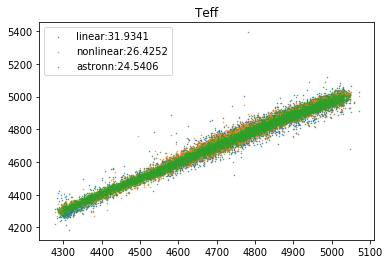

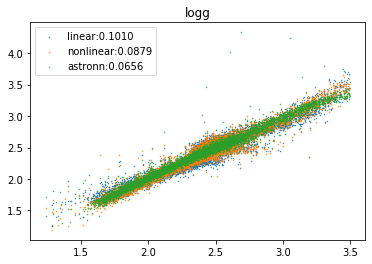

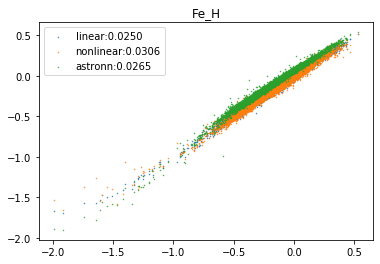

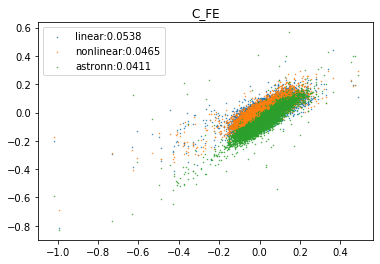

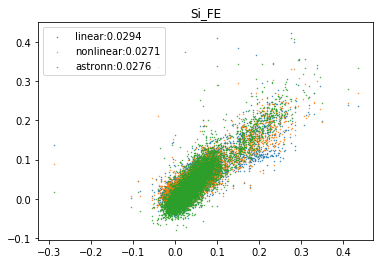

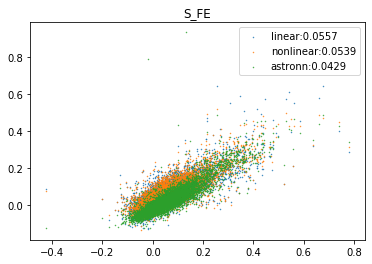

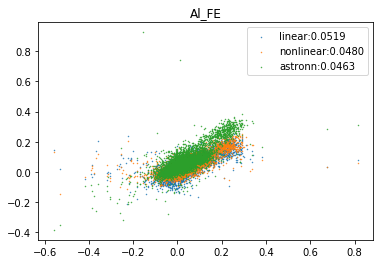

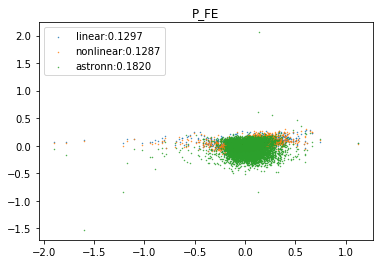

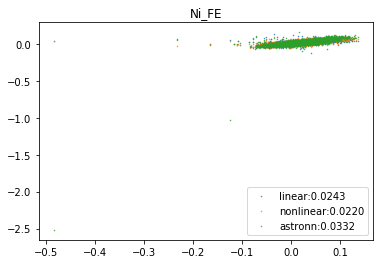

In [9]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

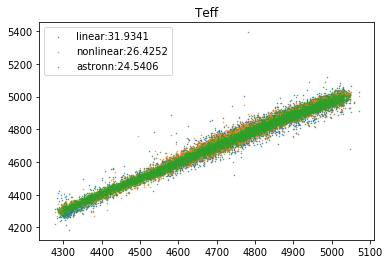

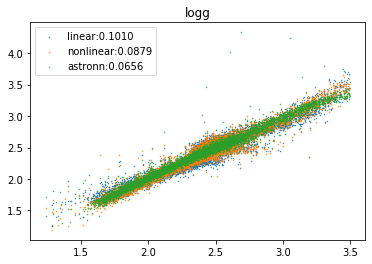

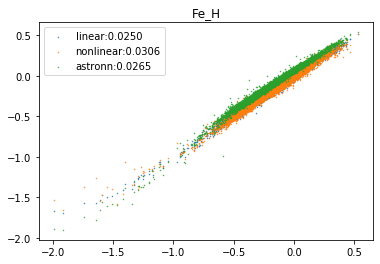

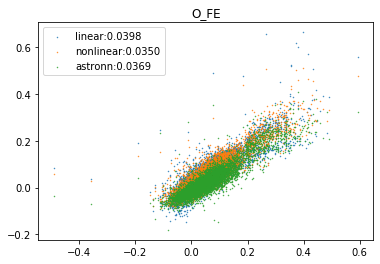

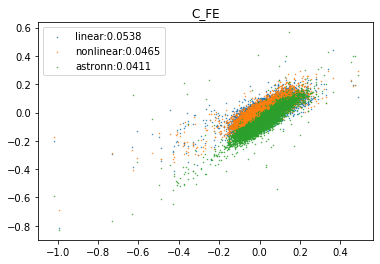

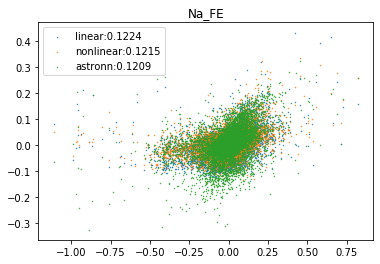

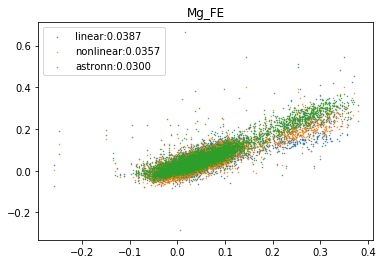

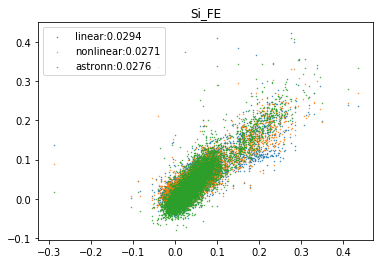

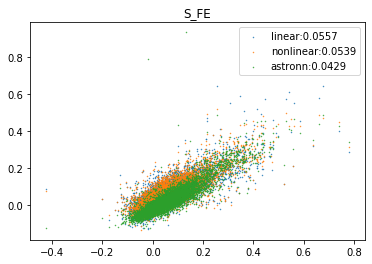

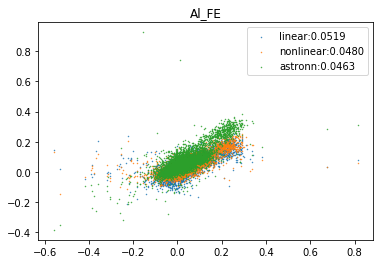

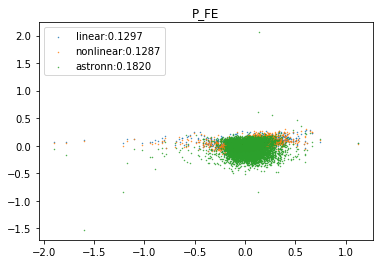

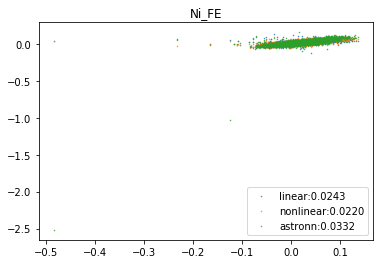

In [10]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

## Occam

### Loading Occam data

In [11]:
occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = AspcapDataset(filename="aspcap_occam",recenter=True,tensor_type=torch.FloatTensor,filling_dataset=dataset.dataset["aspcap"])

In [12]:
occam_cluster_idxs = occam["cluster_idxs"]
z_occam = vector.OccamLatentVector(occam_cluster_idxs,dataset=dataset_occam,autoencoder = autoencoder,n_data = len(dataset_occam))


/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,z = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


In what follows, we show a simple loop for identifying, using the reconstruction loss, any outlier spectra which are not well captured by the autoencoder

/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_pred,_ = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


0.4344048
0.31849432
0.3839289
0.5435099
0.5435099
3


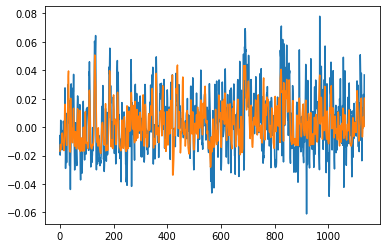

0.397539
0.34866586
0.32055566
0.42967615
0.43892074
0.5081159
0.5081159
9


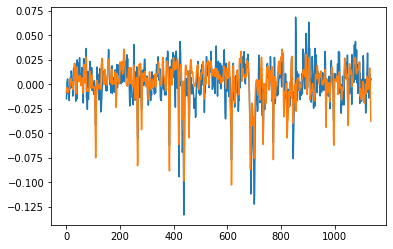

0.7057204
0.7057204
10


0.63799214
0.63799214
11


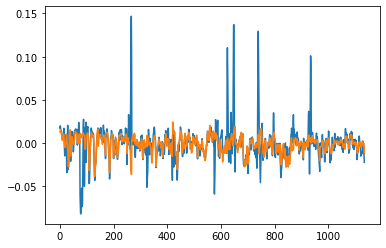

0.4410616
0.7067082
0.7067082
13


0.48119584
0.37700346
0.59894323
0.59894323
16


0.6040795
0.6040795
17


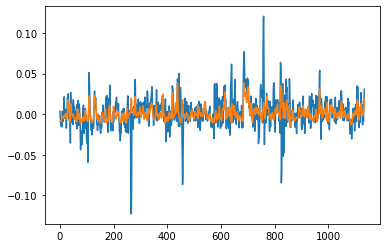

0.48695296
0.5013631
0.5013631
19


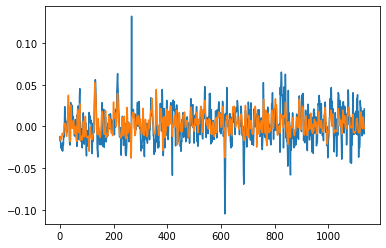

0.37251005
0.4608218
0.33043292
0.49356362
0.6177537
0.6177537
24


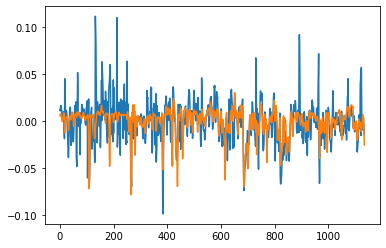

0.5366987
0.5366987
25


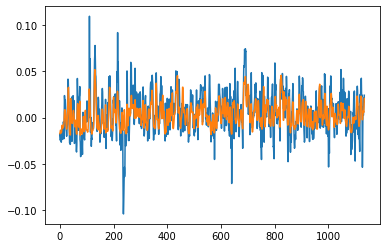

0.46972016
0.5066607
0.5066607
27


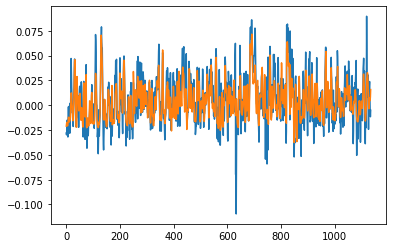

0.553589
0.553589
28


0.34502688
0.40431827
0.2655515
0.33181387
0.5380525
0.5380525
33


0.36840275
0.39592028
0.35287735
0.36903757
0.38934198
0.2922105
0.3456124
0.36996073
0.32371402
0.37792563
0.34971857
0.54581517
0.54581517
45


0.3609621
0.49952045
0.31413022
0.4980791
0.34718883
0.52688354
0.52688354
51


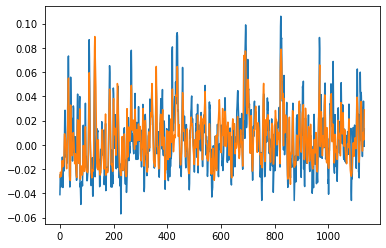

0.52564096
0.52564096
52


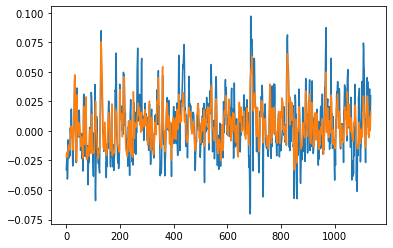

0.41440332
0.4256078
0.58780146
0.58780146
55


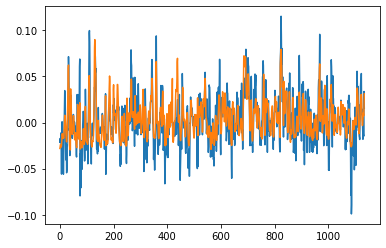

0.36596435
0.4212483
0.6108695
0.6108695
58


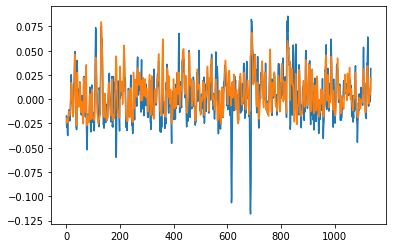

0.48214298
0.32641384
0.3850297
0.34480444
0.3224374
0.6751917
0.6751917
64


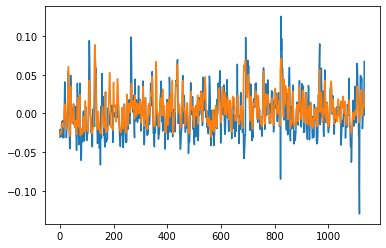

0.30225772
0.44278342
0.5190265
0.5190265
67


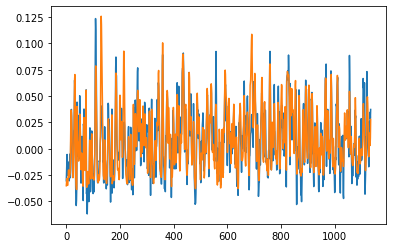

0.36663115
0.55574894
0.55574894
69


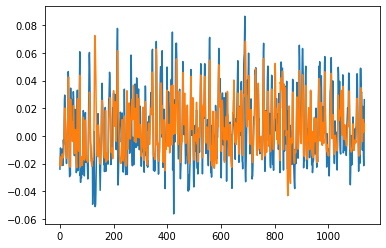

0.38321823
0.779174
0.779174
71


0.43084392
0.4211443
0.31766886
0.2893296
0.27076757
0.7665454
0.7665454
77


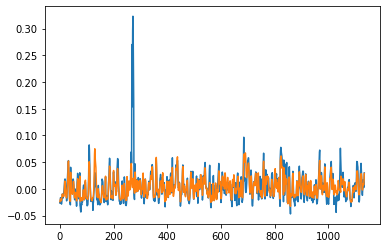

0.51275486
0.51275486
78


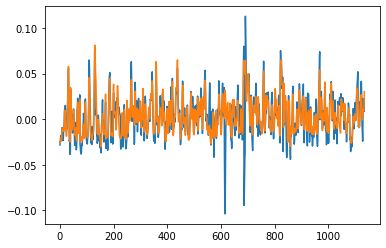

0.5170308
0.5170308
79


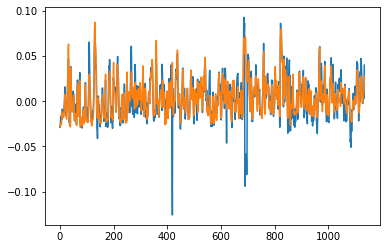

0.40265435
0.32674205
0.3524772
0.31544623
0.29316378
0.2901439
0.5249767
0.5249767
86


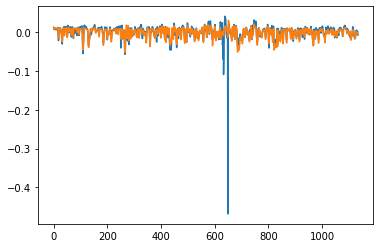

0.40561008
0.20502064
0.23062235
0.35676077
0.3027732
0.42451388
0.4583421
0.37335467
0.33744675
0.63917714
0.63917714
96


0.84015846
0.84015846
97


0.41478342
0.7650423
0.7650423
99


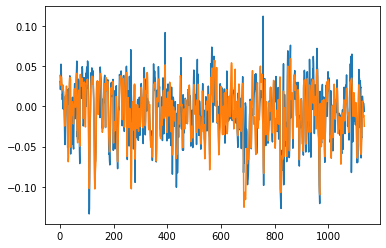

0.8067608
0.8067608
100


0.6336894
0.6336894
101


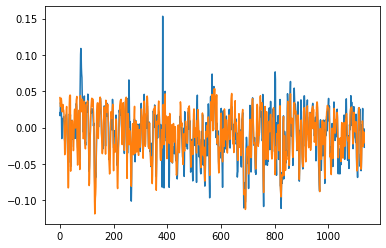

0.59153193
0.59153193
102


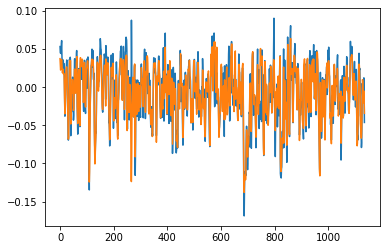

0.46280482
0.75401455
0.75401455
104


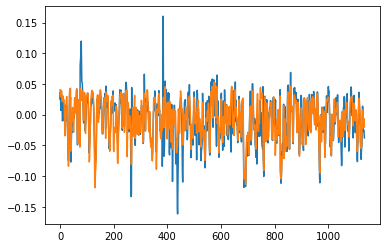

0.8515749
0.8515749
105


0.6318263
0.6318263
106


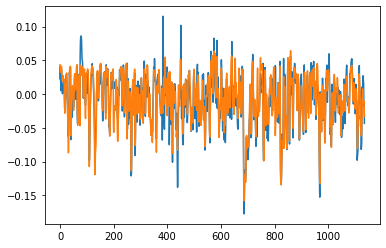

0.89172083
0.89172083
107


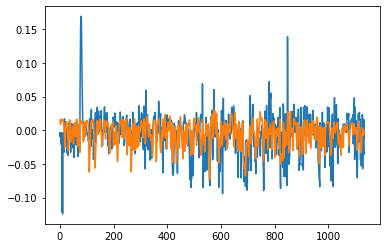

0.7796418
0.7796418
108


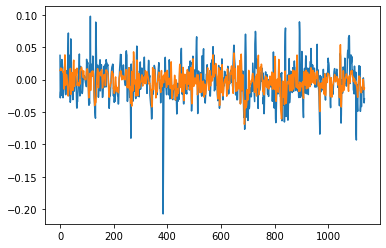

0.8501752
0.8501752
109


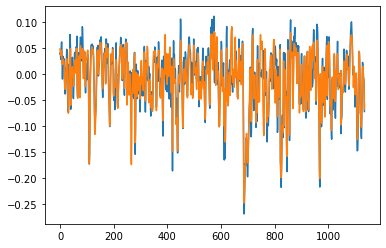

0.7994695
0.7994695
110


0.55613285
0.55613285
111


0.76856464
0.76856464
112


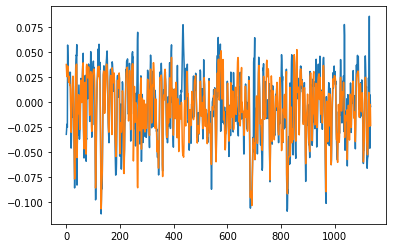

0.8752763
0.8752763
113


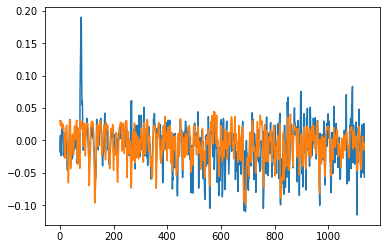

0.5806642
0.5806642
114


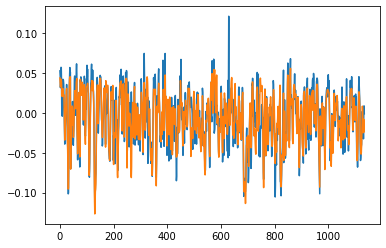

0.5890391
0.5890391
115


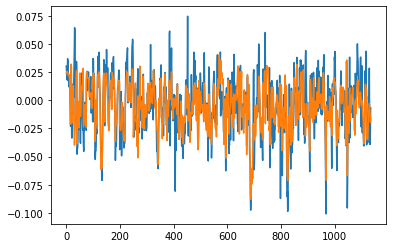

0.79065293
0.79065293
116


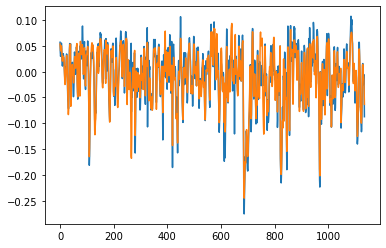

0.9758563
0.9758563
117


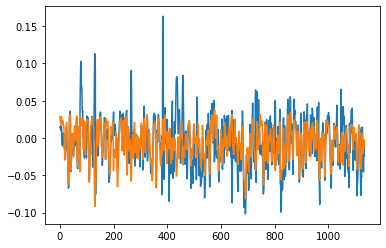

0.65477926
0.65477926
118


0.7792516
0.7792516
119


0.64767045
0.64767045
120


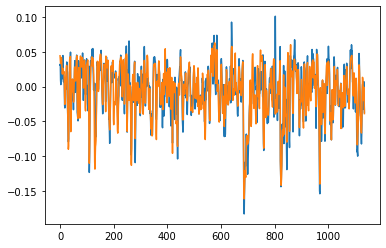

0.8125772
0.8125772
121


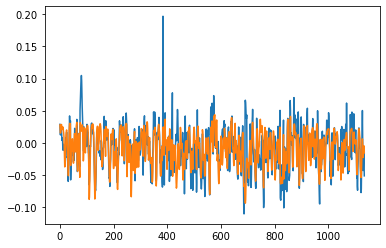

0.9010479
0.9010479
122


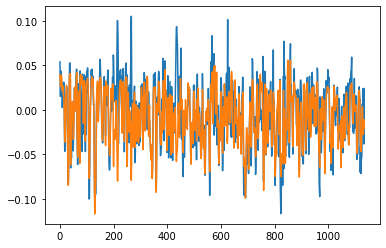

0.91811615
0.91811615
123


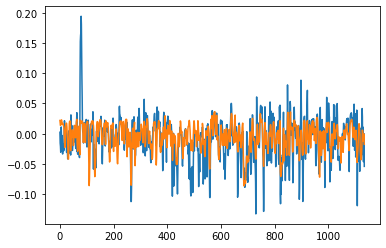

0.6293213
0.6293213
124


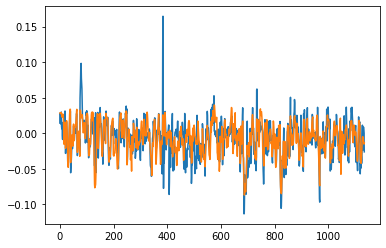

0.6446334
0.6446334
125


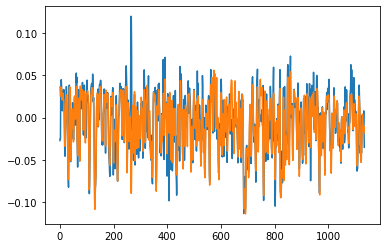

1.2344179
1.2344179
126


0.5802597
0.5802597
127


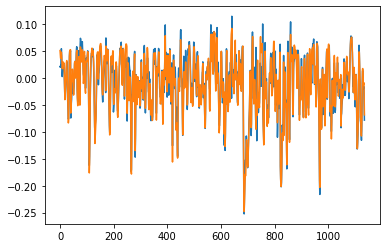

0.6386103
0.6386103
128


1.0828449
1.0828449
129


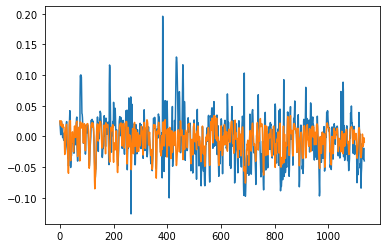

0.6272318
0.6272318
130


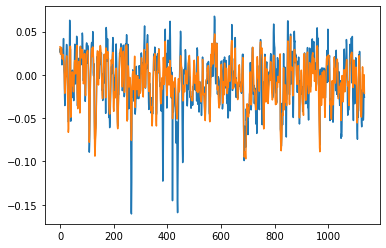

0.79438645
0.79438645
131


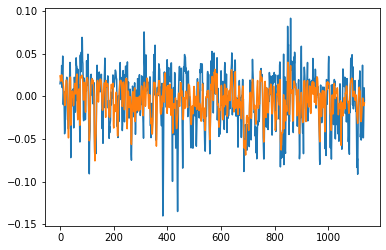

0.8668261
0.8668261
132


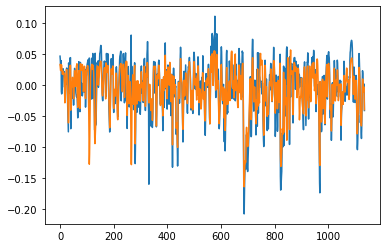

0.7312032
0.7312032
133


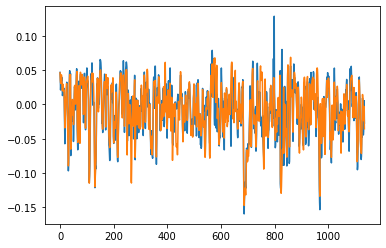

0.5195172
0.5195172
134


0.78167844
0.78167844
135


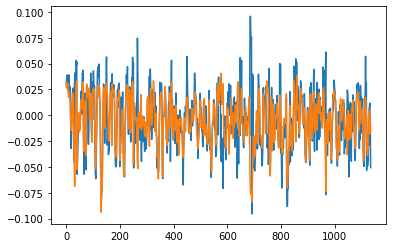

0.4558725
0.39281
0.30554268
0.42236245
0.38343248
0.39311185
0.46324465
0.35054773
0.3029866
0.4261512
0.34783316
0.3426735
0.4095956
0.32070675
0.43105564
0.30081755
0.39251232
0.3857223
0.31122017
0.32606223
0.35144442
0.38877347
0.30175385
0.37708348
0.2867093
0.26263136
0.24934438
0.5677737
0.5677737
163


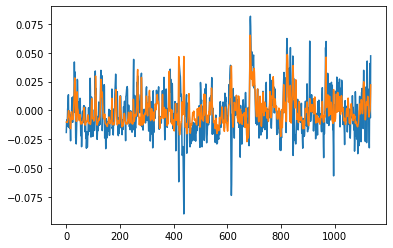

0.32871553
0.44970626
0.32371458
0.3750516
0.54988533
0.54988533
168


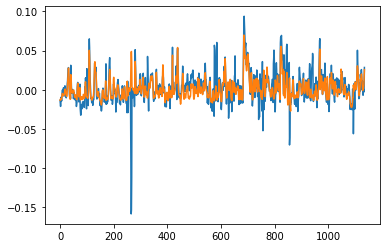

0.44791806
0.503289
0.503289
170


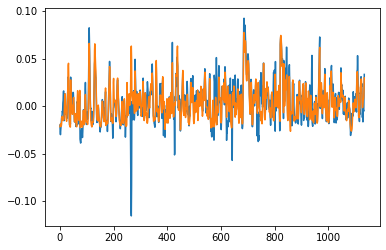

0.2678412
0.33296776
0.3824958
0.33301556
0.5331668
0.5331668
175


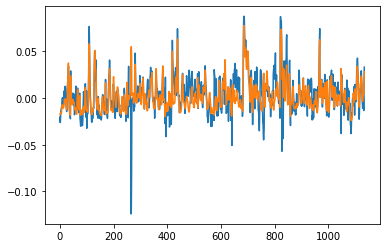

0.21420193
0.3262328
0.32942563
0.4305436
0.47411856
0.63802737
0.63802737
181


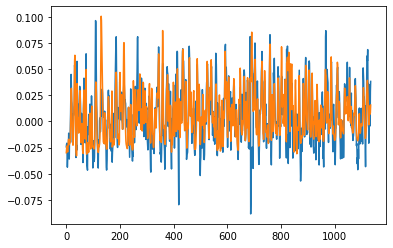

0.39998516
0.49422485
0.9578785
0.9578785
184


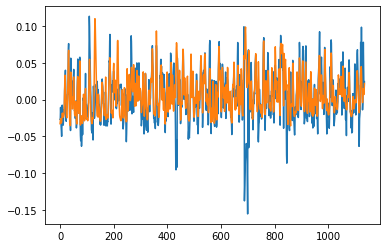

0.49724022


In [13]:
bad_indexes = []
for i in range(len(z_occam.raw)):
    err = np.sqrt(np.sum(((z_occam.get_x(i)[mask_elem.astype(bool)]-z_occam.get_x_pred(i))**2).detach().numpy()))
    print(err)
    if err>0.5:
        print(err)
        print(i)
        bad_indexes.append(i)
        plt.plot(z_occam.get_x(i)[mask_elem.astype(bool)])
        plt.plot(z_occam.get_x_pred(i))
        #z_occam.plot(i)
        plt.show()

We leave a commentedout piece of code for deleting any outlier spectra, if judged necessary.

retained= np.delete(np.arange(len(z_occam.raw)),bad_indexes)
retained

In [14]:
z_occam = vector.OccamLatentVector(occam_cluster_idxs,raw=z_occam.raw,order=2,interaction_only=False)

### PCA investigation

The PCA procedure involves two steps:

1. Transform the latent representations to a whitened representation. In the whitened representation, all factors of variation in the full dataset have appropriately equal variance. 

2. Find those factors of variations, in the whitened representation, which have lowest intracluster variance. 

In [15]:
whitener = PCA(n_components=z.raw.shape[1],whiten=True)#z.raw.shape[1],whiten=True)


In [16]:
whitener.fit(z.centered)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

now that we have learned a whitener. We transform our dataset to the new whitened space

In [17]:
w_z_c = whitener.transform(z.centered)
w_z_occam_c = whitener.transform(z_occam.cluster_centered)

Normally here the variance in all the directions, for the full dataset, should be roughly equal. We can check this

In [18]:
pca = PCA(n_components=z.raw.shape[1])
pca.fit(w_z_c[:2500,:])
print(pca.explained_variance_)

[1.802771   1.5591778  1.4454083  1.3495046  1.2860638  1.2434659
 1.23258    1.1716186  1.1575558  1.139176   1.0499316  1.0225755
 0.96675974 0.93446285 0.9080828  0.8783351  0.81475616 0.79842615
 0.67653227 0.5892971 ]


Hopefully when we look at clusters, there should be some directions along which there are not really any variations

In [19]:
pca.fit(w_z_occam_c)
print(pca.explained_variance_)

[15.40243002  5.43671681  3.21085023  2.68020685  1.66670769  1.5412482
  1.19230394  1.11622418  0.97690996  0.74037317  0.44054532  0.42123793
  0.33317249  0.23672297  0.22499528  0.17320721  0.12677248  0.05613802
  0.04294349  0.03229557]


### Assessing Open clusters

Our latent representations merit is evaluated by looking at how much variance is found within clusters compared to within full dataset. Because we don't want our representation to be influenced by outlier datapoints (where the model has failed), we threshold the most outlier datapoints.

**In this exercise, we compare Fe/H, the most well estimated parameter, to our latents smallest direction of variation**

In [20]:
dim = 18
zc_b = vector.project(w_z_c,pca.components_[dim][None,:])
zoccam_b = vector.project(w_z_occam_c,pca.components_[dim][None,:])

occam: 0.012499224892015574
raw: 0.2675367290748935
ratio: 21.40426557536334


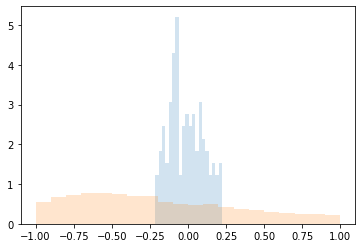

In [21]:
summarize_representation(zc_b,zoccam_b,0.2,0.2)

### Comparing to raw abundances

We can compare our representations expressiveness to the raw abundances.

In [22]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [23]:
abundances_occam = []
elem = "Fe_H"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_occam.append(allStar_occam[clust_idxs][elem]-np.mean(allStar_occam[clust_idxs][elem]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_occam = np.array(flatten(abundances_occam))

In [24]:
abundances_all = y.raw[:,elem_idx]-np.mean(y.raw[:,elem_idx])

occam: 0.0003519254387356341
raw: 0.02112654224038124
ratio: 60.03130340576172


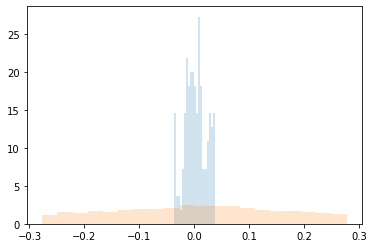

In [25]:
summarize_representation(abundances_all,abundances_occam,0.2,0.2)

### Comparing to astroNN

In [26]:
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)
y_astronn_occam = vector.AstroNNVector(allStar_occam,considered_parameters)

In [36]:
abundances_nn_occam = []
elem = "logg"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_nn_occam.append(y_astronn_occam.raw[clust_idxs,elem_idx]-np.mean(y_astronn_occam.raw[clust_idxs,elem_idx]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_nn_occam = np.array(flatten(abundances_nn_occam))

In [37]:
abundances_nn_all  =y_astronn.raw[:,elem_idx]-np.mean(y_astronn.raw[:,elem_idx])


occam: 0.015747180208563805
raw: 0.039577417075634
ratio: 2.5133018493652344


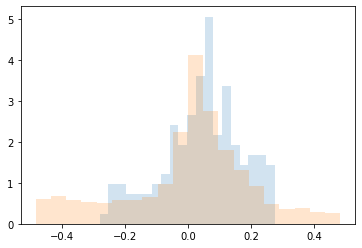

In [38]:
summarize_representation(abundances_nn_all,abundances_nn_occam,0.2,0.2)